# Workflow to Validate OPERA DISP-S1 Transient Displacement Requirements

**Original code authored by:** NISAR Science Team Members and Affiliates  
**Updated by:** OPERA DISP-S1 CalVal team

*July 2024*

*OPERA DISP-S1 CalVal team*

<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

## Define CalVal Site 

In [1]:
# Parameters for papermill

site = 'F08882'     # site for DISP-S1 (rame ID)
work_dir = './'
mintpy_dir = 'mintpy_output'    # location of mintpy files 
inputs_dir = 'inputs'           # directory of ifgramStack.h5 inside mintpy_dir
output_dir = 'results'          # location to store output figures and text files
vmin = -50  # vmin/vmax for plotting
vmax = 50

calval_sites_csv = 'validation_data/DISP-S1_CalVal_sites.csv'

time_interval_thr = 12    # time interval threshold: only temporal baselines equal or less than 12 days are considered

# Mask file used for validation
maskFile = 'mask_temporalCoherence.h5' # maskSpatialCoh.h5, inputs/combined_msk.h5

# Define spatial coherence threshold (necessary to reject poor quality, long temporal baseline pairs)
minCoherence_parm = '0.6'
minTempCoherence_parm = '0.6'

#Set GNSS Parameters
gps_completeness_threshold = 0.8    #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 10.  #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

#variability score threshold
apply_nonlinear_mask = True     # if apply non linear score mask
thr_var_score = 0.6      # variability score threshold

In [2]:
# load packages
import os
from datetime import datetime as dt
from pathlib import Path
import itertools

import copy
import random

import h5py

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib
import matplotlib.colors
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 12})

# multi-processing related packages
import multiprocessing
from itertools import product
from functools import partial
from tqdm import tqdm
import psutil
ncpus = len(psutil.Process().cpu_affinity())    # number of available CPUs
print("number of available CPUs: ", ncpus)

from mintpy.objects import gnss
from mintpy.utils import readfile, utils as ut, utils0 as ut0
from mintpy.cli import view, generate_mask

from solid_utils.sampling import load_geo_utm, samp_pair, euclidean_distance
from solid_utils.plotting import plot_transient_table

import warnings
warnings.filterwarnings("ignore")

number of available CPUs:  128


## Table of Contents:
<a id='secular_TOC'></a>

<hr/>

[**Prep A. Environment Setup**](#transient_prep_a)

[**Prep B. Data Staging**](#transient_prep_b)

[**1. Generate DISP-S1 Stack**](#transient_gen_ifg)
- [1.1.  Crop DISP-S1s](#transient_crop_ifg)

[**2. Optional Corrections**](#transient_opt_correction)
- [2.1. Solid Earth Tides Correction](#transient_solid_earth)
- [2.2. Tropospheric Delay Correction](#transient_tropo_corr)
- [2.3. Topographic Residual Correction ](#transient_tropo_res_corr)

[**3. Make GNSS LOS Measurements**](#transient_gnss_los)
- [3.1. Find Collocated GNSS Stations](#transient_co_gnss)  
- [3.2. Make GNSS LOS Measurements](#transient_gnss_los2) 
- [3.3. Make GNSS and InSAR Relative Displacements](#transient_gnss_insar)

[**4. NISAR Validation Approach 1: GNSS-InSAR Direct Comparison**](#transient_validation1)
- [4.1. Pair up GNSS stations and make measurement residuals](#transient_pair1)
- [4.2. Validate the requirement based on binned measurement residuals](#transient_bin1)
- [4.3. Result visualization](#transient_result1)
- [4.3. Conclusion](#transient_conclusion1)

[**5. NISAR Validation Approach 2: Noise Level Validation**](#transient_validation2)
- [5.1. Randomly sample pixels and pair them up](#transient_pair2)
- [5.2. Validate the requirement based on binned measurement residuals](#transient_bin2)
- [5.3. Result visualization](#transient_result2)
- [5.3. Conclusion](#transient_conclusion2)

[**6. Appendix: GNSS Position Plots**](#transient_appendix)

<hr/>

<a id='transient_prep_a'></a>
## Prep A. Environment Setup
Setup your environment for processing data

In [3]:
################# Set Directories ##########################################
print('\nCurrent directory:', os.getcwd())

if 'work_dir' not in locals():
    work_dir = Path.cwd()

work_dir = os.path.abspath(work_dir)    # absolute path       
print("Work directory:", work_dir)
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)  # Change to Workdir   

mintpy_dir = f'{work_dir}/{mintpy_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(mintpy_dir):
    raise FileNotFoundError(f"The folder '{mintpy_dir}' does not exist.")
print("   MintPy  dir:", mintpy_dir)

inputs_dir = f'{mintpy_dir}/{inputs_dir}'     # absolute path of mintpy directory 
if not os.path.isdir(inputs_dir):
    raise FileNotFoundError(f"The folder '{inputs_dir}' does not exist.")
print("   inputs  dir:", inputs_dir)

output_dir = f'{work_dir}/{output_dir}'     # absolute path of output directory
os.makedirs(output_dir, exist_ok=True)
print("   output  dir:", output_dir)

############################################################################
### List of OPERA DISP-S1 Cal/Val Sites for secular requirements:
if os.path.exists(calval_sites_csv):
    sites_df = pd.read_csv(calval_sites_csv) 
else:
    raise FileNotFoundError(f"The file {calval_sites_csv} does not exist.")  

display(sites_df)

available_sites = sites_df['site'].values


Current directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882
Work directory: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882
   MintPy  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output
   inputs  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output/inputs
   output  dir: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/results


site     calval_location   reference_lalo gps_ref_site_name priority
0  F08882             Houston   29.692 -95.635              ALEF     high
1  F11115  Central California  37.104 -121.651              P217     high
2  F11116  Central California  36.612 -121.064              P249     high
3  F12640             Florida   29.056 -81.263              DLND     high
4  F18903            Rosamond  35.039 -118.006              P579     high
5  F28486            Oklahoma   34.133 -99.283              TXVE     high
6  F33039              Hawaii  19.450 -155.525              ELEP     high
7  F33065       Unimak Island  54.831 -163.781              AV38     high
8  F36542  Central California  36.516 -120.853              P286     high
9  F42779              Alaska  61.550 -149.327              STEM     high

In [4]:
# specify GNSS source for validation

gnss_source = 'UNR'
print(f'Searching for all GNSS stations from source: {gnss_source}')
print(f'May use any of the following supported sources: {gnss.GNSS_SOURCES}')
GNSS = gnss.get_gnss_class(gnss_source)

Searching for all GNSS stations from source: UNR
May use any of the following supported sources: ['UNR', 'ESESES', 'JPL-SIDESHOW', 'GENERIC']


In [5]:
#Set Global Plot Parameters
ifgs_file = f'{inputs_dir}/ifgramStack.h5'
geom_file = f'{mintpy_dir}/geometryGeo.h5'

if os.path.exists(ifgs_file) and os.path.exists(geom_file):
    print(f'{ifgs_file} and {geom_file} exist and we can continue this validation.')
else:
    raise FileNotFoundError(f"The {ifgs_file} and/or {geom_file} do not exist and are required for this validation.")

# Set path to mask file
msk_file = os.path.join(mintpy_dir, maskFile) 

if site not in available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    display(sites_df[sites_df['site'] == site])

os.chdir(mintpy_dir)  # move to MintPy directory 

/lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output/inputs/ifgramStack.h5 and /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output/geometryGeo.h5 exist and we can continue this validation.

Selected site: F08882


site calval_location  reference_lalo gps_ref_site_name priority
0  F08882         Houston  29.692 -95.635              ALEF     high

run view.py in MintPy version 1.6.0.post11, date 2024-06-25
input file is mask file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output/mask_temporalCoherence.h5 in bool format
file size in y/x: (7733, 9464)
input dataset: "['mask']"
num of datasets in file mask_temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 9464, 7733)
subset coverage in y/x: (0, 0, 9464, 7733)
data   coverage in lat/lon: (71970.0, 3385920.0, 355890.0, 3153930.0)
subset coverage in lat/lon: (71970.0, 3385920.0, 355890.0, 3153930.0)
------------------------------------------------------------------------
colormap: jet
figure title: mask_temporalCoherence
figure size : [9.2, 6.0]
reading data ...
data has uniform and limited number (2 <= 20) of unique values --> discretize colormap
data    range: [False, True] 1
display range: [-0.5, 1.5] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image

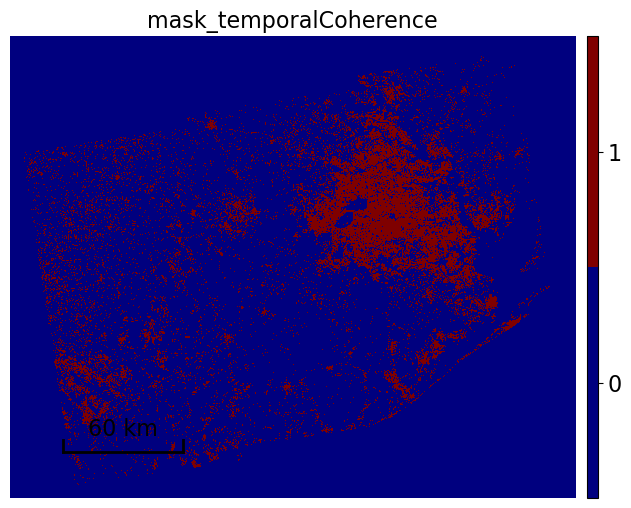

In [6]:
if not os.path.exists(msk_file):

    if (os.path.basename(msk_file) == 'maskSpatialCoh.h5'):

        if not os.path.exists('avgSpatialCoh.h5'):
            raise FileNotFoundError("cannot find avgSpatialCoh.h5")
        
        view.main(f'avgSpatialCoh.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'avgSpatialCoh.h5', '-m', minCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)

    elif (os.path.basename(msk_file) == 'mask_temporalCoherence.h5'):

        if not os.path.exists('inputs/temporalCoherence.h5'):
            raise FileNotFoundError("cannot find inputs/temporalCoherence.h5")
        
        view.main(f'inputs/temporalCoherence.h5 --noaxis --noverbose'.split()) # average spatial coherence

        iargs = [f'inputs/temporalCoherence.h5', '-m', minTempCoherence_parm, '-o', maskFile]
        generate_mask.main(iargs)

    else:
        raise FileNotFoundError(f"The maskfile {msk_file} not found.")

# view mask
view.main([msk_file, 'mask', '--noaxis'])

mask_lyr, _ = readfile.read(msk_file)    # reading maskfile

In [7]:
# reading area of DISP-S1
disp_S1_metadata = readfile.read_attribute(ifgs_file)

assert 'UTM_ZONE' in disp_S1_metadata.keys()  # make sure data in UTM zone

DISP_region = list(ut.four_corners(disp_S1_metadata))

geo_S, geo_W = ut0.utm2latlon(disp_S1_metadata, DISP_region[2], DISP_region[0])
geo_N, geo_E = ut0.utm2latlon(disp_S1_metadata, DISP_region[3], DISP_region[1])
DISP_region_geo = (geo_S, geo_N, geo_W, geo_E)

print(f'region of DISP-S1 (UTM): {DISP_region}, Zone: {disp_S1_metadata["UTM_ZONE"]}')
print('region of DISP-S1 (lat/lon): ', DISP_region_geo)

wavelength = float(disp_S1_metadata['WAVELENGTH'])
global phase2range
phase2range = wavelength/(4*np.pi)

region of DISP-S1 (UTM): [3153930.0, 3385920.0, 71970.0, 355890.0], Zone: 15N
region of DISP-S1 (lat/lon):  (28.441833514285623, 30.597152075782297, -97.36895537811154, -94.50317572999602)


In [8]:
# # Instead of bringing all data into memory, we will read files when needed.    
def read_ifgram_hdf(hdf_file, keyword, channel=None, coh_thr=None):
    valid_keywords = ['coherence', 'date', 'unwrapPhase']
    if keyword not in valid_keywords:
        raise KeyError(f"Keyword '{keyword}' not found in the {hdf_file} file. Valid keywords are {valid_keywords}")

    with h5py.File(hdf_file, 'r') as f:
        if keyword == 'date':
            return f[keyword][()]

        data = f[keyword]
        num_ifgs, *_ = data.shape

        if channel is not None and channel >= num_ifgs:
            raise ValueError(f"Input channel {channel} exceeds the number of possible ifgrams ({num_ifgs})")

        output = data[channel] if channel is not None else data[:]

        if keyword == 'unwrapPhase' and coh_thr is not None:
            coh_data = f['coherence']
            coh = coh_data[channel] if channel is not None else coh_data[:]
            output[coh < float(coh_thr)] = np.nan

        return output
    
def slice_mask(arr, mask=None, cor_ref=None):
    """
    Mask and process a slice of an array.
    
    Args:
    arr (np.ndarray): Input array to be masked.
    mask (list of np.ndarray, optional): List of mask arrays.
    cor_ref (np.ndarray, optional): Reference array to be subtracted.
    
    Returns:
    np.ndarray: Processed array.
    """
    # Convert to numpy array if not already
    arr = np.asarray(arr)
    
    # Replace zeros with NaN
    arr[arr == 0] = np.nan
    
    # Apply masks if provided
    if mask is not None:
        arr[np.logical_or.reduce([m == 0 for m in mask])] = np.nan
    
    # Subtract reference if provided
    if cor_ref is not None:
        arr -= cor_ref
    
    return arr

Load the date of DISP-S1s into Python:

In [9]:
ifgs_date = read_ifgram_hdf(ifgs_file, 'date')  # all ifgs date in ifgramStack.h5
ifgs_date_dt = [ [dt.strptime(ref_date.decode(), '%Y%m%d'), dt.strptime(sec_date.decode(), '%Y%m%d')] for ref_date, sec_date in ifgs_date]  # ifgs_date in datetime format
ifgs_date_dt = np.array(ifgs_date_dt)   # all valuable ifgs dates will be kept with dates_index

Remove DISP-S1s with time interval larger than 12 days:

In [10]:
dates_index = []    # dates index only to be used for CalVal
dates_filter_flag = True   # if dates are filtered based on time interval of sequential pairs

# DISP-S1 has a single reference date for time-series
assert len(set(ifgs_date[:,0])) == 1     # The DISP-S1 should have a single reference date.

if dates_filter_flag:
    # filtered by time interval threshold
    for ii, (ref_date, sec_date) in enumerate(ifgs_date_dt):

        if (ii==0):
            delta_day = (sec_date-ref_date).days
            prev_sec_date = sec_date
        else:
            delta_day = (sec_date-prev_sec_date).days
            prev_sec_date = sec_date

        if delta_day <= time_interval_thr:
            dates_index.append(ii)
else:
    dates_index = list(range(len(ifgs_date_dt)))        # all data used for validation

# printing which pair will be used for validation
print(f'Number of pairs to be used for validation: {len(dates_index)}')
print('Pairs to be used for validation')
for ii in dates_index:
    print(ifgs_date_dt[ii,0].strftime('%Y%m%d'), ifgs_date_dt[ii,1].strftime('%Y%m%d'))

Number of pairs to be used for validation: 181
Pairs to be used for validation
20160927 20161009
20160927 20161021
20160927 20161102
20160927 20161114
20160927 20161126
20160927 20161208
20160927 20161220
20160927 20170101
20160927 20170113
20160927 20170125
20160927 20170206
20160927 20170218
20160927 20170326
20160927 20170407
20160927 20170419
20160927 20170501
20160927 20170513
20160927 20170525
20160927 20170606
20160927 20170712
20160927 20170724
20160927 20170805
20160927 20170910
20160927 20171016
20160927 20171121
20160927 20171203
20160927 20180108
20160927 20180120
20160927 20180201
20160927 20180213
20160927 20180225
20160927 20180309
20160927 20180321
20160927 20180402
20160927 20180414
20160927 20180426
20160927 20180508
20160927 20180520
20160927 20180601
20160927 20180613
20160927 20180625
20160927 20180707
20160927 20180719
20160927 20180731
20160927 20180812
20160927 20180824
20160927 20180905
20160927 20180917
20160927 20180929
20160927 20181011
20160927 20181023
201

- `disp_S1_metadata`: metadata of DISP-S1 stacks, including incident angle, longitude and latitude step width, etc
- `dates_index`: indices used for further CalVal excluding pairs not meeting temporal baseline thresholds or minimum GNSS observations
- `ifgs_date_dt`: list of DISP-S1 dates in datetime format used for CalVal along with `dates_index`

### Applying nonlinear-displacement mask

Creating mask_nonDispScore.h5 mask file
input mask file: /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output/nonDispScore.h5
read /lustre/work/client/group/zhonglu/lu_lab/Jinwoo/OPERA_DISP/PST/F08882/mintpy_output/nonDispScore.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value > 0.6
create HDF5 file: mask_nonDispScore.h5 with w mode
create dataset /mask of bool       in size of (7733, 9464)         with compression=None
finished writing to mask_nonDispScore.h5
time used: 00 mins 0.6 secs.


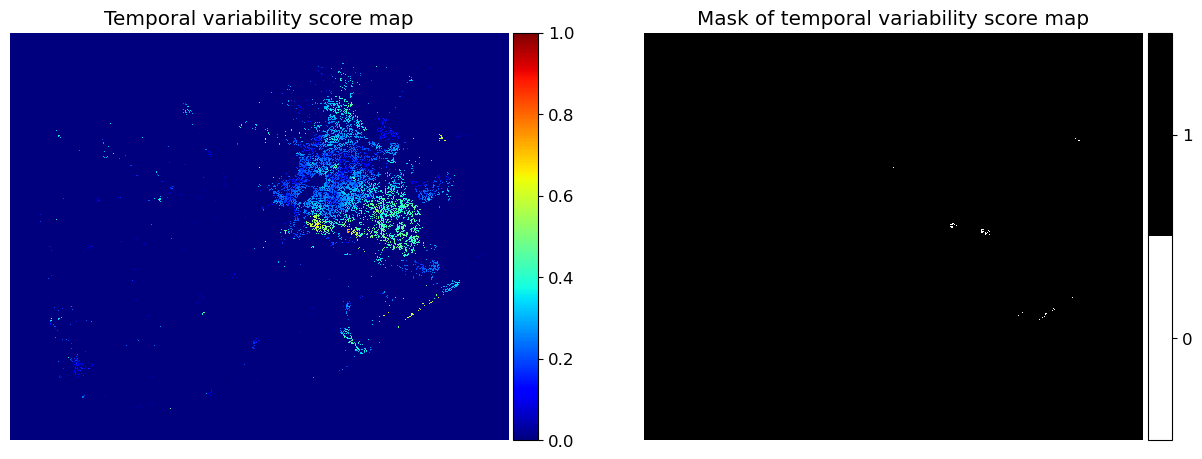

In [11]:
score_map_file = 'nonDispScore.h5'
score_map_file = os.path.join(mintpy_dir, score_map_file)

if apply_nonlinear_mask:

    variability_scores = readfile.read(score_map_file)[0]
    mask_var_score = variability_scores < thr_var_score     # selecting pixels with small temporal variability score

    mask_score_map_file = 'mask_nonDispScore.h5'
    if os.path.exists(mask_score_map_file):
        print(f'{mask_score_map_file} already exists.')
    else:
        print(f'Creating {mask_score_map_file} mask file')
        iargs = [f'{score_map_file}', '-M', str(thr_var_score), '-o', mask_score_map_file]
        generate_mask.main(iargs)       

    mask_var_score, _ = readfile.read(mask_score_map_file)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

    im1 = ax1.imshow(variability_scores, cmap='jet', vmin=0, vmax=1, interpolation='none')
    ax1.axis('off')
    ax1.set_title('Temporal variability score map')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    cmap_bw = matplotlib.colors.ListedColormap(['white', 'black'])
    im2 = ax2.imshow(mask_var_score, cmap_bw, interpolation='none')
    ax2.axis('off')
    ax2.set_title('Mask of temporal variability score map')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2, cax=cax)
    cbar.set_ticks([0.25, 0.75])    # Set tick locations to the center of each color range
    cbar.set_ticklabels(['0', '1'])     # Set tick labels

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cax.axis('off')

<a id='transient_gnss_los'></a>
# Make GNSS LOS Measurements

<a id='transient_co_gnss'></a>
## Find Collocated GNSS Stations
The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

Get space and time range for searching GNSS station: 

In [12]:
# get analysis metadata from DISP-S1 stack
start_date = ifgs_date_dt[dates_index[0],0].strftime('%Y%m%d')
end_date = ifgs_date_dt[dates_index[-1],1].strftime('%Y%m%d')

start_date_gnss = ifgs_date_dt[dates_index[0],0]
end_date_gnss = ifgs_date_dt[dates_index[-1],1]

geom_file = os.path.join(mintpy_dir, 'geometryGeo.h5')
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle')[0]
inc_angle = np.nanmean(inc_angle)
az_angle = readfile.read(geom_file, datasetName='azimuthAngle')[0]
az_angle = np.nanmean(az_angle)

# search for collocated GNSS stations
site_names, site_lats_wgs84, site_lons_wgs84 = gnss.search_gnss(SNWE=DISP_region_geo,
                                                                start_date=start_date,
                                                                end_date=end_date,
                                                                source=gnss_source)
# post-query: convert lat/lon to UTM for plotting
site_north, site_east = ut0.latlon2utm(disp_S1_metadata, site_lats_wgs84, site_lons_wgs84)

site_names = [str(stn) for stn in site_names]
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

load 22027 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (28.441833514285623, 30.597152075782297, -97.36895537811154, -94.50317572999602): [155]
keep sites with end_date >= 20160927: [140]
keep sites with start_date <= 20230717: [136]
keep sites with # of solutions >= 50: [134]
['ADKS' 'ALEF' 'ALVN' 'ANG5' 'ANG6' 'AULT' 'CFHS' 'CFJV' 'CMFB' 'COH1'
 'COH2' 'COTM' 'CSTE' 'DEN1' 'DEN2' 'DEN3' 'DEN4' 'DISD' 'DMFB' 'DWI1'
 'FSFB' 'GSEC' 'HCC1' 'HCC2' 'HPEK' 'HSMN' 'JGS2' 'KKES' 'KPCD' 'KPCS'
 'LCBR' 'LCFL' 'LCI1' 'LCSM' 'LKHU' 'MDWD' 'ME01' 'MEPD' 'MRHK' 'N301'
 'NASA' 'NETP' 'OKEK' 'PA00' 'PWES' 'RDCT' 'ROD1' 'ROPS' 'RPFB' 'SESG'
 'SHSG' 'SISD' 'SPBH' 'TDAM' 'THSU' 'TSFT' 'TX02' 'TXAC' 'TXAG' 'TXAV'
 'TXB6' 'TXBC' 'TXBH' 'TXBS' 'TXC5' 'TXC8' 'TXCF' 'TXCM' 'TXCN' 'TXCU'
 'TXCV' 'TXCY' 'TXCZ' 'TXDY' 'TXED' 'TXET' 'TXGA' 'TXGG' 'TXH3' 'TXH4'
 'TXH5' 'TXH6' 'TXHA' 'TXHE' 'TXHS' 'TXKY' 'TXLC' 'TXLG' 'TXLI' 'TXLM'
 'TXLQ' 'TXMG' 'TXNH' 'TXNV' 'TX

<a id='transient_gnss_los2'></a>
## Make GNSS LOS Measurements

In this step, the 3-D GNSS observations are projected into LOS direction. The DISP-S1 measurements are averaged 3 by 3 near the station positions.

In [13]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_north = [] 
use_east = []
# track latlon coordinates for UTM grids
use_lats_keepwgs84 = [] 
use_lons_keepwgs84 = []

for counter, stn in enumerate(site_names):
    gps_obj = GNSS(site = stn,
                   data_dir = os.path.join(mintpy_dir,f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss, end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # for this quick screening check of data quality, we use the constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days * gps_completeness_threshold <= gnss_count:
        if (stn_stdv > gps_residual_stdev_threshold):
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_north.append(site_north[counter])
            use_east.append(site_east[counter])
            use_lats_keepwgs84.append(site_lats_wgs84[counter])
            use_lons_keepwgs84.append(site_lons_wgs84[counter])
    else:
        bad_stn.append(stn)

site_names = use_stn
site_north = use_north
site_east = use_east
site_lats_wgs84 = use_lats_keepwgs84
site_lons_wgs84 = use_lons_keepwgs84

# [optional] manually remove additional stations
gnss_to_remove=[]

for i, gnss_site in enumerate(gnss_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)


Final list of 84 stations used in analysis:
['ADKS', 'ALEF', 'AULT', 'CFHS', 'CFJV', 'CMFB', 'COH2', 'COTM', 'CSTE', 'DEN1', 'DISD', 'DMFB', 'DWI1', 'FSFB', 'GSEC', 'HCC1', 'HSMN', 'JGS2', 'KKES', 'KPCD', 'LCFL', 'LCSM', 'LKHU', 'MDWD', 'MEPD', 'MRHK', 'NASA', 'NETP', 'OKEK', 'PWES', 'RDCT', 'ROD1', 'RPFB', 'SESG', 'SHSG', 'SISD', 'SPBH', 'TDAM', 'THSU', 'TSFT', 'TXAC', 'TXBC', 'TXBH', 'TXBS', 'TXC5', 'TXCF', 'TXCM', 'TXCN', 'TXCU', 'TXCY', 'TXGA', 'TXGG', 'TXHA', 'TXHE', 'TXLG', 'TXLI', 'TXLM', 'TXLQ', 'TXMG', 'TXNV', 'TXPV', 'TXRN', 'TXTG', 'TXVA', 'TXVC', 'TXWH', 'TXWN', 'UH02', 'UHC0', 'UHC1', 'UHC2', 'UHC3', 'UHCL', 'UHCR', 'UHDT', 'UHEB', 'UHEP', 'UHRI', 'UTEX', 'WCHT', 'WDVW', 'WEPD', 'WHCR', 'ZHU1']
List of 50 stations removed from analysis
['ALVN', 'ANG5', 'ANG6', 'COH1', 'DEN2', 'DEN3', 'DEN4', 'HCC2', 'HPEK', 'KPCS', 'LCBR', 'LCI1', 'ME01', 'N301', 'PA00', 'ROPS', 'TX02', 'TXAG', 'TXAV', 'TXB6', 'TXC8', 'TXCV', 'TXCZ', 'TXDY', 'TXED', 'TXET', 'TXH3', 'TXH4', 'TXH5', 'TXH6',

Get daily position solutions for GNSS stations:

In [14]:
def process_station(args, ifgs_date_dt, mintpy_dir, gnss_source, geom_file, disp_S1_metadata, site_north, site_east, site_lats_wgs84, 
                    site_lons_wgs84, ifgs_file, msk_file, mask_var_score_file=None):
    counter, stn, i = args  # counter is for counting gnss stations / i is index for dates_index

    gps_obj = GNSS(site=stn, data_dir=os.path.join(mintpy_dir, f'GNSS-{gnss_source}'))
    gps_obj.open(print_msg=False)
    
    gps_obj.read_displacement(print_msg=False)
    dates = gps_obj.dates
    
    start_date = ifgs_date_dt[i, 0]     # start date of ith DISP-S1
    end_date = ifgs_date_dt[i, 1]       # end date of ith DISP-S1
    
    range_days = (end_date - start_date).days
    gnss_count = np.histogram(dates, bins=[start_date, end_date])
    gnss_count = int(gnss_count[0])
    
    if range_days == gnss_count - 1:
        _, disp_gnss_time_series, disp_gnss_time_series_std, site_latlon = gps_obj.get_los_displacement(
            str(geom_file),
            start_date=start_date.strftime('%Y%m%d'),
            end_date=end_date.strftime('%Y%m%d'))[:4]
        
        y_value, x_value = ut.coordinate(disp_S1_metadata).geo2radar(site_latlon[0], site_latlon[1])[:2]
        
        stn_north = float(site_north[counter])  # location of gnss stations in UTM coordinates
        stn_east = float(site_east[counter])
        site_NE = [stn_north, stn_east]
        site_latlon = [float(site_lats_wgs84[counter]), float(site_lons_wgs84[counter])]    # location of gnss stations in geographic coordinates
        
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i, coh_thr=minCoherence_parm) * phase2range * 1000  # reading only a corresponding pair for validation
        mask_lyr, _ = readfile.read(msk_file)    # reading maskfile
        if mask_var_score_file is not None:
            mask_var_score, _ = readfile.read(mask_var_score_file)            # to avoid memory error, mask is read from hdf
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])     # applying masks to a pair
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])
            
        disp_dat = ifgs_slice[y_value-pixel_radius:y_value+pixel_radius, 
                                x_value-pixel_radius:x_value+pixel_radius]
        
        if np.isfinite(disp_dat).sum() == 0:
            return None
        
        disp_dat = np.nanmean(disp_dat)
        
        disp_gnss_time_series = disp_gnss_time_series * 1000
        disp_gnss_time_series_std = disp_gnss_time_series_std * 1000
        disp_gnss = disp_gnss_time_series[-1] - disp_gnss_time_series[0]
        
        return {
            'gnss_time_series': (i, stn, disp_gnss_time_series),
            'gnss_time_series_std': (i, stn, disp_gnss_time_series_std),
            'displacement': (i, stn, site_NE + site_latlon + [disp_gnss, disp_dat])
        }
    else:
        return {'bad_stn': (i, stn)}

In [15]:
# applying multi-processing to creating dict to compare DISP-S1 and gnss measurements
displacement = {}
gnss_time_series = {}
gnss_time_series_std = {}
bad_stn = {}  #stations to toss

global pixel_radius
pixel_radius = 1

# Create a list of all combinations
all_combinations = list(product(enumerate(site_names), dates_index))
all_args = [(counter, stn, i) for (counter, stn), i in all_combinations]

# Partial function with fixed arguments
process_func = partial(process_station,  
                        ifgs_date_dt=ifgs_date_dt, 
                        mintpy_dir=mintpy_dir, 
                        gnss_source=gnss_source, 
                        geom_file=geom_file, 
                        disp_S1_metadata=disp_S1_metadata, 
                        site_north=site_north, 
                        site_east=site_east, 
                        site_lats_wgs84=site_lats_wgs84, 
                        site_lons_wgs84=site_lons_wgs84, 
                        ifgs_file=ifgs_file, 
                        msk_file=msk_file, 
                        mask_var_score_file=mask_score_map_file)

# Use multiprocessing to parallelize the execution
with multiprocessing.Pool(processes=ncpus) as pool:
    results = list(tqdm(pool.imap(process_func, all_args), total=len(all_args), desc="Processing stations"))

# Process results
for result in results:
    if result is not None:
        if 'gnss_time_series' in result:
            i, stn, value = result['gnss_time_series']
            gnss_time_series[(i, stn)] = value
        if 'gnss_time_series_std' in result:
            i, stn, value = result['gnss_time_series_std']
            gnss_time_series_std[(i, stn)] = value
        if 'displacement' in result:
            i, stn, value = result['displacement']
            displacement[(i, stn)] = value
        if 'bad_stn' in result:
            i, stn = result['bad_stn']
            if i in bad_stn:
                bad_stn[i].append(stn)
            else:
                bad_stn[i] = [stn]

Processing stations: 100%|██████████| 15204/15204 [02:43<00:00, 92.73it/s] 


Do some data structure transformation:

In [16]:
gnss_time_series = dict(sorted(gnss_time_series.items()))
gnss_time_series_std = dict(sorted(gnss_time_series_std.items()))
displacement = dict(sorted(displacement.items()))
bad_stn = dict(sorted(bad_stn.items()))

In [17]:
# In cases cumulative time-series was used, the interval of cumulative time-series is in increments of 6,12,18,
# Such that gnss_time_series has differents length for each pairs, and cannot be converted to pandas table.
# Capture such cases.
try:
    gnss_time_series = pd.DataFrame.from_dict(gnss_time_series)
    gnss_time_series_std = pd.DataFrame.from_dict(gnss_time_series_std)
except ValueError:
    pass

In [18]:
displacement = pd.DataFrame.from_dict(displacement,orient='index',
                                      columns=['north','east','lat','lon','gnss_disp','disp_s1'])
displacement.index = pd.MultiIndex.from_tuples(displacement.index,names=['ifg index','station'])

If there are less than 3 GNSS stations, don't conduct comparison:

In [19]:
drop_index = []
dates_index_gnss = []

for i in displacement.index.get_level_values(0).unique():
    if len(displacement.loc[i]) < 3:
        drop_index.append(i)
    else:
        dates_index_gnss.append(i)

displacement=displacement.drop(drop_index)

All data needed for approach 1:

In [20]:
display(displacement)

north           east        lat        lon  \
ifg index station                                                      
0         ADKS     3.298432e+06  249984.520588  29.791000 -95.586395   
          ALEF     3.287541e+06  245022.886414  29.691799 -95.635101   
          AULT     3.321714e+06  235224.709822  29.997801 -95.744690   
          CFHS     3.312744e+06  245908.324956  29.919201 -95.631897   
          CFJV     3.308410e+06  253166.502002  29.881599 -95.555786   
...                         ...            ...        ...        ...   
159       PWES     3.343501e+06  258305.844263  30.198999 -95.510590   
          RDCT     3.300387e+06  258897.155668  29.810400 -95.494690   
160       MDWD     3.296278e+06  249082.302104  29.771400 -95.595215   
          PWES     3.343501e+06  258305.844263  30.198999 -95.510590   
          RDCT     3.300387e+06  258897.155668  29.810400 -95.494690   

                   gnss_disp    disp_s1  
ifg index station                        
0         ADKS     -1.033386   6.638978  
          ALEF     -0.115784   6.145697  
          AULT     -0.056885   9.808451  
          CFHS      2.016418   3.991937  
          CFJV      0.524460  -6.940755  
...                      ...        ...  
159       PWES      2.651917  58.279743  
          RDCT     29.271637  11.214098  
160       MDWD     34.541767   5.647491  
          PWES     11.370422  44.175529  
          RDCT     40.842621  -5.051668  

[2557 rows x 6 columns]

**NOTE:** 
- A more general criterion is needed for GNSS station selection. Here the stations with uninterrupted data are selected while, in Secular Requirement Validation, stations are selected by data completeness and standard variation.

<a id='transient_gnss_DISP-S1'></a>
## Make GNSS and DISP-S1 Relative Displacements

Here we randomly select one reference site and make both the GNSS and DISP-S1 measurements relative to that reference to remove a constant offset.

In [21]:
ref_disp_s1 = {}

# reference GNSS stations to GNSS reference site
for i in displacement.index.get_level_values(0).unique():
    gps_ref_site_name = random.choice(displacement.loc[i].index.unique())
    displacement.loc[i,'gnss_disp'] = displacement.loc[i,'gnss_disp'].values - displacement.loc[(i,gps_ref_site_name),'gnss_disp']
    displacement.loc[i,'disp_s1'] = displacement.loc[i,'disp_s1'].values - displacement.loc[(i,gps_ref_site_name),'disp_s1']
    # post-query: convert lat/lon to UTM
    ref_lon = displacement.loc[(i,gps_ref_site_name),'lon']
    ref_lat = displacement.loc[(i,gps_ref_site_name),'lat']
    ref_y_value, ref_x_value = ut.coordinate(disp_S1_metadata).geo2radar(ref_lat, ref_lon)[:2]    # location of reference GNSS station on the image

    ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i) * phase2range*1000    # unit in mm   
    if apply_nonlinear_mask:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])
    else:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])

    _ = ifgs_slice[ref_y_value-pixel_radius:ref_y_value+1+pixel_radius, 
                                ref_x_value-pixel_radius:ref_x_value+1+pixel_radius]
    ref_disp_s1[i] = [float(np.nanmean(_))]

Plot GNSS stations on DISP-S1 displacement fields

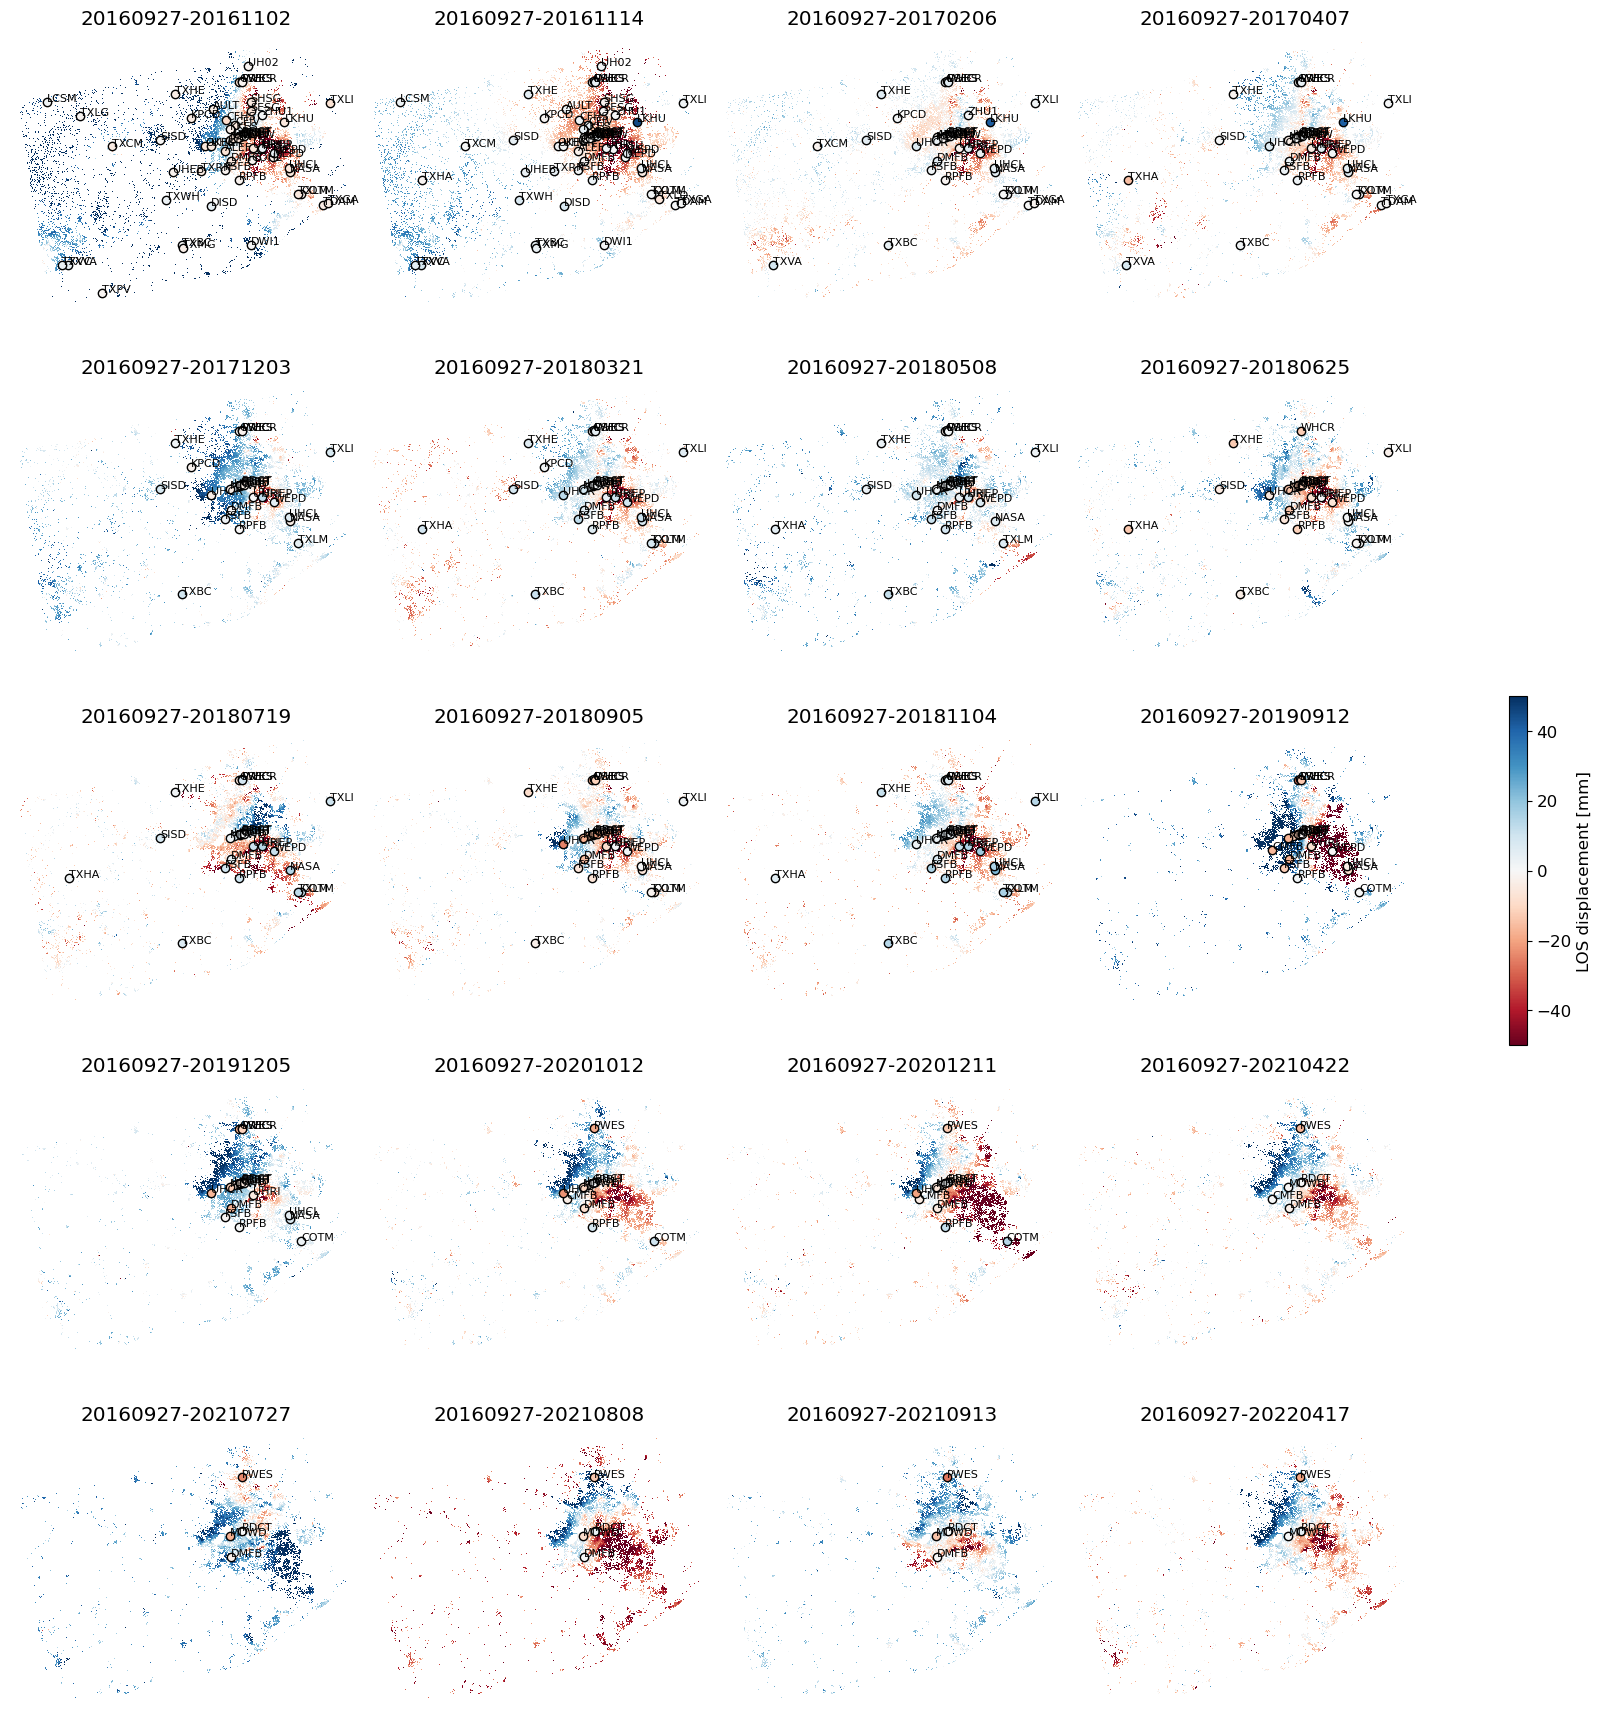

In [22]:
# Plotting only sampled pairs due to a large volume of DISP-S1
cmap = copy.copy(plt.get_cmap('RdBu'))

n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(list(displacement.index.get_level_values(0).unique()),num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = sampled_index[counter]
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=_ind, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
        if apply_nonlinear_mask:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score], cor_ref=ref_disp_s1[_ind])
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr], cor_ref=ref_disp_s1[_ind])

        im = axs[counter].imshow(ifgs_slice, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(DISP_region[2],DISP_region[3],DISP_region[0],DISP_region[1]))
        axs[counter].axis('off')
        axs[counter].set_title(ifgs_date_dt[_ind,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[_ind,1].strftime('%Y%m%d'), pad=-14)

        for stn in displacement.loc[_ind].index:
            _east, _north = displacement.loc[(_ind,stn),'east'],displacement.loc[(_ind,stn),'north']

            color = cmap((displacement.loc[(_ind,stn),'gnss_disp']-vmin)/(vmax-vmin))
            axs[counter].scatter(_east,_north,s=6**2,color=color,edgecolors='k')
            axs[counter].annotate(stn,(_east, _north),color='black', fontsize=8)
    else:
        axs[counter].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

cbar = fig.colorbar(im, ax=axs.tolist(), shrink=0.2)
cbar.set_label('LOS displacement [mm]')

out_fig = f'{output_dir}/Transient_DISP-S1_vs_gnss_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [23]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:
    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    for counter in range(n_pairs):
        fig, ax = plt.subplots(figsize=[12,12])
        _ind = displacement.index.get_level_values(0).unique()[counter]
        ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=_ind, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
        if apply_nonlinear_mask:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score], cor_ref=ref_disp_s1[_ind])
        else:
            ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr], cor_ref=ref_disp_s1[_ind])
        im = ax.imshow(ifgs_slice, cmap=cmap,vmin=vmin,vmax=vmax, interpolation='nearest', extent=(DISP_region[2],DISP_region[3],DISP_region[0],DISP_region[1]))
        ax.axis('off')
        ax.set_title(ifgs_date_dt[_ind,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[_ind,1].strftime('%Y%m%d'), pad=-14)
        
        for stn in displacement.loc[_ind].index:
            _east, _north = displacement.loc[(_ind,stn),'east'],displacement.loc[(_ind,stn),'north']

            color = cmap((displacement.loc[(_ind,stn),'gnss_disp']-vmin)/(vmax-vmin))
            ax.scatter(_east,_north,s=6**2,color=color,edgecolors='k')
            ax.annotate(stn,(_east, _north),color='black', fontsize=8)

        cbar = fig.colorbar(im, shrink=0.2)
        cbar.set_label('LOS displacement [mm]')
        out_fig = f"{output_dir}/Transient_DISP-S1_vs_gnss_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

<a id='transient_validation1'></a>
# NISAR Validation Approach 1: GNSS-DISP-S1 Direct Comparison

<a id='transient_pair1'></a>
## Pair up GNSS stations and make measurement residuals

We first pair up all GNSS stations and compare the relative measurement from both GNSS and DISP-S1. 

In [24]:
disp_s1 = {}
gnss_disp = {}
ddiff_dist = {}
ddiff_disp = {}
abs_ddiff_disp = {}
for i in displacement.index.get_level_values(0).unique():
    displacement_i = displacement.loc[i]
    disp_s1_i = []
    gnss_disp_i = []
    ddiff_dist_i = []
    ddiff_disp_i = []

    gnss_pairs = list(itertools.combinations(displacement_i.index, 2))        # pick two without repeating

    for sta1, sta2 in gnss_pairs:
            disp_s1_i.append(displacement_i.loc[sta1,'disp_s1']-displacement_i.loc[sta2,'disp_s1'])
            gnss_disp_i.append(displacement_i.loc[sta1,'gnss_disp']-displacement_i.loc[sta2,'gnss_disp'])
            ddiff_disp_i.append(gnss_disp_i[-1]-disp_s1_i[-1])

            distance = euclidean_distance(displacement_i.loc[sta1,'east'],displacement_i.loc[sta1,'north'], 
                                          displacement_i.loc[sta2,'east'],displacement_i.loc[sta2,'north'])     # unit: km
            ddiff_dist_i.append(distance)

    disp_s1[i]=np.array(disp_s1_i)
    gnss_disp[i]=np.array(gnss_disp_i)
    ddiff_dist[i]=np.array(ddiff_dist_i)
    ddiff_disp[i]=np.array(ddiff_disp_i)
    abs_ddiff_disp[i]=abs(np.array(ddiff_disp_i))

Plot to compare displacement from GNSS and DISP-S1:

In [25]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    disp_range = (min([*disp_s1[i],*gnss_disp[i]]),max([*disp_s1[i],*gnss_disp[i]]))
    plt.hist(disp_s1[i],bins=100,range=disp_range,color ="green",label='D_DISP-S1')
    plt.hist(gnss_disp[i],bins=100,range=disp_range,color="orange",label='D_GNSS', alpha=0.5)
    plt.legend(loc='upper right')
    date_range = f"{ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}"
    plt.title(f"Displacements \n Date range {date_range} \n Number of station pairs used: {len(disp_s1[i])}")
    plt.xlabel('LOS Displacement (mm)')
    plt.ylabel('Number of Station Pairs')
    plt.savefig(os.path.join(str(output_dir),f'Transient_DISP-S1vsGNSS_hist_site{site}_date{date_range}.png'))
    plt.close()

Plot Displacement Residuals Distribution:

In [26]:
for i in displacement.index.get_level_values(0).unique():
    plt.figure(figsize=(11,7))
    plt.hist(ddiff_disp[i],bins = 100, color="darkblue",linewidth=1,label='D_gnss - D_DISP-S1')
    plt.legend(loc='upper right')
    date_range = f"{ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}"
    plt.title(f"Residuals \n Date range {date_range} \n Number of stations pairs used: {len(ddiff_disp[i])}")
    plt.xlabel('Displacement Residual (mm)')
    plt.ylabel('N Stations')
    plt.savefig(os.path.join(str(output_dir),f'Transient_DISP-S1vsGNSS_hist_residuals_site{site}_date{date_range}.png'))
    plt.close()

Plot Absolute Displacement Residuals As a Function of Distance:

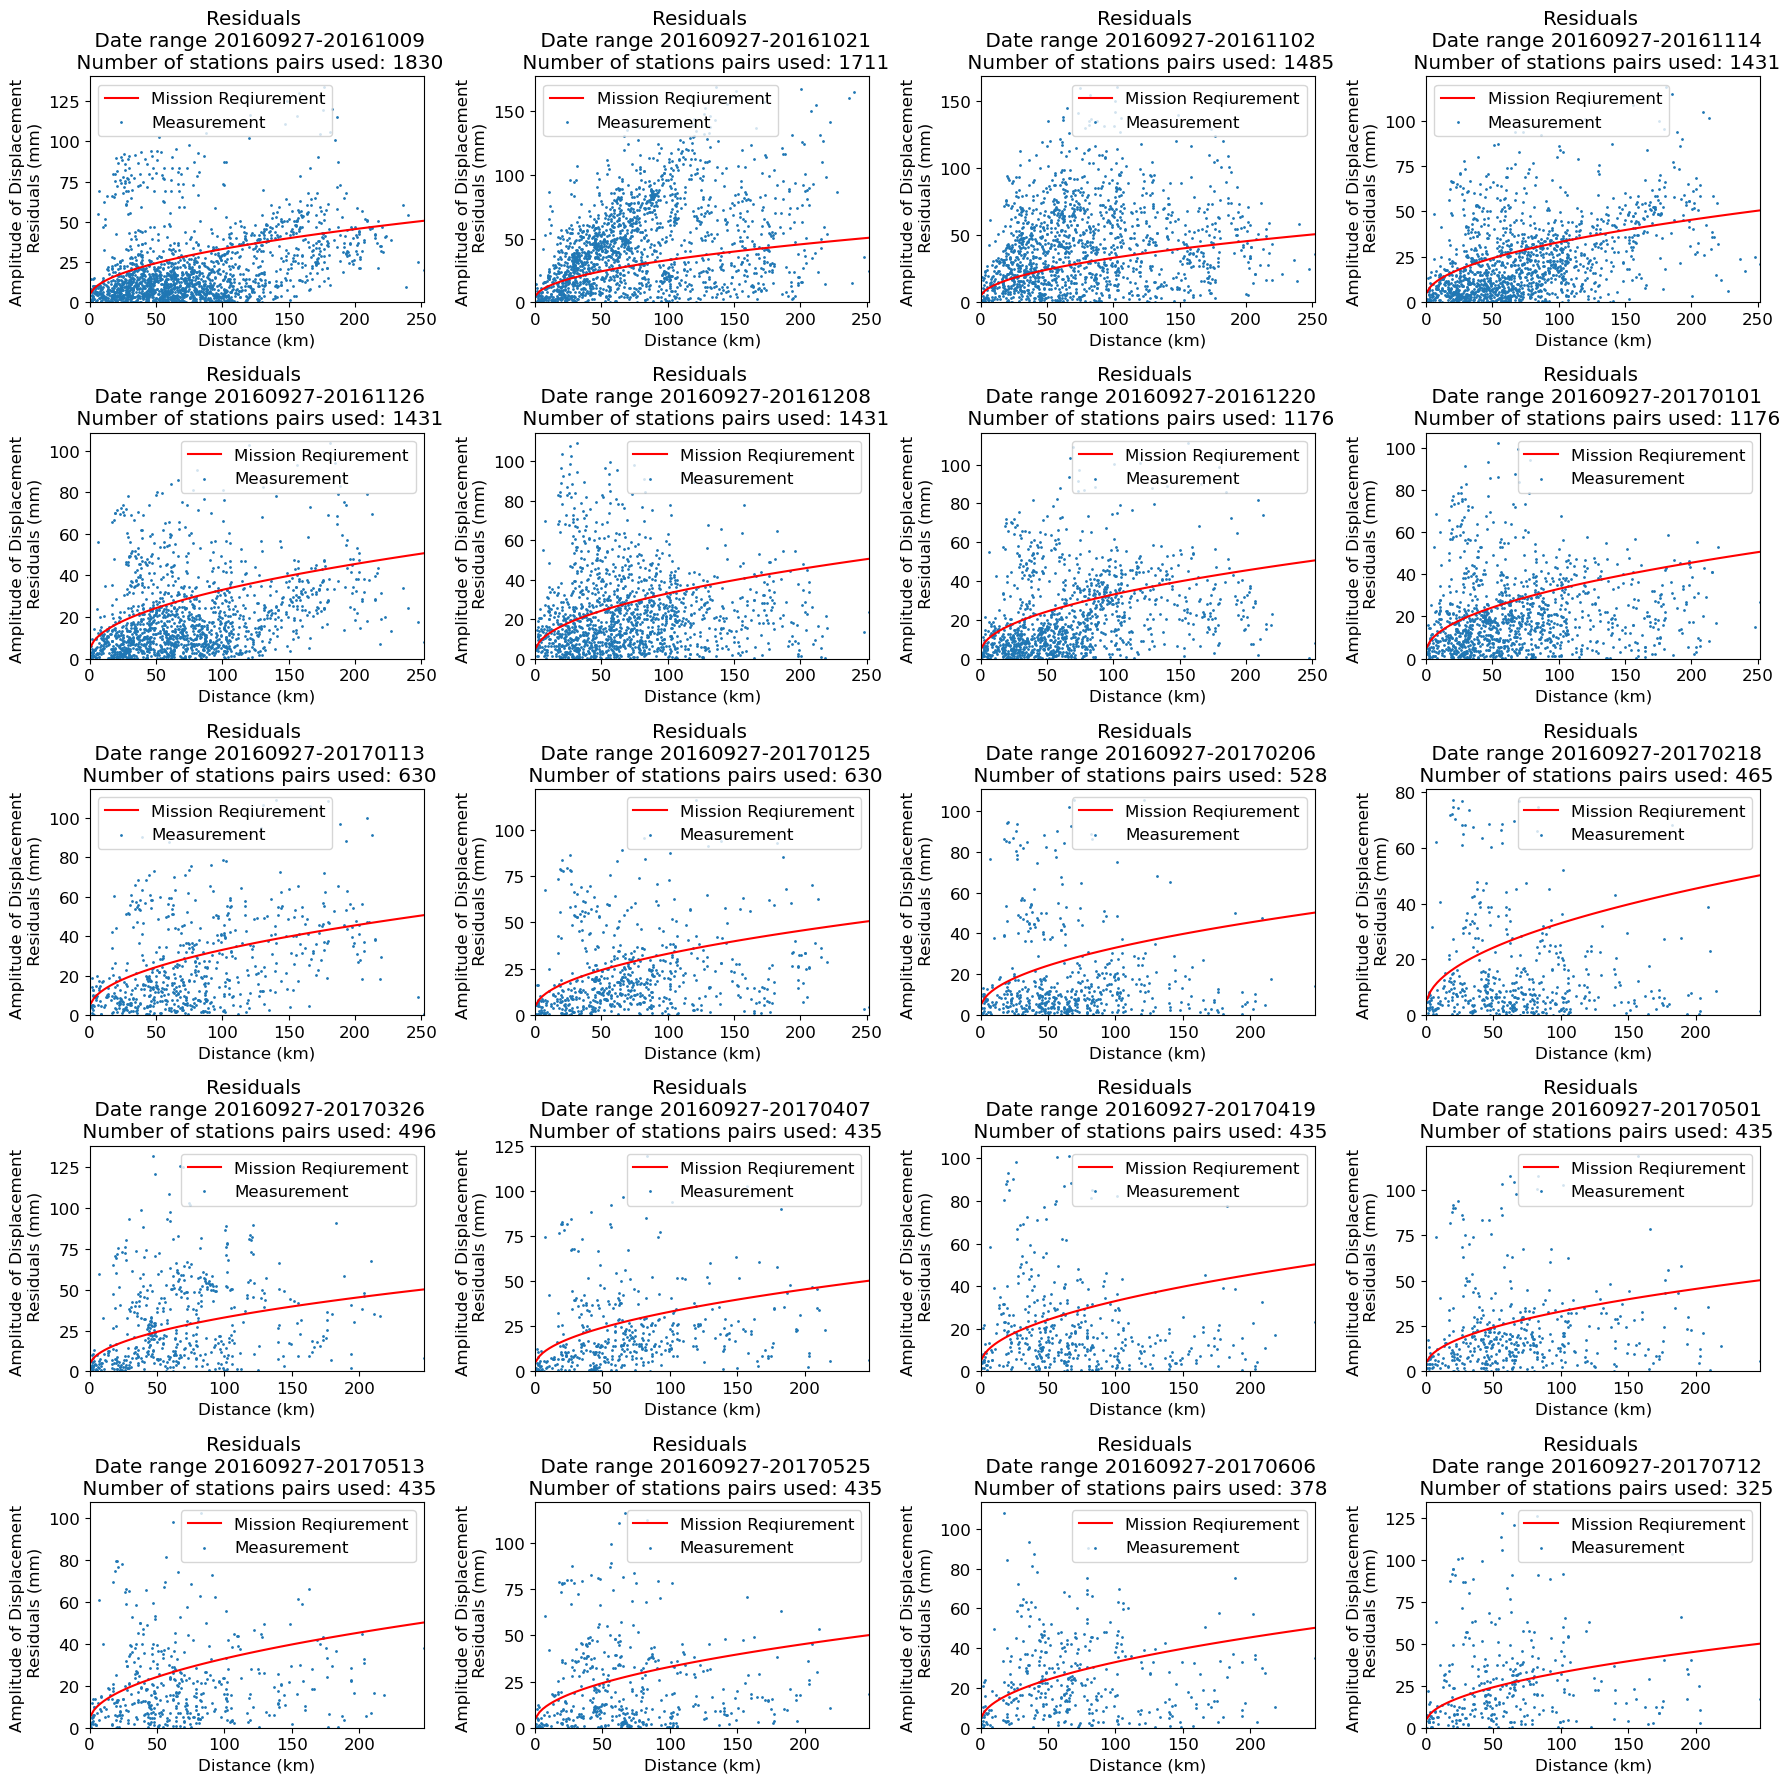

In [27]:
# Plotting only sampled pairs due to a large volume of DISP-S1
n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(list(displacement.index.get_level_values(0).unique()),num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = displacement.index.get_level_values(0).unique()[counter]
        dist_th = np.linspace(min(ddiff_dist[_ind]),max(ddiff_dist[_ind]),100)
        acpt_error = 3*(1+np.sqrt(dist_th))
        axs[counter].plot(dist_th, acpt_error, 'r', label="Mission Reqiurement")
        axs[counter].scatter(ddiff_dist[_ind],abs_ddiff_disp[_ind],s=1, label="Measurement")
        date_range = f"{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}"
        axs[counter].set_xlabel("Distance (km)")
        axs[counter].set_ylabel("Amplitude of Displacement \n Residuals (mm)")
        axs[counter].set_title(f"Residuals \n Date range {date_range}\n Number of stations pairs used: {len(ddiff_dist[_ind])}")
        axs[counter].set_xlim(0,max(ddiff_dist[_ind]))
        axs[counter].set_ylim(ymin=0)
        axs[counter].legend()

    else:
        axs[counter].axis('off')

fig.tight_layout()

out_fig = f'{output_dir}/VA1_transient_Residuals_DISP-S1_gnss_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)


In [28]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:

    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    for counter in range(n_pairs):
        fig, ax = plt.subplots(figsize=[12,12])
        _ind = displacement.index.get_level_values(0).unique()[counter]
        dist_th = np.linspace(min(ddiff_dist[_ind]),max(ddiff_dist[_ind]),100)
        acpt_error = 3*(1+np.sqrt(dist_th))
        ax.plot(dist_th, acpt_error, 'r', label="Mission Reqiurement")
        ax.scatter(ddiff_dist[_ind],abs_ddiff_disp[_ind],s=1, label="Measurement")
        date_range = f"{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}"
        ax.set_xlabel("Distance (km)")
        ax.set_ylabel("Amplitude of Displacement Residuals (mm)")
        ax.set_title(f"Residuals \n Date range {date_range}\n Number of stations pairs used: {len(ddiff_dist[_ind])}")
        ax.set_xlim(0,max(ddiff_dist[_ind]))
        ax.set_ylim(ymin=0)
        ax.legend()

        out_fig = f"{output_dir}/VA1_transient_Residuals_DISP-S1_gnss_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

In [29]:
ddiff_dist_ap1 = list(ddiff_dist.values())
abs_ddiff_disp_ap1 = list(abs_ddiff_disp.values())

We have got all needed data for approach 1:
- `ddiff_dist_ap1`: distance of GNSS pairs,
- `abs_ddiff_disp_ap1`: absolute value of measurement redisuals

<a id='transient_bin1'></a>
## Validate the requirement based on binned measurement residuals

In [30]:
n_ifgs = len(ddiff_dist_ap1)

Bin all measurement residuals to check if they pass the requirements or not:

In [31]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [32]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
for i in range(n_ifgs):
    inds = np.digitize(ddiff_dist_ap1[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(ddiff_dist_ap1[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = abs_ddiff_disp_ap1[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])

In [33]:
ratio = n_pass/n_all
thresthod = 0.683 
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result1'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [34]:
def to_str(x: bool):
    return 'true ' if x else 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in dates_index_gnss:
    index.append(ifgs_date_dt[i,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

Number of data points in each bin:

In [35]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160927-20161009         31          38           43           66   
20160927-20161021         30          35           43           57   
20160927-20161102         27          27           34           52   
20160927-20161114         29          33           34           49   
20160927-20161126         29          33           34           49   
...                      ...         ...          ...          ...   
20160927-20220417          0           0            1            0   
20160927-20220429          0           0            1            0   
20160927-20220511          0           0            1            0   
20160927-20220523          0           0            1            0   
20160927-20220604          0           0            1            0   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160927-20161009           75           92           87           77   
20160927-20161021           70           88           81           73   
20160927-20161102           65           76           72           69   
20160927-20161114           52           72           68           63   
20160927-20161126           52           72           68           63   
...                        ...          ...          ...          ...   
20160927-20220417            0            0            0            0   
20160927-20220429            0            0            0            0   
20160927-20220511            0            0            0            0   
20160927-20220523            0            0            0            0   
20160927-20220604            0            0            0            0   

                   40.02-45.01  45.01-50.00  total  
20160927-20161009           77           76    586  
20160927-20161021           72           71    549  
20160927-20161102           62           66    484  
20160927-20161114           62           63    462  
20160927-20161126           62           63    462  
...                        ...          ...    ...  
20160927-20220417            1            1      2  
20160927-20220429            1            1      2  
20160927-20220511            1            1      2  
20160927-20220523            1            1      2  
20160927-20220604            1            1      2  

[149 rows x 11 columns]

Number of data points that below the curve:

In [36]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160927-20161009         22          32           30           49   
20160927-20161021         22          22           18           33   
20160927-20161102         14          12           12           19   
20160927-20161114         21          27           23           34   
20160927-20161126         25          25           31           37   
...                      ...         ...          ...          ...   
20160927-20220417          0           0            0            0   
20160927-20220429          0           0            0            0   
20160927-20220511          0           0            0            0   
20160927-20220523          0           0            0            0   
20160927-20220604          0           0            0            0   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160927-20161009           57           66           63           50   
20160927-20161021           38           24           23           28   
20160927-20161102           24           20           22           22   
20160927-20161114           43           55           46           32   
20160927-20161126           44           52           46           37   
...                        ...          ...          ...          ...   
20160927-20220417            0            0            0            0   
20160927-20220429            0            0            0            0   
20160927-20220511            0            0            0            0   
20160927-20220523            0            0            0            0   
20160927-20220604            0            0            0            0   

                   40.02-45.01  45.01-50.00  total  
20160927-20161009           67           62    436  
20160927-20161021           22           11    230  
20160927-20161102           29           28    174  
20160927-20161114           44           51    325  
20160927-20161126           48           48    345  
...                        ...          ...    ...  
20160927-20220417            0            0      0  
20160927-20220429            1            1      1  
20160927-20220511            0            0      0  
20160927-20220523            0            0      0  
20160927-20220604            0            0      0  

[149 rows x 11 columns]

Percentage of pass:

In [37]:
ratio_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160927-20161009   0.709677    0.842105     0.697674     0.742424   
20160927-20161021   0.733333    0.628571     0.418605     0.578947   
20160927-20161102   0.518519    0.444444     0.352941     0.365385   
20160927-20161114   0.724138    0.818182     0.676471     0.693878   
20160927-20161126   0.862069    0.757576     0.911765     0.755102   
...                      ...         ...          ...          ...   
20160927-20220417        NaN         NaN     0.000000          NaN   
20160927-20220429        NaN         NaN     0.000000          NaN   
20160927-20220511        NaN         NaN     0.000000          NaN   
20160927-20220523        NaN         NaN     0.000000          NaN   
20160927-20220604        NaN         NaN     0.000000          NaN   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160927-20161009     0.760000     0.717391     0.724138     0.649351   
20160927-20161021     0.542857     0.272727     0.283951     0.383562   
20160927-20161102     0.369231     0.263158     0.305556     0.318841   
20160927-20161114     0.826923     0.763889     0.676471     0.507937   
20160927-20161126     0.846154     0.722222     0.676471     0.587302   
...                        ...          ...          ...          ...   
20160927-20220417          NaN          NaN          NaN          NaN   
20160927-20220429          NaN          NaN          NaN          NaN   
20160927-20220511          NaN          NaN          NaN          NaN   
20160927-20220523          NaN          NaN          NaN          NaN   
20160927-20220604          NaN          NaN          NaN          NaN   

                   40.02-45.01  45.01-50.00     total  
20160927-20161009     0.870130     0.815789  0.744027  
20160927-20161021     0.305556     0.154930  0.418944  
20160927-20161102     0.467742     0.424242  0.359504  
20160927-20161114     0.709677     0.809524  0.703463  
20160927-20161126     0.774194     0.761905  0.746753  
...                        ...          ...       ...  
20160927-20220417     0.000000     0.000000  0.000000  
20160927-20220429     1.000000     1.000000  0.500000  
20160927-20220511     0.000000     0.000000  0.000000  
20160927-20220523     0.000000     0.000000  0.000000  
20160927-20220604     0.000000     0.000000  0.000000  

[149 rows x 11 columns]

In [38]:
df_ratio = ratio_pd.copy()
df_success = success_or_fail_pd.copy()
s = None

In [39]:
# Assuming your dataframe is called 'df'
s = df_ratio.style.format(precision=3)

# Format the index (date ranges) for better readability
df_ratio.index = df_ratio.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_ratio.index.name = "Date range"
df_ratio.columns = [f"{col} km" if col != "total" else col for col in df_ratio.columns]     # Add units to column headers

df_success.index = df_success.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_success.index.name = "Date range"
df_success.columns = [f"{col} km" if col != "total" else col for col in df_success.columns] 

# Set table styles
s.set_table_styles([
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle; border: 1px solid black;'},
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.25em; font-weight: bold; background-color: #f2f2f2; padding: 8px;'},
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle;'},
    {'selector': 'table', 'props': 'border-collapse: collapse;'},
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
    {'selector': f'td:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': '.index_name', 'props': 'font-weight: bold; font-size: 1.1em; text-align: center;'},
    {'selector': 'tr:first-child', 'props': 'border-top: none;'},
    {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    {'selector': 'td:first-child, th:first-child', 'props': 'border-left: none;'},
    {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'},
])

s.set_td_classes(df_success)

# Set caption
s.set_caption("Distance")

s.set_properties(**{'text-align': 'center'})

# Display the styled table
s

In [40]:
ratio_pd.to_csv(f'{output_dir}/VA1_transient_DISP-S1-gnss_distance_table_site{site}.csv')

html = s.to_html()

html_filename = f'{output_dir}/VA1_transient_DISP-S1-gnss_distance_table_site{site}.html'
with open(html_filename, "w") as f:
    f.write(html)

<a id='transient_conclusion1'></a>
## Conclusion

In [41]:
percentage = np.count_nonzero(ratio_pd['total']>thresthod)/n_ifgs
print(f"Percentage of DISP-S1s passes the requirement: {percentage}")
if percentage >= 0.70:
    print('The DISP-S1 stack passes the requirement.')
else:
    print('The DISP-S1 stack fails the requirement.')

Percentage of DISP-S1s passes the requirement: 0.1476510067114094
The DISP-S1 stack fails the requirement.


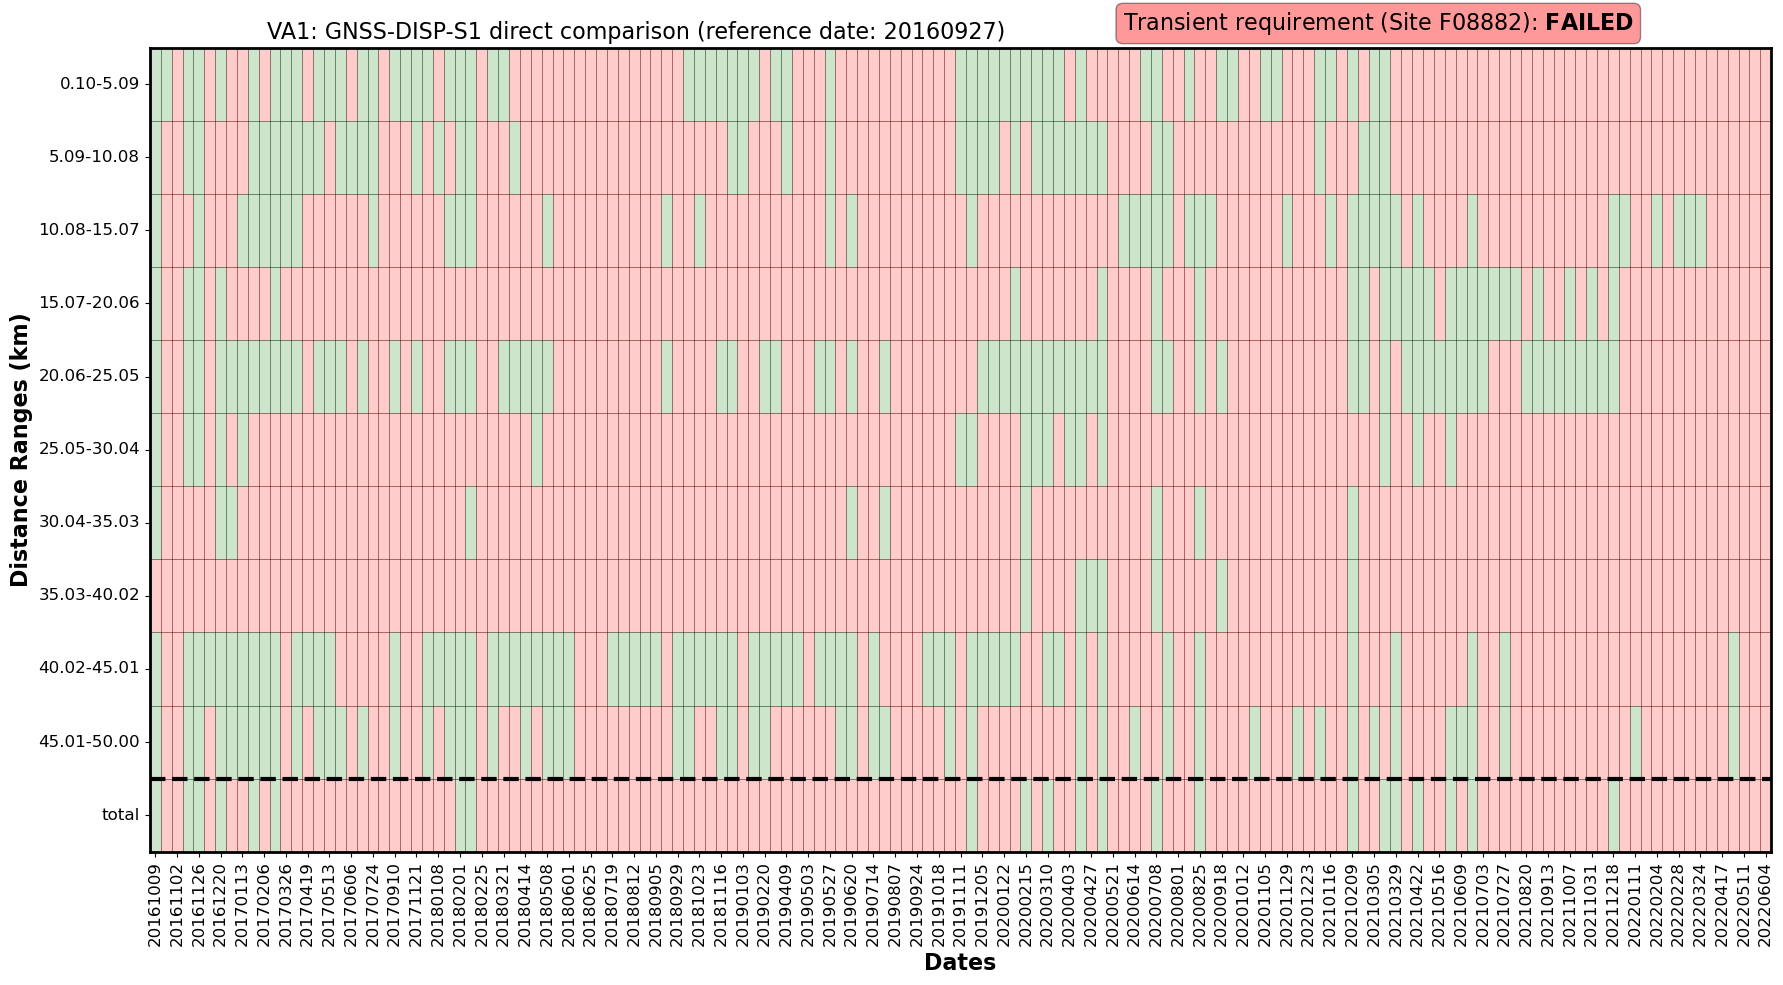

In [42]:
# output figure for displaying a validation result
reference_date = ifgs_date_dt[0,0].strftime('%Y%m%d') 
title_text = f'VA1: GNSS-DISP-S1 direct comparison (reference date: {reference_date})'
out_fig = f'{output_dir}/VA1_result_Transient_DISP-S1_vs_gnss_site{site}.png'
plot_transient_table(ratio_pd, site, percentage, thresthod, title_text, out_fig, annot=False) # generate a figure (annot=True means each cell has a value. Not recommended for large datasets)

<div class="alert alert-warning">
Approach 1 final result for CentralValleyA144: around 79% of DISP-S1s passes the requirement.
</div>

<a id='transient_validation2'></a>
# NISAR Validation Approach 2: Noise Level Validation

In this validation (Approach #2), we evaluate the estimated secular deformation rate (Requirements 658) or co-seismic displacement (Requirement 660) from time series processing or the individual DISP-S1 (Requirement 663) over selected cal/val areas with negligible deformation. Any estimated deformation should thus be treated as noise and our goal is to evaluate the significance of this noise. In general, noise in the modeled displacement or the unwrapped DISP-S1 is anisotropic, but here we neglect this anisotropy. Also, we assume the noise is stationary.

We first randomly sample measurements and pair up sampled pixel measurements. For each pixel-pair, the difference of their measurement becomes:
$$d\left(r\right)=|(f\left(x\right)-f\left(x-r\right))|$$
Estimates of $d(r)$ from all pairs are binned according to the distance r. In each bin, $d(r)$ is assumed to be a normal distribution.

**Note:** Now we simply assume there is no deformation in this study area and time interval. But in fact, it is hard to find a enough large area without any deformation. An more realistic solution is to apply a mask to mask out deformed regions.

<a id='transient_pair2'></a>
## Randomly sample pixels and pair them up

Calculate the coordinate for every pixel:

In [43]:
X0,Y0 = load_geo_utm(disp_S1_metadata)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

For each DISP-S1, randomly selected pixels need to be paired up. In order to keep measurements independent, different pixel pairs can not share same pixel. This is achieved by pairing up in sequence, i.e., pairing up pixel number 1 and number 2, 3 and 4...

In [44]:
dist = {}; rel_measure = {}
for i in dates_index:
    ifgs_slice = read_ifgram_hdf(ifgs_file, keyword='unwrapPhase', channel=i, coh_thr=minCoherence_parm) * phase2range*1000    # unit in mm   
    if apply_nonlinear_mask:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr, mask_var_score])
    else:
        ifgs_slice = slice_mask(ifgs_slice, mask=[mask_lyr])

    dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,ifgs_slice,num_samples=1000000)
    dist[i] = dist_i / 1000     # unit: km
    rel_measure[i] = rel_measure_i

Show the statistical property of selected pixel pairs:

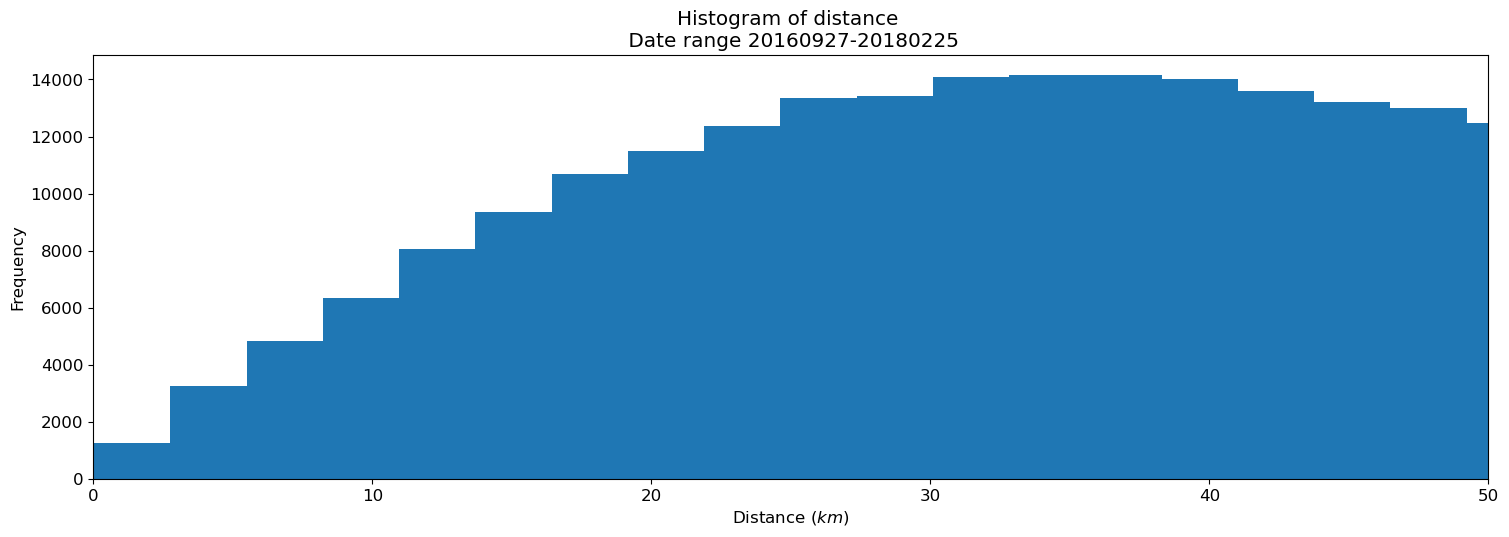

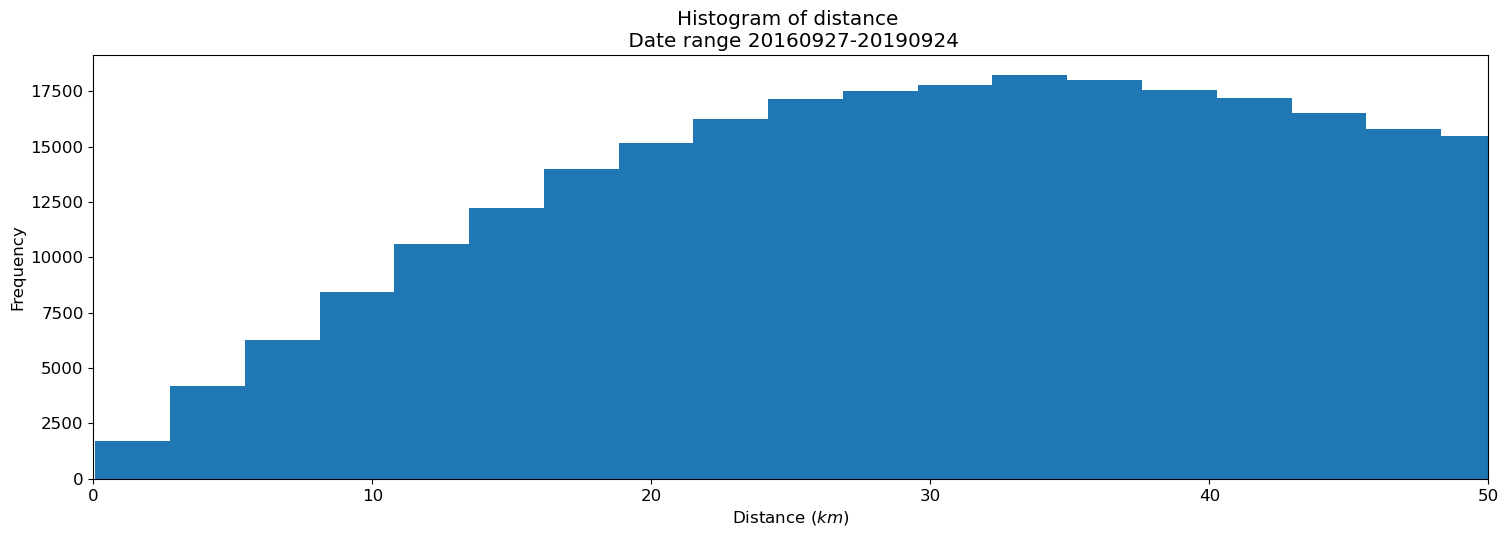

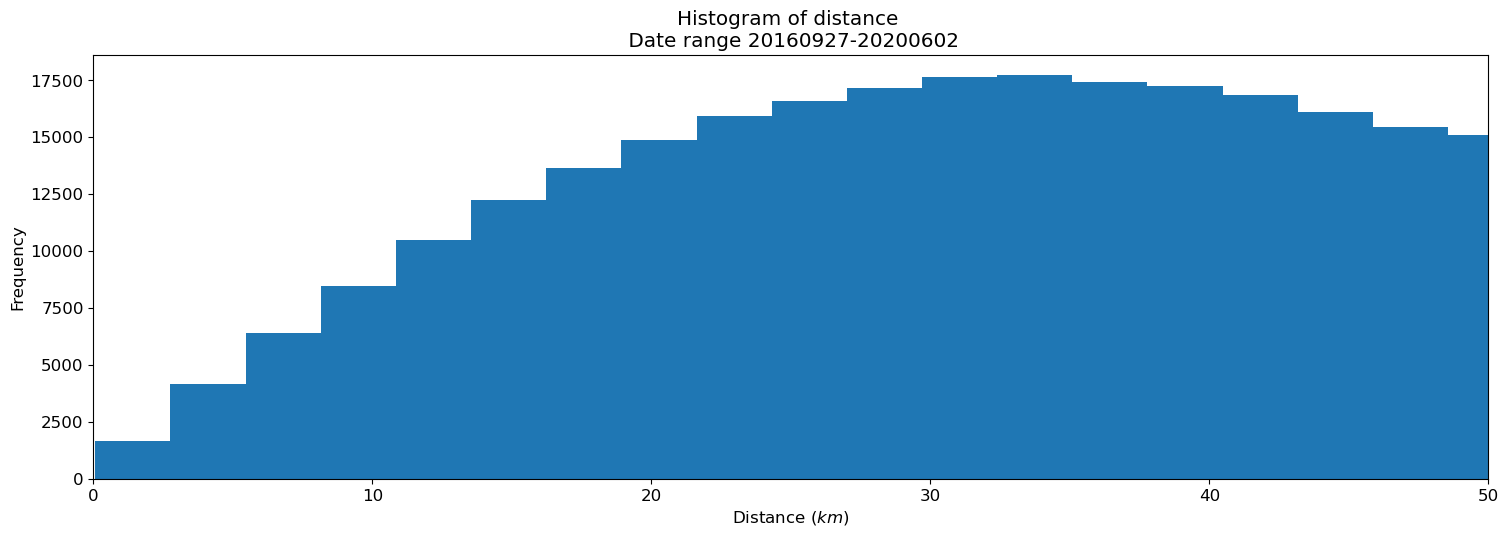

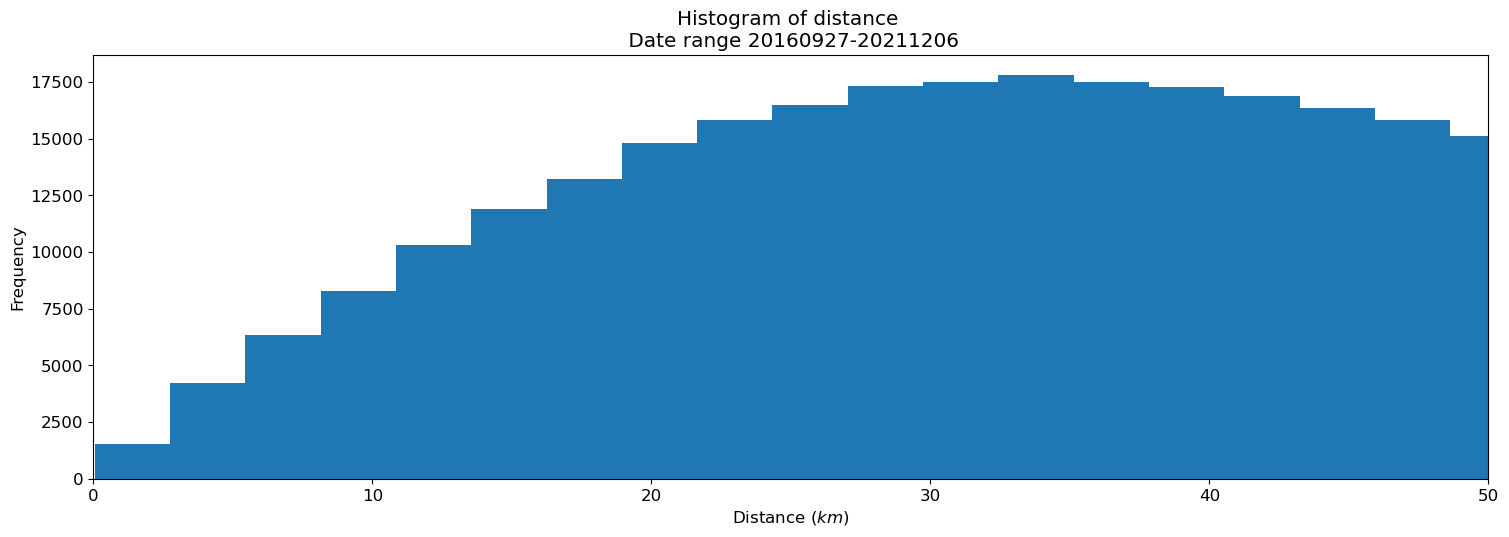

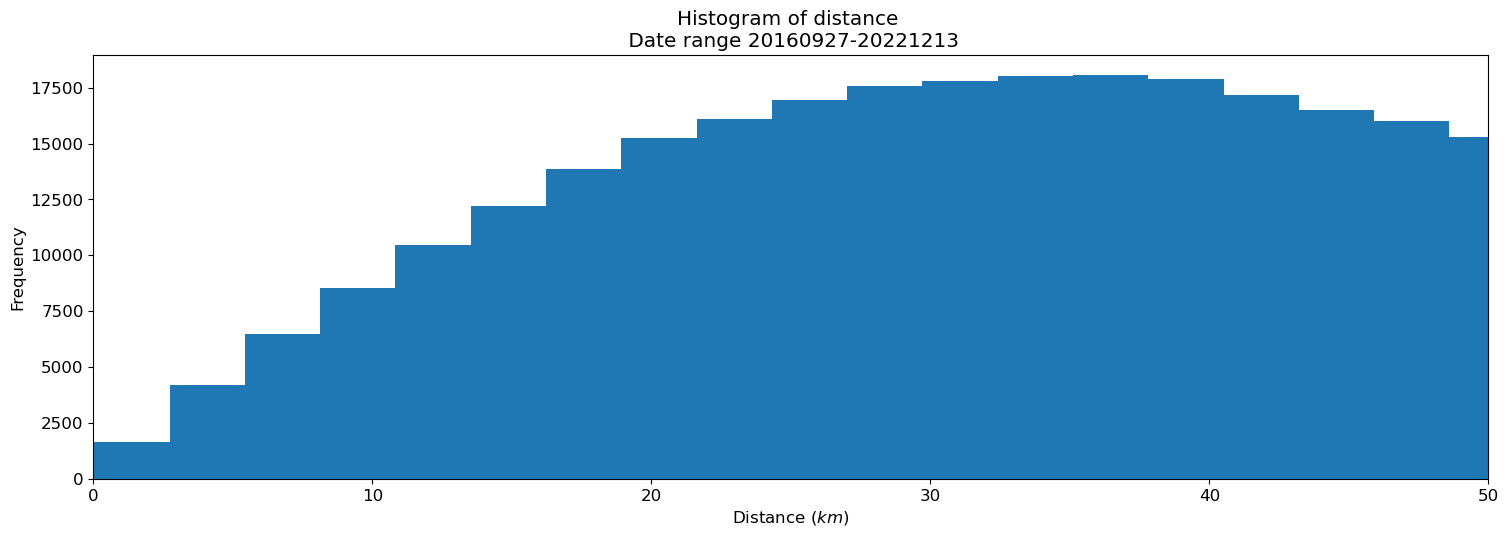

In [45]:
num_figs = 5  

sampled_index = sorted(random.sample(dates_index,num_figs))

for i in sampled_index:
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(dist[i], bins=100)
    ax.set_title(f"Histogram of distance \n Date range {ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Distance ($km$)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0,50)

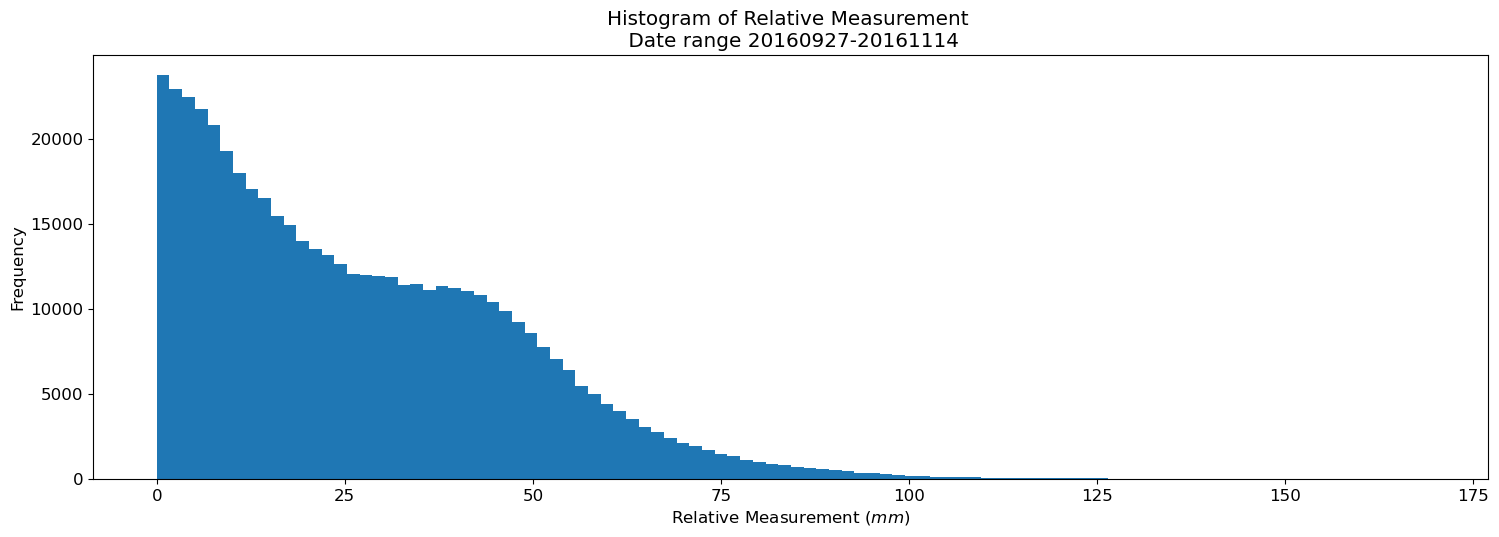

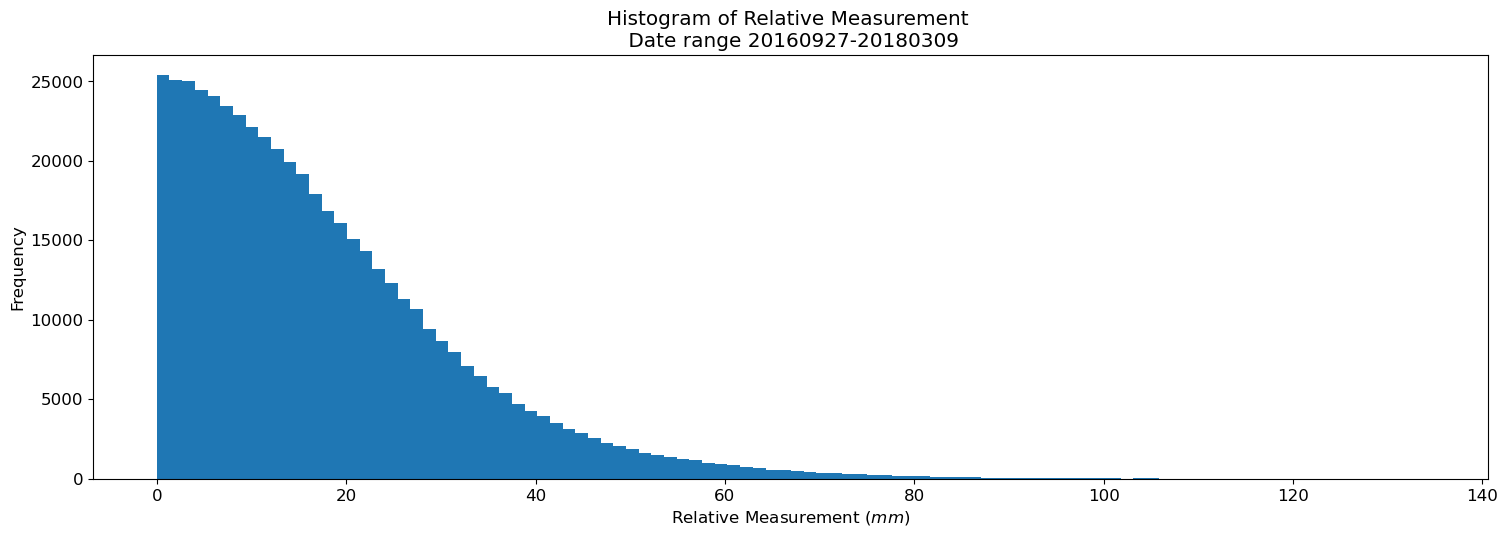

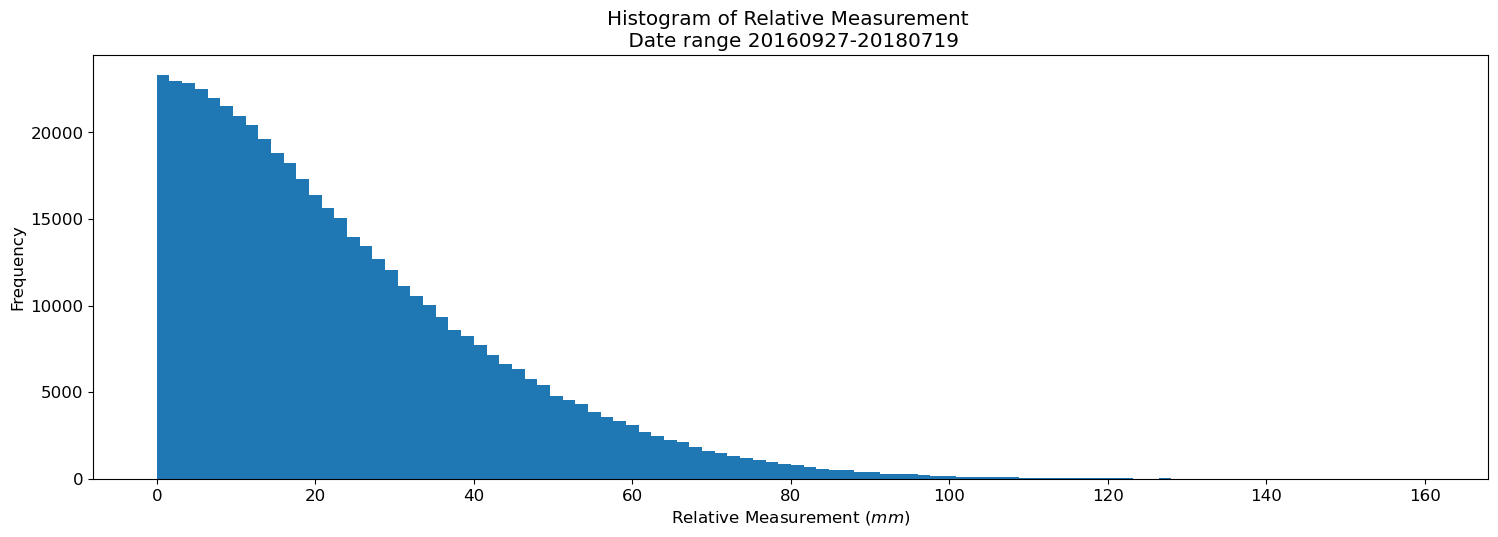

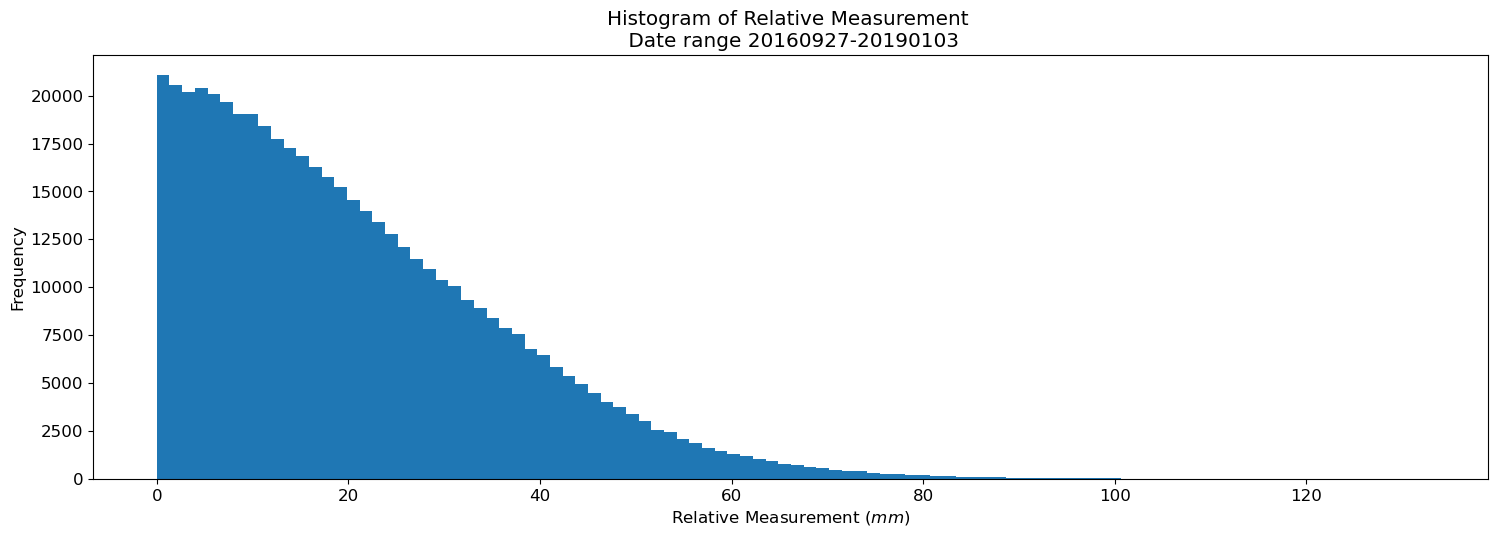

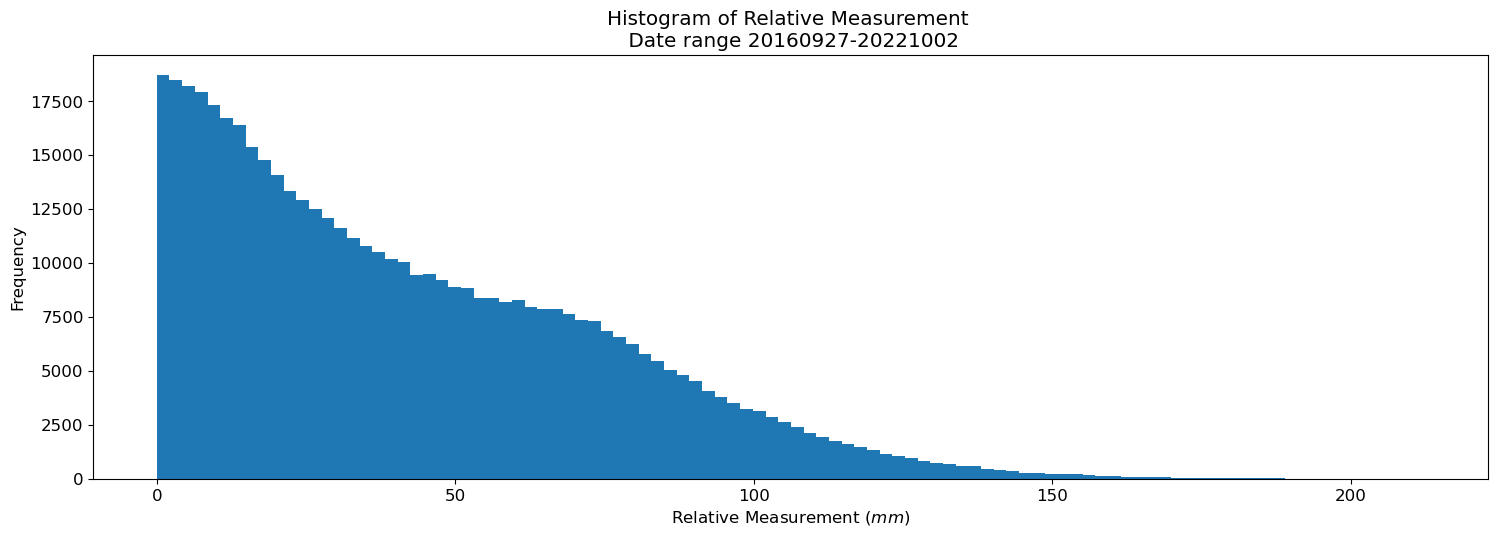

In [46]:
num_figs = 5  

sampled_index = sorted(random.sample(dates_index,num_figs))

for i in sampled_index:
    fig, ax = plt.subplots(figsize=[18, 5.5])
    img1 = ax.hist(rel_measure[i], bins=100)
    ax.set_title(f"Histogram of Relative Measurement \n Date range {ifgs_date_dt[i,0].strftime('%Y%m%d')}-{ifgs_date_dt[i,1].strftime('%Y%m%d')}")
    ax.set_xlabel(r'Relative Measurement ($mm$)')
    ax.set_ylabel('Frequency')

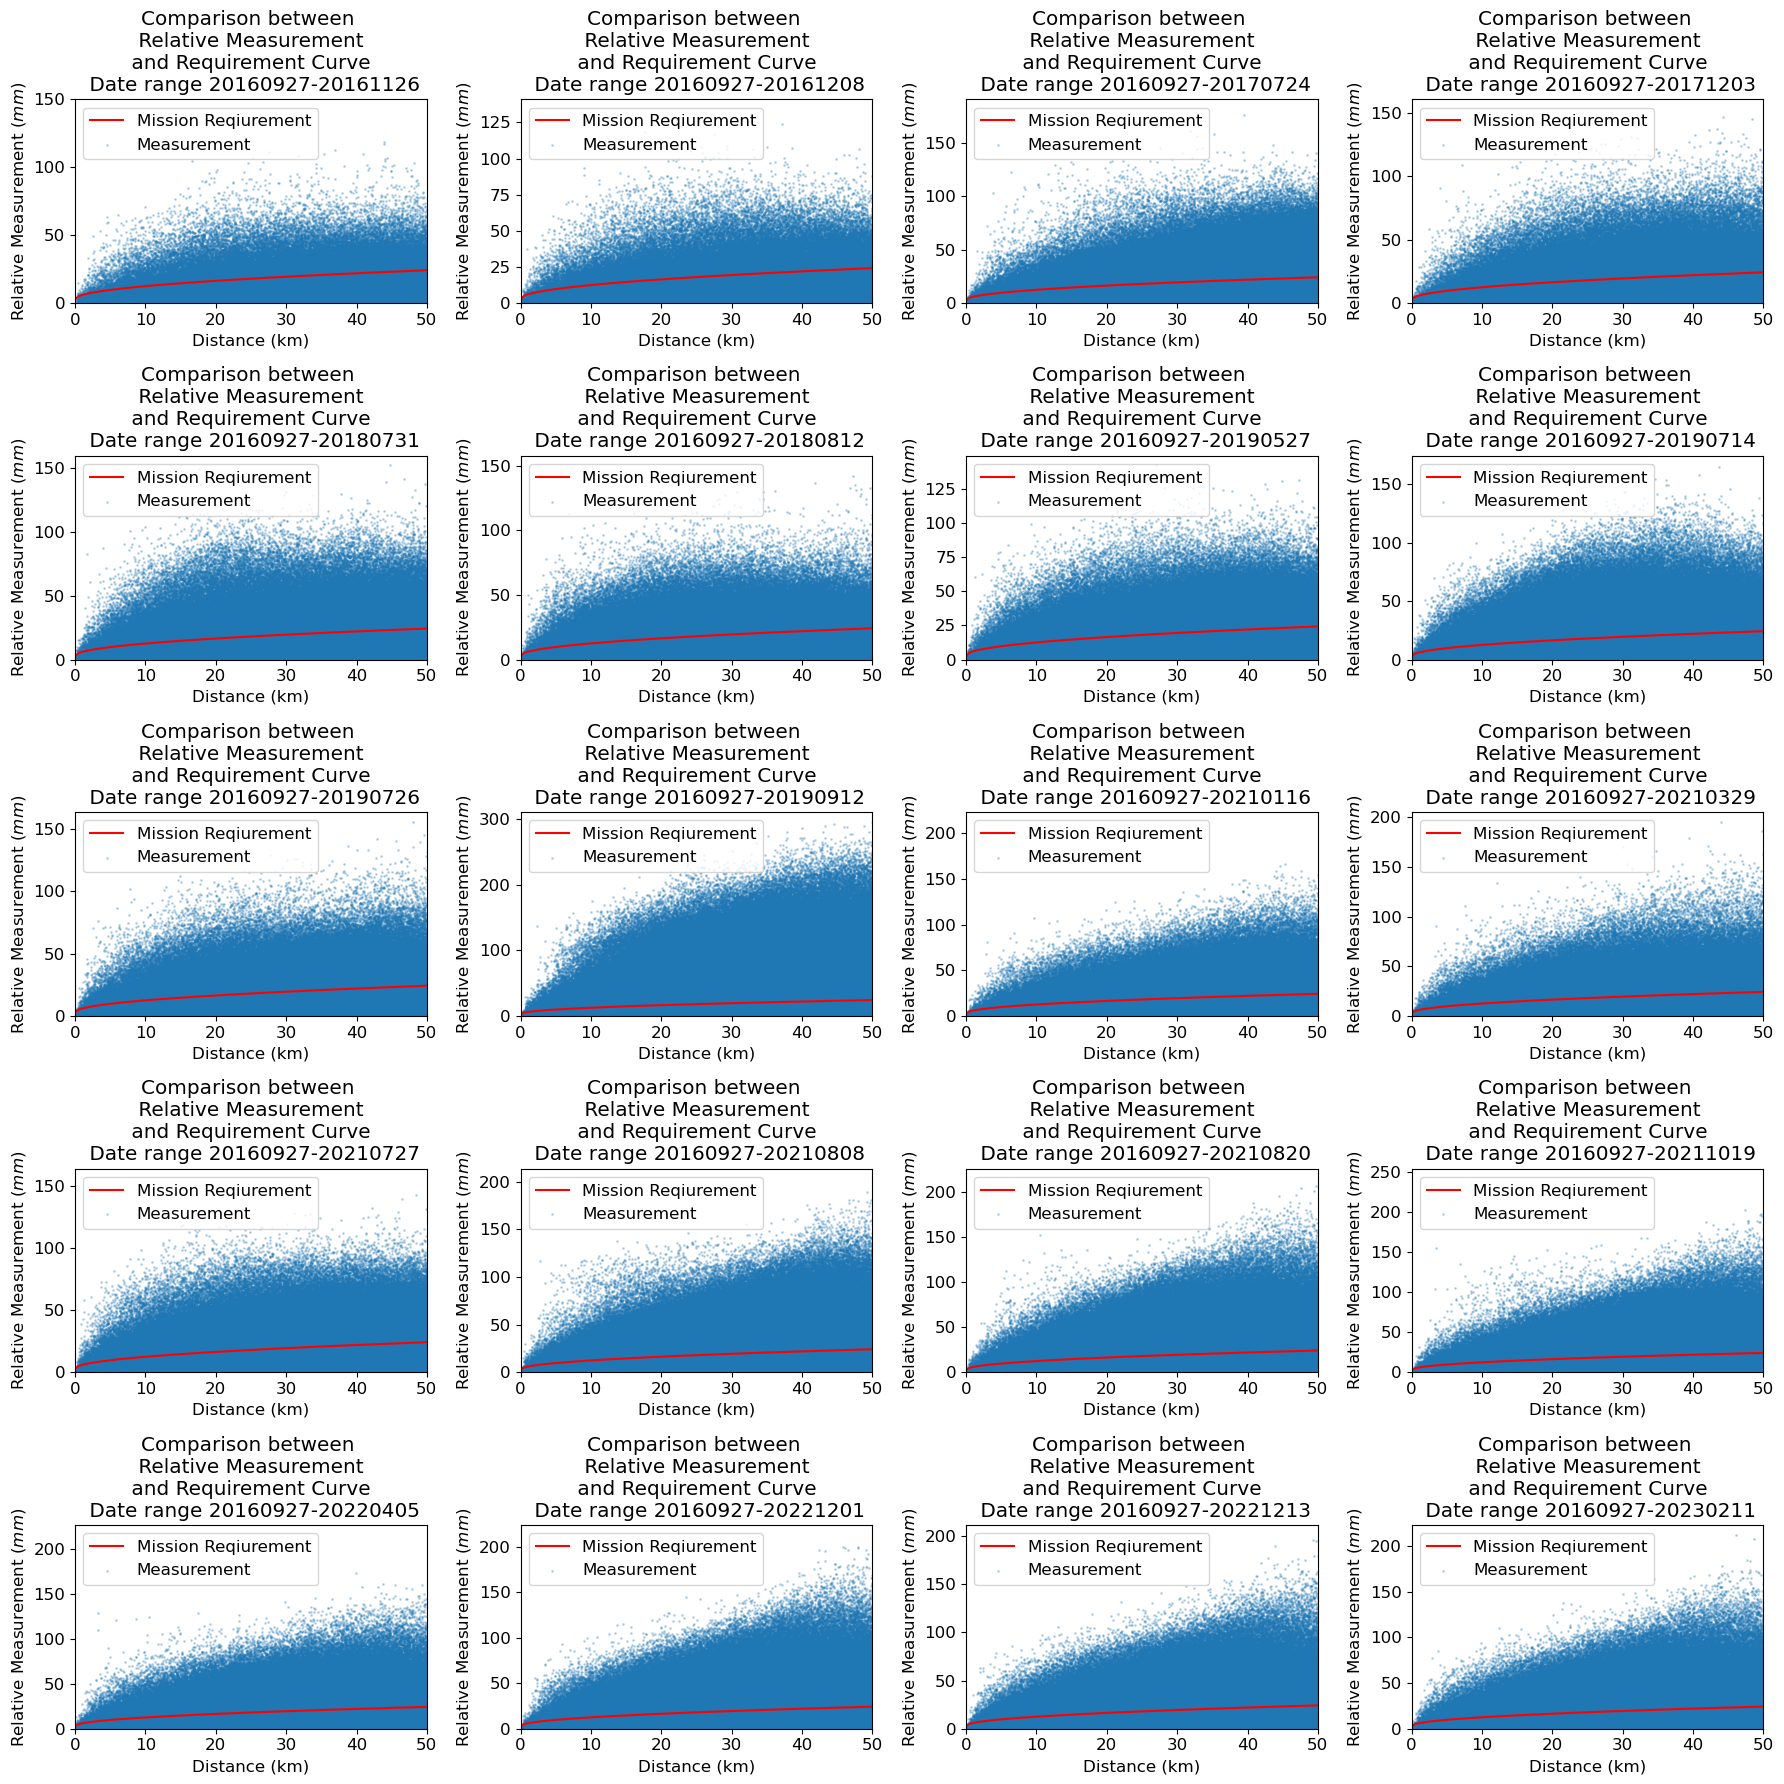

In [47]:
# Plotting only sampled pairs due to a large volume of DISP-S1
n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

col_figs = 4    # number of colums in figures
num_pairs_to_plot = 20

if num_pairs_to_plot > n_pairs:
    num_pairs_to_plot = n_pairs

num_figs = int(np.ceil(num_pairs_to_plot/col_figs)) * col_figs

sampled_index = sorted(random.sample(dates_index,num_pairs_to_plot))

fig, ax = plt.subplots(int(np.ceil(num_pairs_to_plot/col_figs)), col_figs, figsize=[18, 18])
axs = ax.ravel()

dist_th = np.linspace(0,50,100)
rqmt = 3*(1+np.sqrt(dist_th))

for counter in range(num_figs):
    if (counter<n_pairs):
        _ind = sampled_index[counter]
        axs[counter].plot(dist_th, rqmt, 'r', label="Mission Reqiurement")
        axs[counter].scatter(dist[_ind], rel_measure[_ind], s=1, alpha=0.25, label="Measurement")
        axs[counter].set_title(f"Comparison between \n Relative Measurement \n and Requirement Curve \n Date range {ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}")
        axs[counter].set_ylabel(r'Relative Measurement ($mm$)')
        axs[counter].set_xlabel('Distance (km)')
        axs[counter].set_xlim(0,50)
        axs[counter].set_ylim(ymin=0)
        axs[counter].legend()
    else:
        axs[counter].axis('off')

fig.tight_layout()

out_fig = f'{output_dir}/VA2_transient_relative_DISP-S1_measurements_randomSelected_site{site}.png'
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [48]:
separate_figure_flag = False     # if plotting separate figures is needed

if separate_figure_flag:

    cmap = copy.copy(plt.get_cmap('RdBu'))

    n_pairs = len(displacement.index.get_level_values(0).unique())  # number of sub-figures

    dist_th = np.linspace(0,50,100)
    rqmt = 3*(1+np.sqrt(dist_th))

    for counter in range(n_pairs):

        fig, ax = plt.subplots(figsize=[12,12])
        _ind = dates_index[counter]
        ax.plot(dist_th, rqmt, 'r', label="Mission Reqiurement")
        ax.scatter(dist[_ind], rel_measure[_ind], s=1, alpha=0.25, label="Measurement")
        ax.set_title(f"Comparison between \n Relative Measurement \n and Requirement Curve \n Date range {ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}")
        ax.set_ylabel(r'Relative Measurement ($mm$)')
        ax.set_xlabel('Distance (km)')
        ax.set_xlim(0,50)
        ax.set_ylim(ymin=0)

        out_fig = f"{output_dir}/VA2_transient_relative_DISP-S1_measurements_site{site}_date{ifgs_date_dt[_ind,0].strftime('%Y%m%d')}-{ifgs_date_dt[_ind,1].strftime('%Y%m%d')}.png"
        fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
        plt.close()

We have got data used of approach 2:
- `dist`: distance of pixel pairs,
- `rel_measure`: relative measurement of pixel pairs,

<a id='transient_bin2'></a>
## Validate the requirement based on binned measurement residuals

In [49]:
n_ifgs = len(dist)

Bin all measurement residuals to check if they pass the requirements or not:

In [50]:
n_bins = 10
bins = np.linspace(0.1,50.0,num=n_bins+1)

In [51]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass

for counter, i in enumerate(dates_index):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 3*(1+np.sqrt(dist[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = rel_measure[i][inds==j] # relative measurement
        assert len(rqmt) == len(rem)
        n_all[counter,j-1] = len(rem)
        n_pass[counter,j-1] = np.count_nonzero(rem<rqmt)
    n_all[counter,-1] = np.sum(n_all[counter,0:-2])
    n_pass[counter,-1] = np.sum(n_pass[counter,0:-2])

In [52]:
ratio = n_pass/n_all
mean_ratio = np.array([np.mean(ratio[:,:-1],axis=1)])
ratio = np.hstack((ratio,mean_ratio.T))
thresthod = 0.683
#The assumed nature of Gaussian distribution gives a probability of 0.683 of being within one standard deviation.
success_or_fail = ratio>thresthod

<a id='transient_result2'></a>
## Result visualization

Convert the result to pandas DataFrame for better visulization:

In [53]:
def to_str(x: bool):
    return 'true ' if x else 'false '

success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in dates_index:
    index.append(ifgs_date_dt[i,0].strftime('%Y%m%d')+'-'+ifgs_date_dt[i,1].strftime('%Y%m%d'))

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns+['mean'],index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns+['mean'],index=index)

Number of data points in each bin:

In [54]:
n_all_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160927-20161009       2707        6761        10286        13436   
20160927-20161021       2838        7129        10751        13580   
20160927-20161102       3032        7614        11472        15112   
20160927-20161114       2839        7106        10937        13972   
20160927-20161126       2879        7208        10985        14042   
...                      ...         ...          ...          ...   
20160927-20230530       5276       13359        20502        26229   
20160927-20230611       5443       13518        20865        26383   
20160927-20230623       5590       13896        21369        27374   
20160927-20230705       5566       14244        21361        27158   
20160927-20230717       5760       14349        21864        27634   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160927-20161009        15985        17500        18823        19057   
20160927-20161021        16245        18060        19345        19730   
20160927-20161102        17220        19340        20471        20890   
20160927-20161114        16459        18158        19373        19716   
20160927-20161126        16508        18337        19413        20004   
...                        ...          ...          ...          ...   
20160927-20230530        29941        32781        34200        33145   
20160927-20230611        30639        33029        34283        33886   
20160927-20230623        31059        33935        35066        34247   
20160927-20230705        31651        34015        35035        34616   
20160927-20230717        32174        34495        35975        34832   

                   40.02-45.01  45.01-50.00   total  
20160927-20161009        19571        19134  124126  
20160927-20161021        19531        19540  127209  
20160927-20161102        20208        19568  135359  
20160927-20161114        19796        19503  128356  
20160927-20161126        19979        19771  129355  
...                        ...          ...     ...  
20160927-20230530        31629        29250  227062  
20160927-20230611        31879        29754  229925  
20160927-20230623        31946        29614  234482  
20160927-20230705        31999        30187  235645  
20160927-20230717        32722        30415  239805  

[181 rows x 11 columns]

Number of data points that below the curve:

In [55]:
n_pass_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160927-20161009       2114        4997         7402         9496   
20160927-20161021       2036        4660         6306         7341   
20160927-20161102       1888        4029         5388         6671   
20160927-20161114       2277        5413         8068        10180   
20160927-20161126       2247        5322         8047        10051   
...                      ...         ...          ...          ...   
20160927-20230530       2480        4695         5889         6556   
20160927-20230611       2678        5232         7196         8305   
20160927-20230623       2959        6577         9351        10995   
20160927-20230705       2396        5125         7215         8362   
20160927-20230717       2342        4255         6075         8319   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160927-20161009        11220        12066        12876        13078   
20160927-20161021         7884         8129         7703         6943   
20160927-20161102         7259         7524         7523         7745   
20160927-20161114        12064        13336        14378        14700   
20160927-20161126        11823        13170        13671        14248   
...                        ...          ...          ...          ...   
20160927-20230530         6998         7062         7478         7940   
20160927-20230611         8903         9066         8970         9434   
20160927-20230623        11959        12353        12848        12960   
20160927-20230705         8579         7911         7186         6756   
20160927-20230717        10379        11256        11711        12628   

                   40.02-45.01  45.01-50.00  total  
20160927-20161009        13730        13720  86979  
20160927-20161021         6342         5551  57344  
20160927-20161102         7348         7423  55375  
20160927-20161114        14860        14744  95276  
20160927-20161126        14092        14317  92671  
...                        ...          ...    ...  
20160927-20230530         8168         7907  57266  
20160927-20230611         9910        10096  69694  
20160927-20230623        13047        12542  93049  
20160927-20230705         6967         7065  60497  
20160927-20230717        12911        12333  79876  

[181 rows x 11 columns]

Ratio of pass:

In [56]:
ratio_pd

0.10-5.09  5.09-10.08  10.08-15.07  15.07-20.06  \
20160927-20161009   0.780938    0.739092     0.719619     0.706758   
20160927-20161021   0.717407    0.653668     0.586550     0.540574   
20160927-20161102   0.622691    0.529157     0.469665     0.441437   
20160927-20161114   0.802043    0.761751     0.737679     0.728600   
20160927-20161126   0.780479    0.738346     0.732544     0.715781   
...                      ...         ...          ...          ...   
20160927-20230530   0.470053    0.351448     0.287240     0.249952   
20160927-20230611   0.492008    0.387040     0.344884     0.314786   
20160927-20230623   0.529338    0.473302     0.437597     0.401659   
20160927-20230705   0.430471    0.359801     0.337765     0.307902   
20160927-20230717   0.406597    0.296536     0.277854     0.301042   

                   20.06-25.05  25.05-30.04  30.04-35.03  35.03-40.02  \
20160927-20161009     0.701908     0.689486     0.684057     0.686257   
20160927-20161021     0.485319     0.450111     0.398191     0.351901   
20160927-20161102     0.421545     0.389038     0.367495     0.370752   
20160927-20161114     0.732973     0.734442     0.742167     0.745587   
20160927-20161126     0.716198     0.718220     0.704219     0.712258   
...                        ...          ...          ...          ...   
20160927-20230530     0.233726     0.215430     0.218655     0.239553   
20160927-20230611     0.290577     0.274486     0.261646     0.278404   
20160927-20230623     0.385041     0.364019     0.366395     0.378427   
20160927-20230705     0.271050     0.232574     0.205109     0.195170   
20160927-20230717     0.322590     0.326308     0.325532     0.362540   

                   40.02-45.01  45.01-50.00     total      mean  
20160927-20161009     0.701548     0.717048  0.700732  0.712671  
20160927-20161021     0.324715     0.284084  0.450786  0.479252  
20160927-20161102     0.363618     0.379344  0.409097  0.435474  
20160927-20161114     0.750657     0.755986  0.742279  0.749189  
20160927-20161126     0.705341     0.724141  0.716408  0.724753  
...                        ...          ...       ...       ...  
20160927-20230530     0.258244     0.270325  0.252204  0.279463  
20160927-20230611     0.310863     0.339316  0.303116  0.329401  
20160927-20230623     0.408408     0.423516  0.396828  0.416770  
20160927-20230705     0.217726     0.234041  0.256729  0.279161  
20160927-20230717     0.394566     0.405491  0.333087  0.341906  

[181 rows x 12 columns]

In [57]:
df_ratio = ratio_pd.copy()
df_success = success_or_fail_pd.copy()

In [58]:
# Assuming your dataframe is called 'df'
s = df_ratio.style.format(precision=3)

# Format the index (date ranges) for better readability
df_ratio.index = df_ratio.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_ratio.index.name = "Date range"
df_ratio.columns = [f"{col} km" if (col != "total") and (col != "mean") else col for col in df_ratio.columns]     # Add units to column headers

df_success.index = df_success.index.map(lambda x: f"{x[:8]} to {x[9:]}")
df_success.index.name = "Date range"
df_success.columns = [f"{col} km" if (col != "total") and (col != "mean") else col for col in df_success.columns] 

# Set table styles
s.set_table_styles([
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle; border: 1px solid black;'},
    {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.25em; font-weight: bold; background-color: #f2f2f2; padding: 8px;'},
    {'selector': 'th, td', 'props': 'text-align: center; vertical-align: middle;'},
    {'selector': 'table', 'props': 'border-collapse: collapse;'},
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
    {'selector': f'td:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns)})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'td:nth-child({len(df_ratio.columns) - 1})', 'props': 'border-right: 2px dashed black;'},
    {'selector': f'th:nth-child({len(df_ratio.columns) - 1})', 'props': 'border-right: 2px dashed black;'},
    {'selector': '.index_name', 'props': 'font-weight: bold; font-size: 1.1em; text-align: center;'},
    {'selector': 'tr:first-child', 'props': 'border-top: none;'},
    {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    {'selector': 'td:first-child, th:first-child', 'props': 'border-left: none;'},
    {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'},
])

s.set_td_classes(df_success)

# Set caption
s.set_caption("Distance")

s.set_properties(**{'text-align': 'center'})

# Display the styled table
s

In [59]:
ratio_pd.to_csv(f'{output_dir}/VA2_transient_insa_relative_distance_table_site{site}.csv')

html = s.to_html()

html_filename = f'{output_dir}/VA2_transient_insa_relative_distance_table_site{site}.html'
with open(html_filename, "w") as f:
    f.write(html)

<a id='transient_conclusion2'></a>
## Conclusion

Compared with percentage of total passed pairs, the mean value of percentage of passed pairs in all bin is a better indicator since it gives all bins same weight. 

In [60]:
percentage = np.count_nonzero(ratio_pd['mean']>thresthod)/n_ifgs

In [61]:
print(f"Percentage of DISP-S1s passes the requirement (70%): {percentage}.")
if percentage >= 0.70:
    print('The DISP-S1 stack passes the requirement.')
else:
    print('The DISP-S1 stack fails the requirement.')

Percentage of DISP-S1s passes the requirement (70%): 0.07734806629834254.
The DISP-S1 stack fails the requirement.


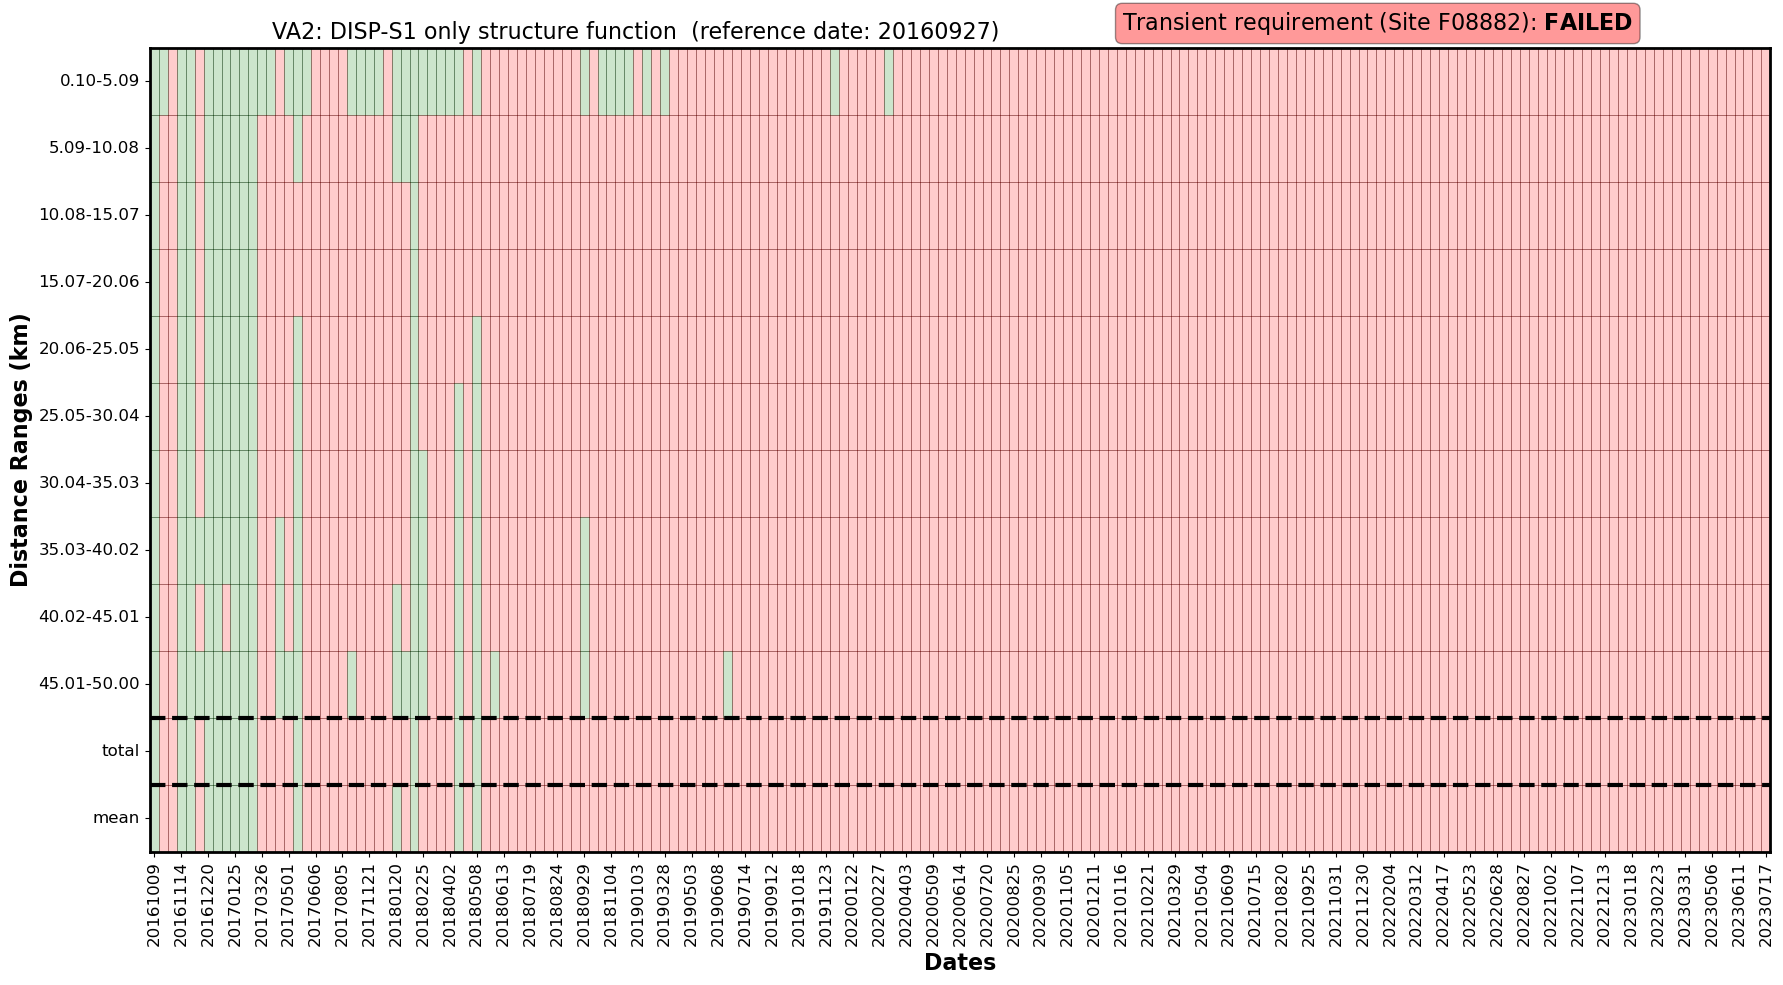

In [62]:
# output figure for displaying a validation result
reference_date = ifgs_date_dt[0,0].strftime('%Y%m%d') 
title_text = f'VA2: DISP-S1 only structure function  (reference date: {reference_date})'
out_fig = f'{output_dir}/VA2_result_Transient_relative_DISP-S1_measurements_site{site}.png'
plot_transient_table(ratio_pd, site, percentage, thresthod, title_text, out_fig, annot=False) # generate a figure (annot=True means each cell has a value. Not recommended for large datasets)

<div class="alert alert-warning">
Approach 2 final result for CentralValleyA144: 100% of DISP-S1s passes the requirement.
</div>

<a id='transient_appendix'></a>
# Appendix: GNSS Position Plots

GNSS vs DISP-S1 scatter plots

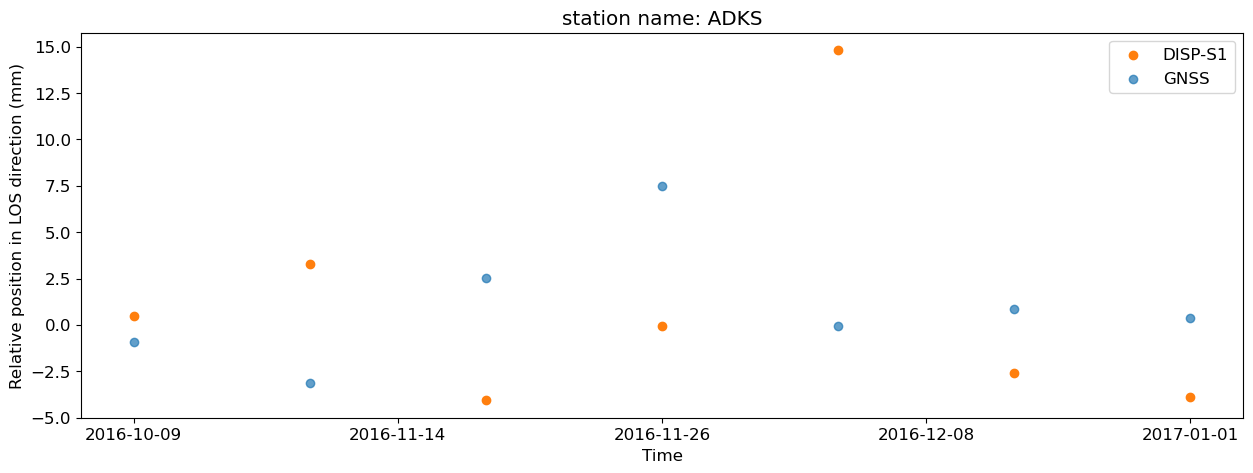

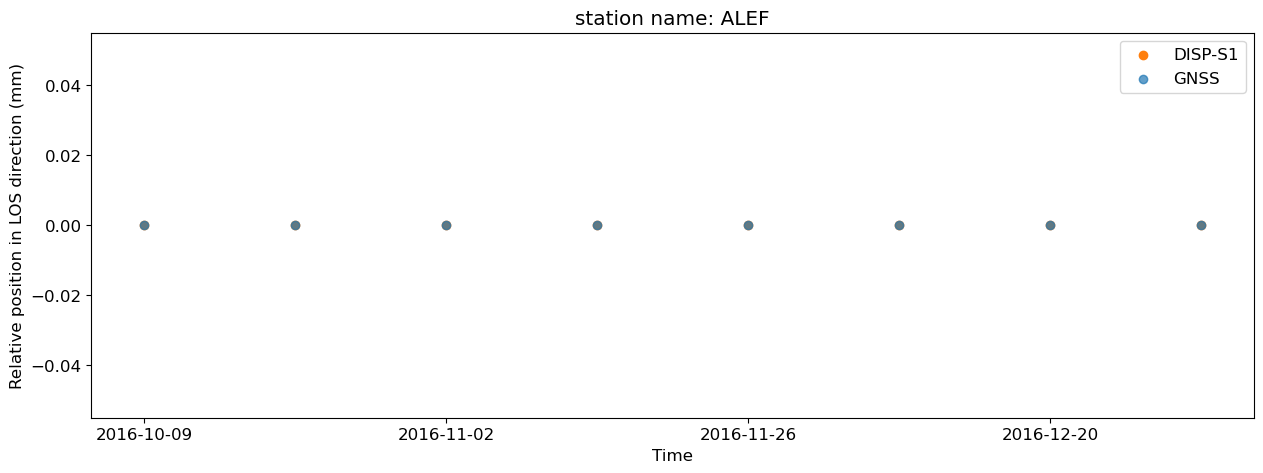

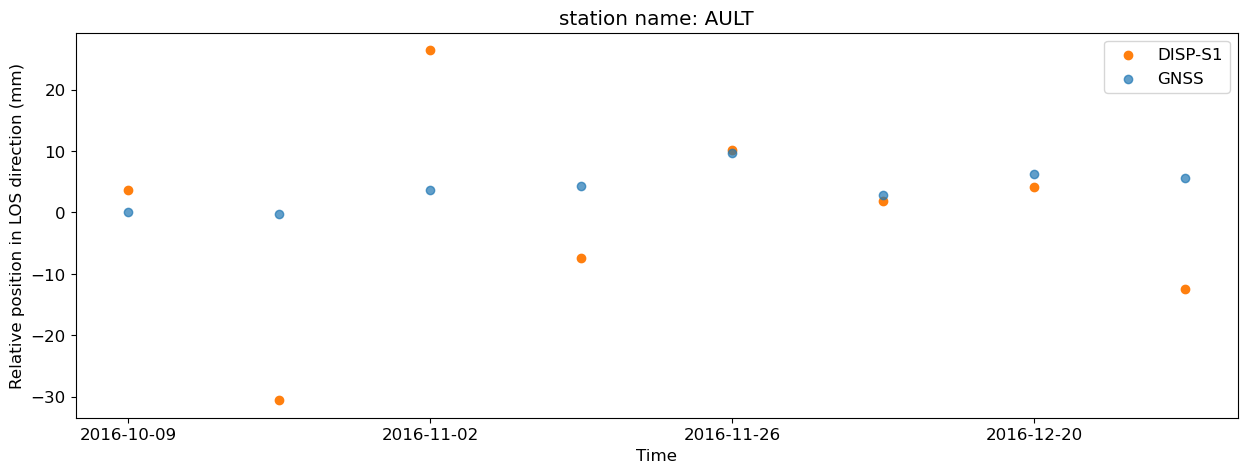

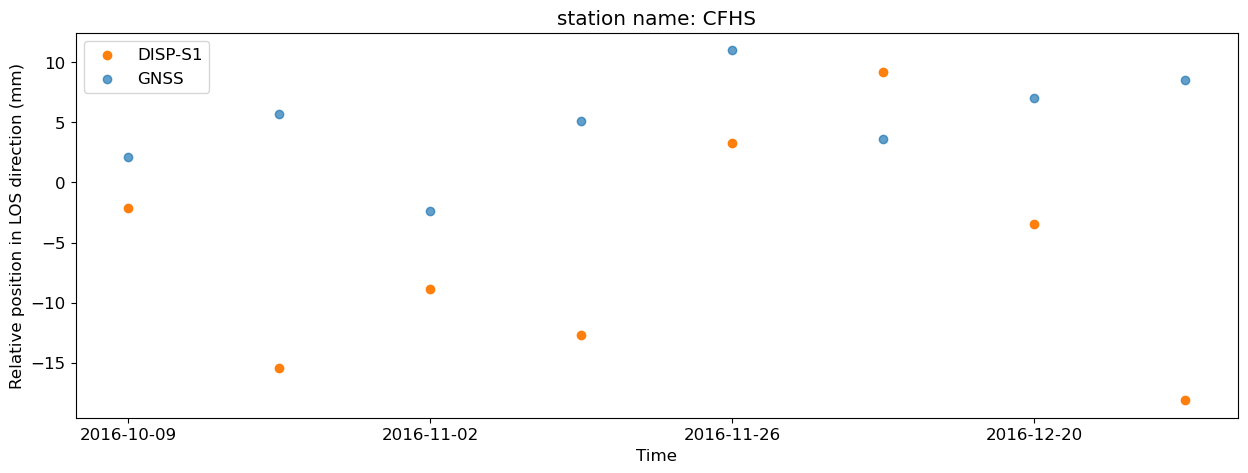

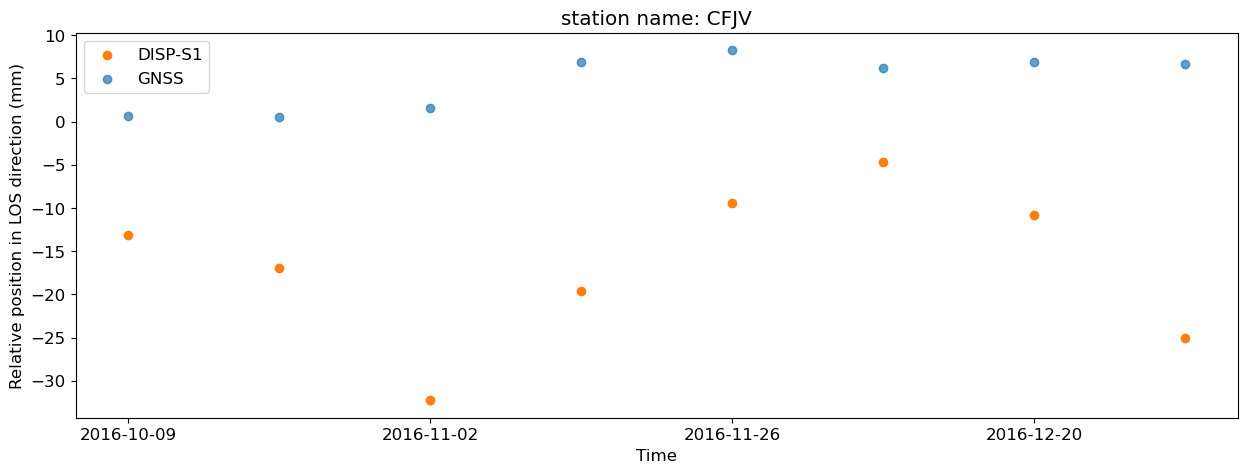

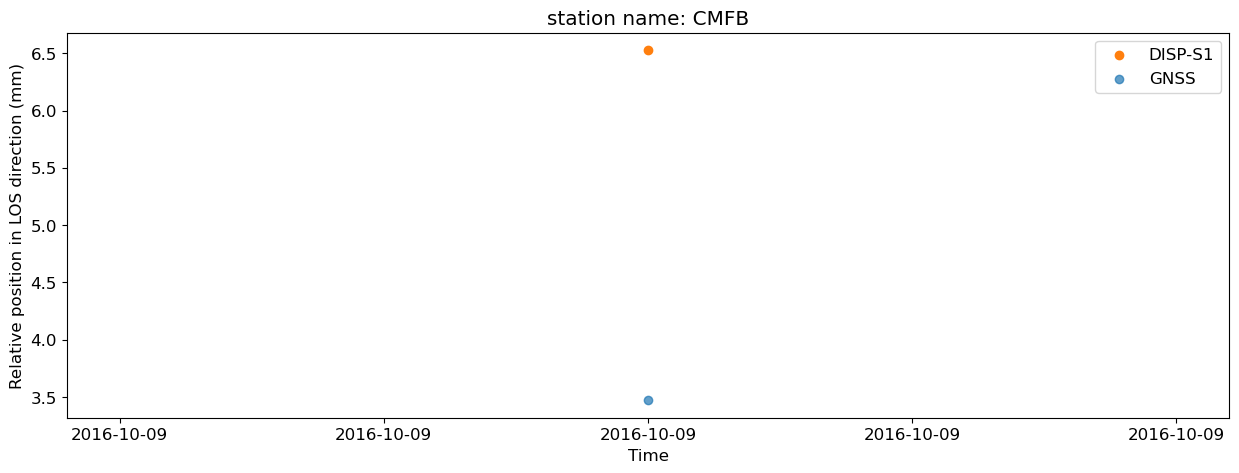

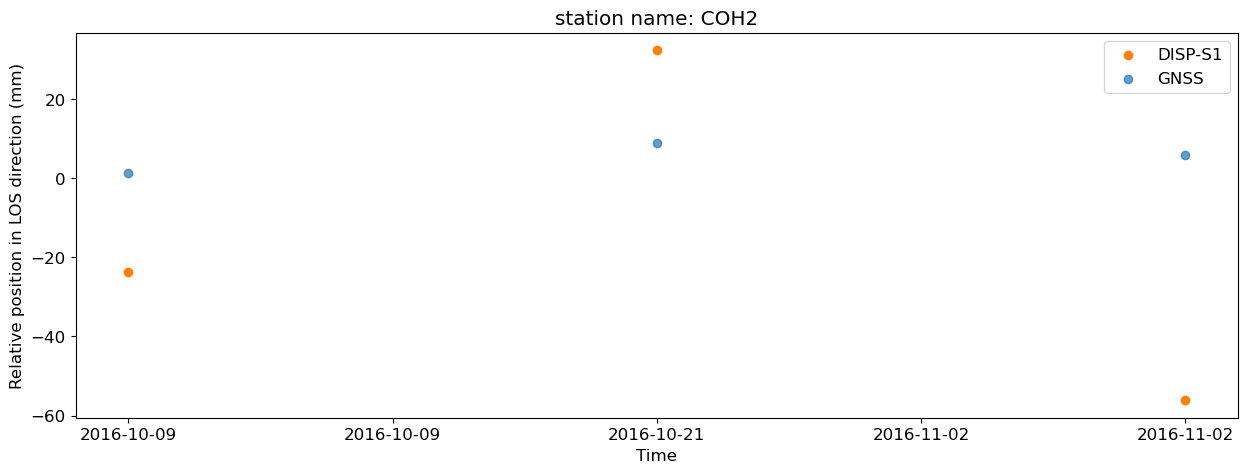

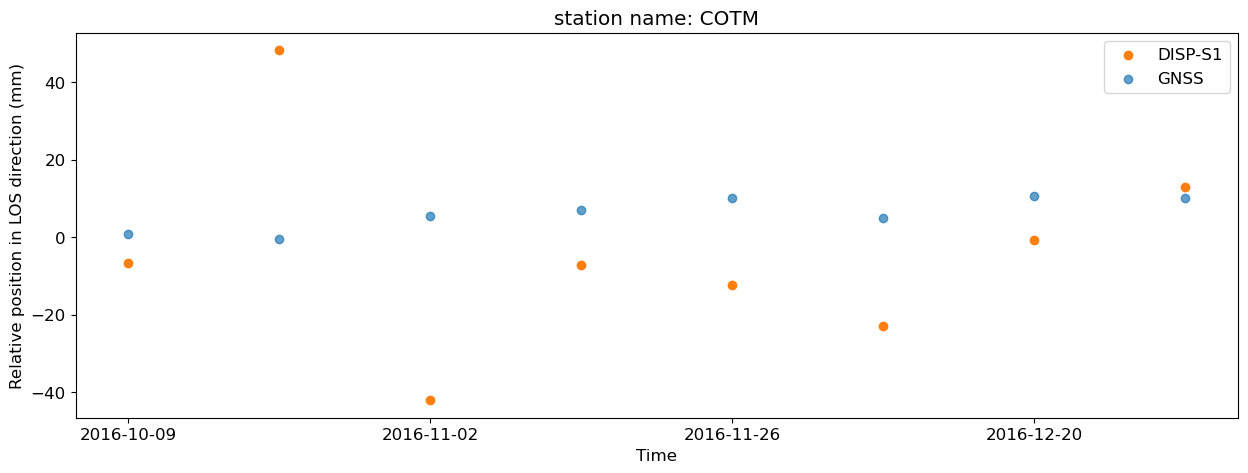

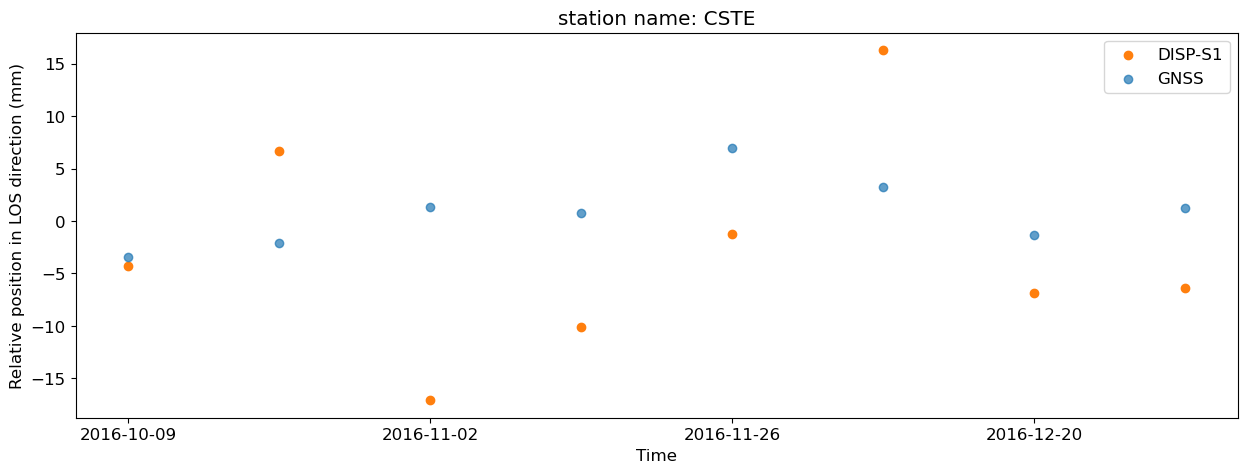

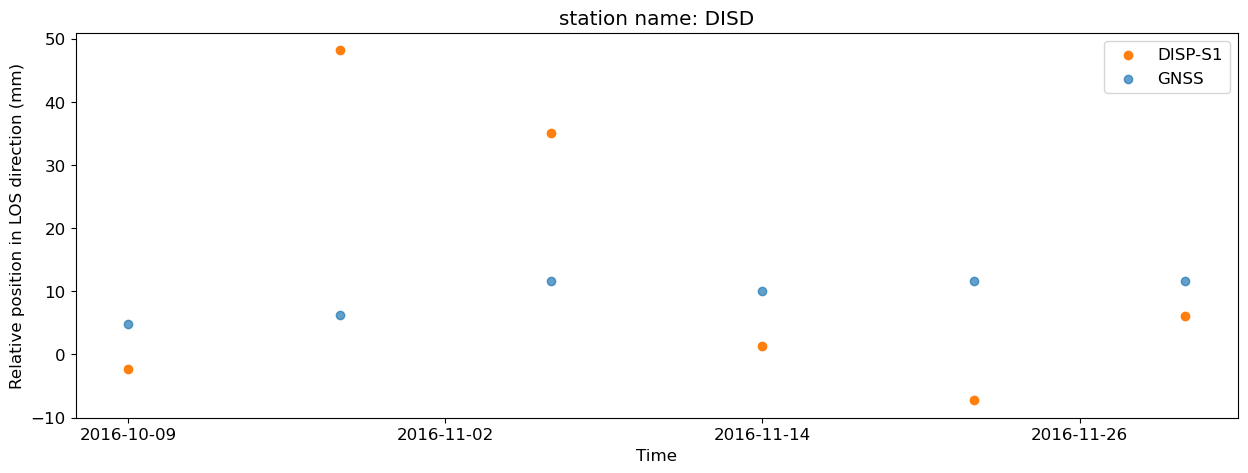

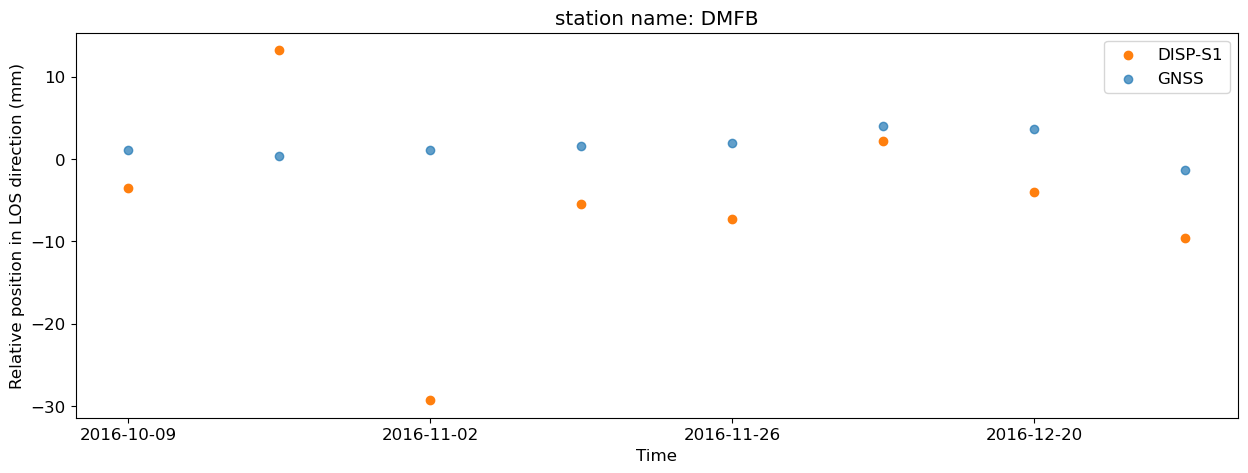

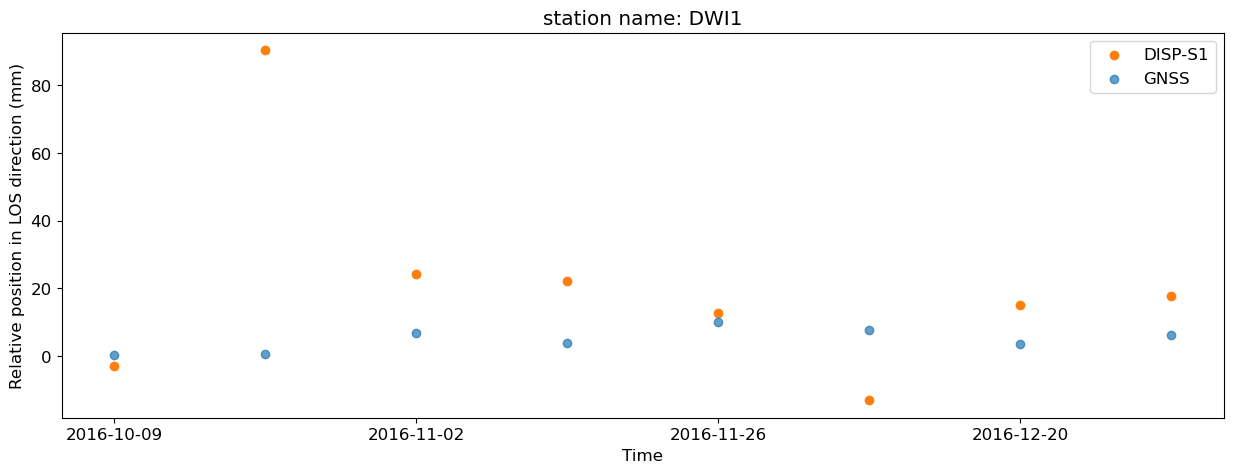

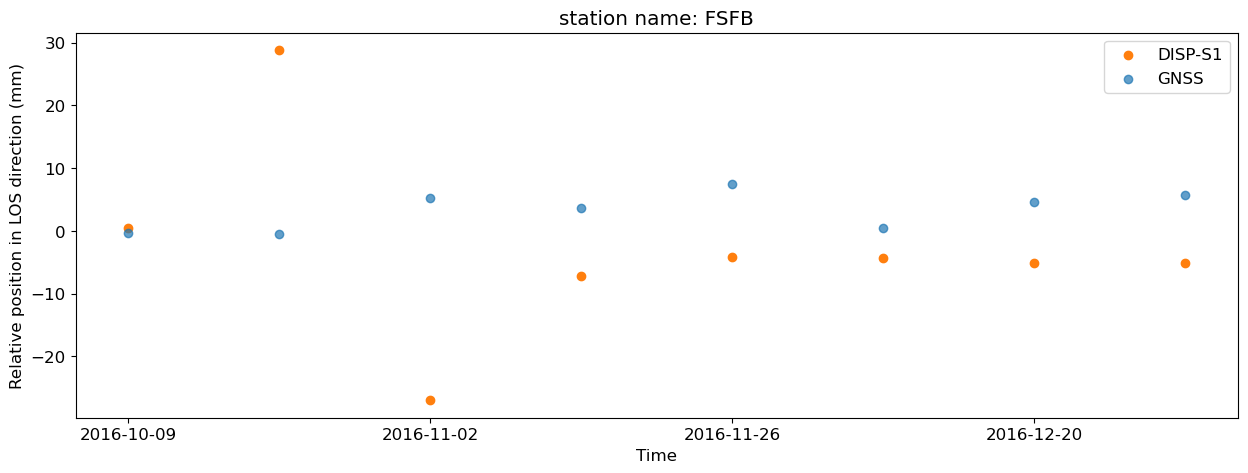

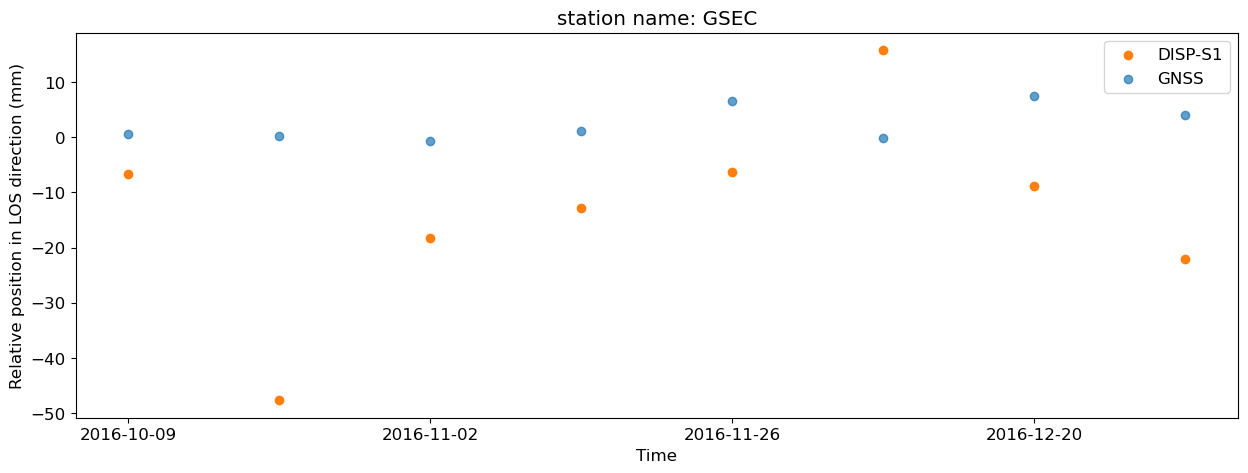

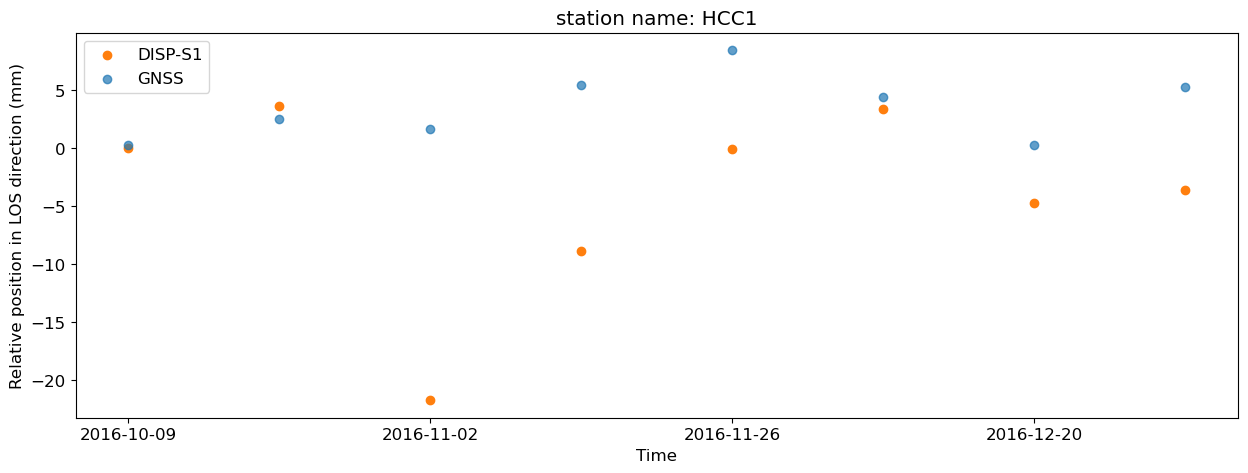

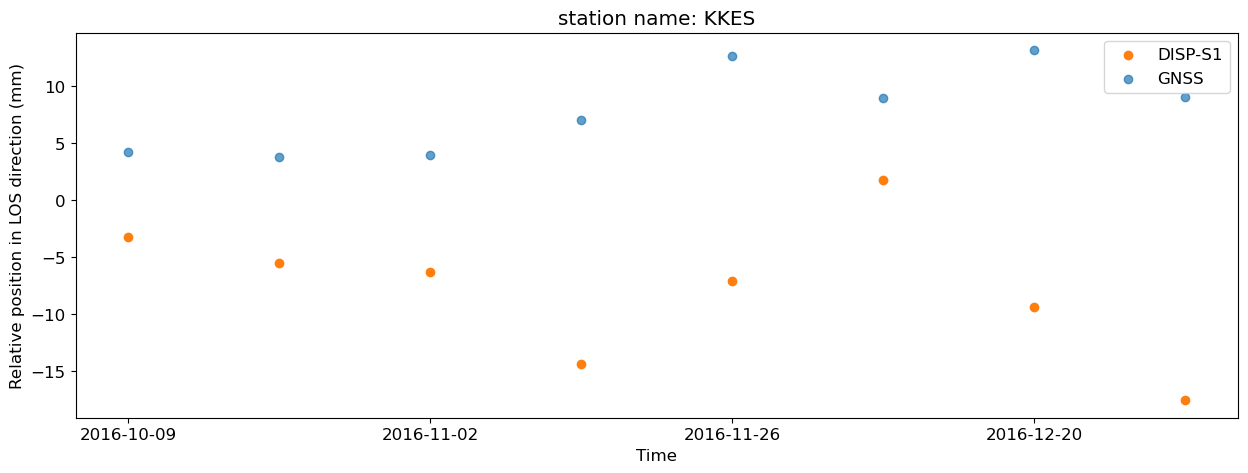

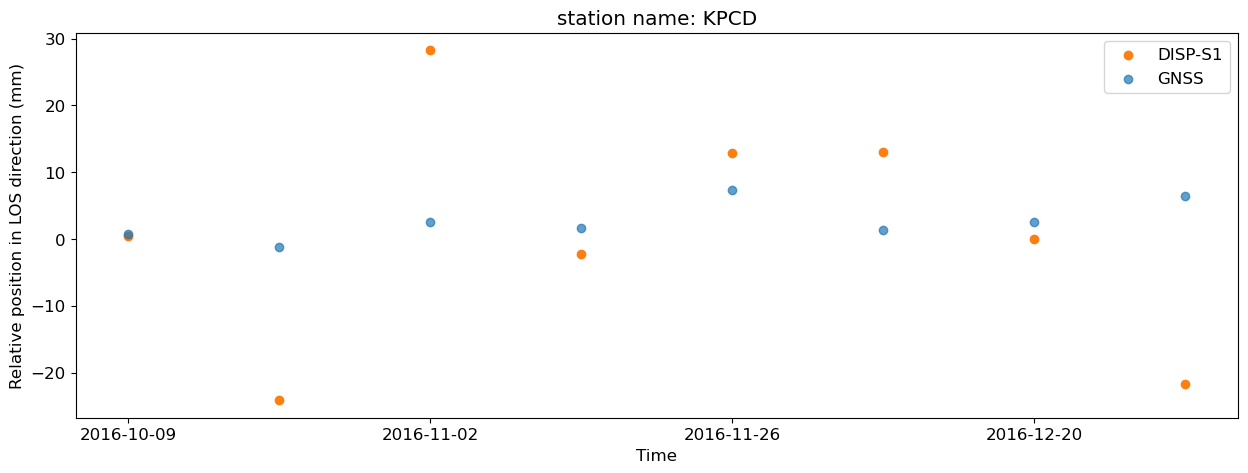

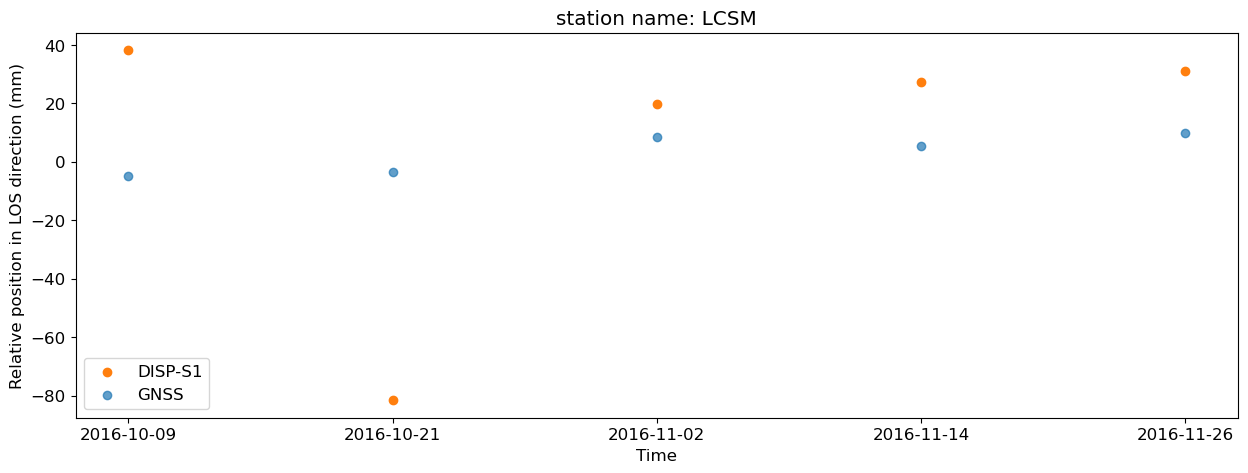

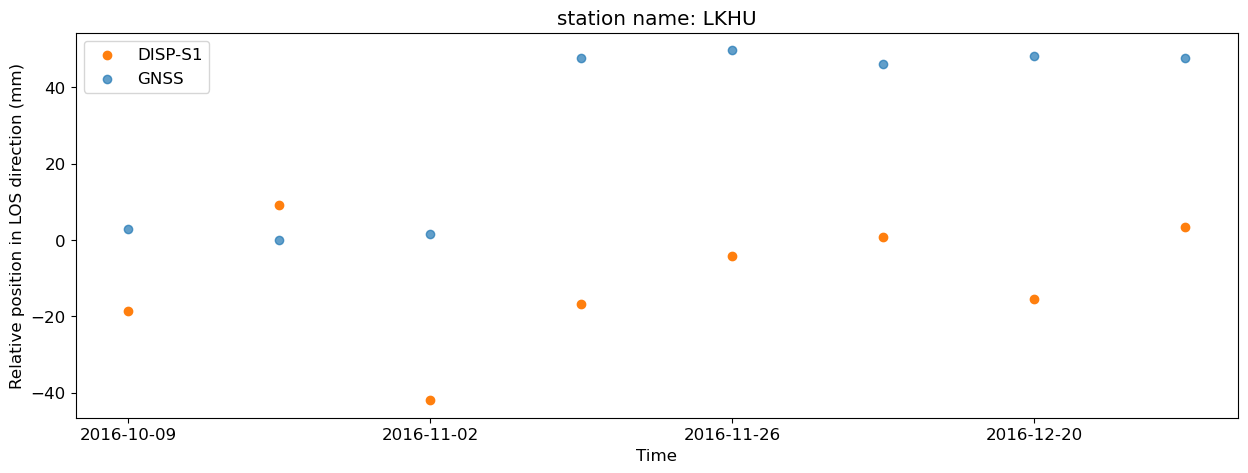

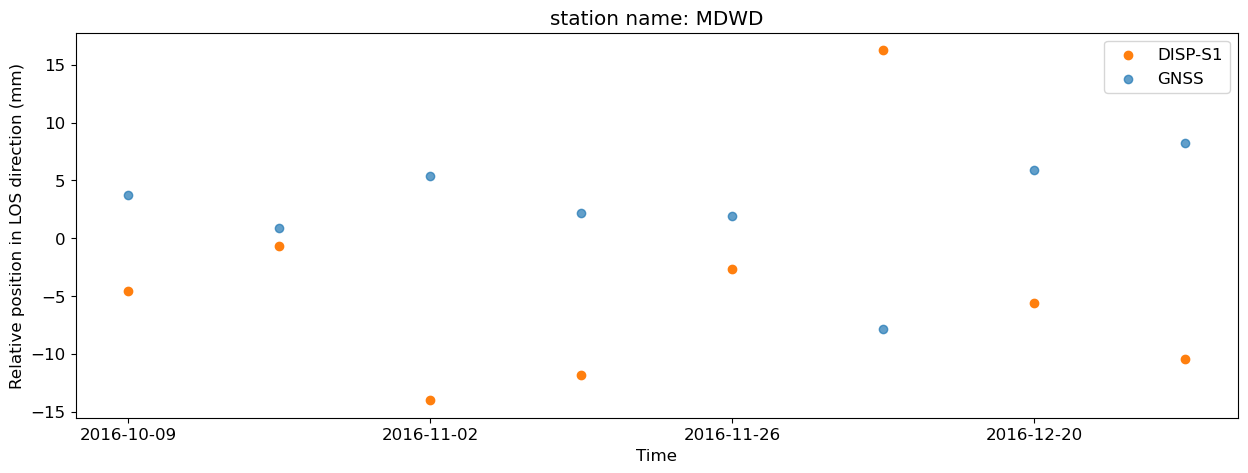

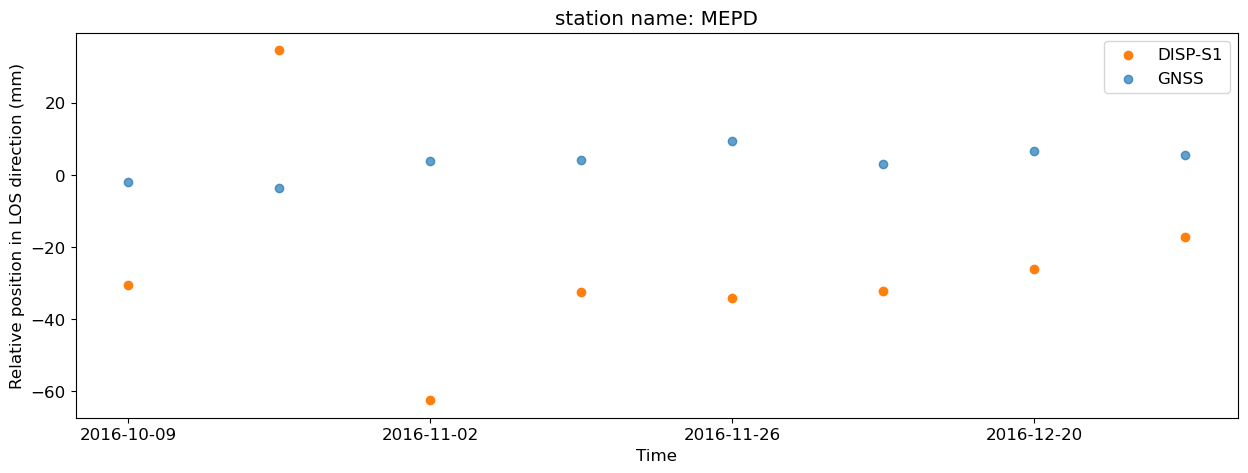

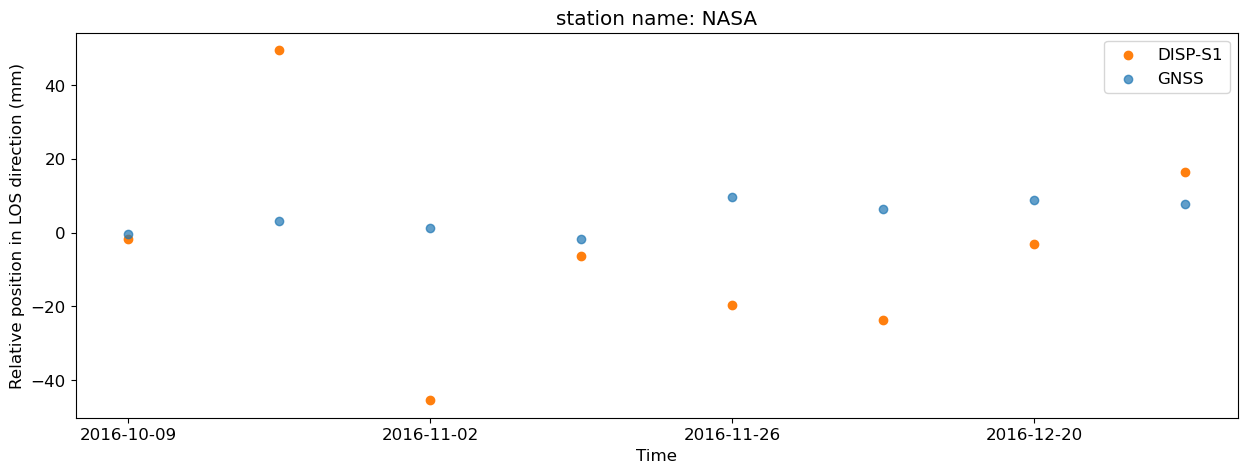

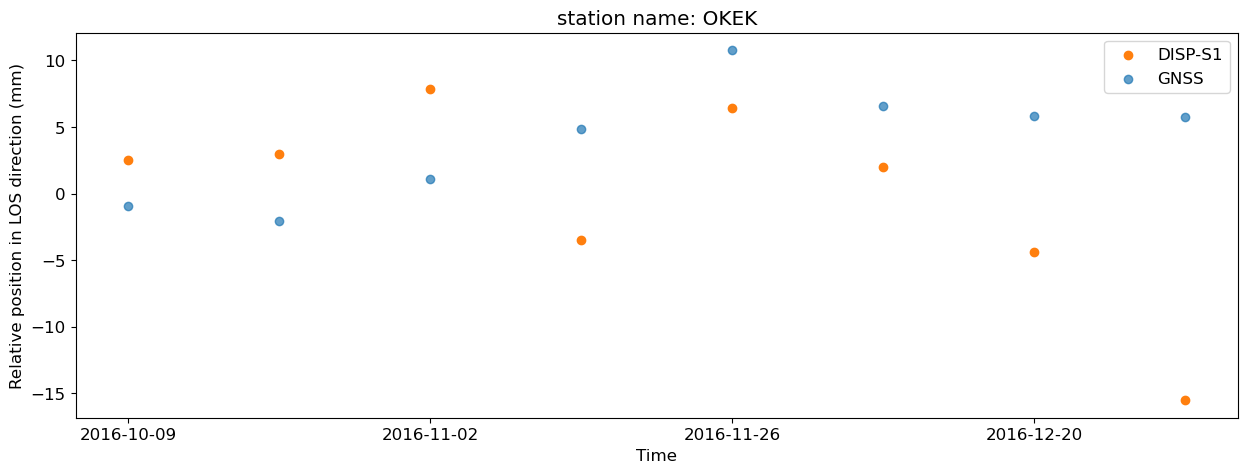

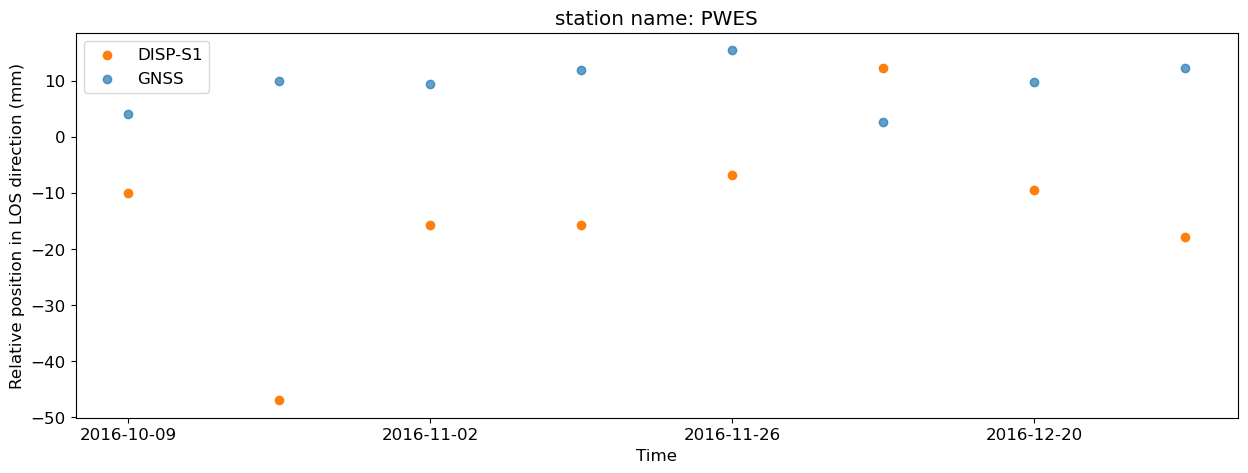

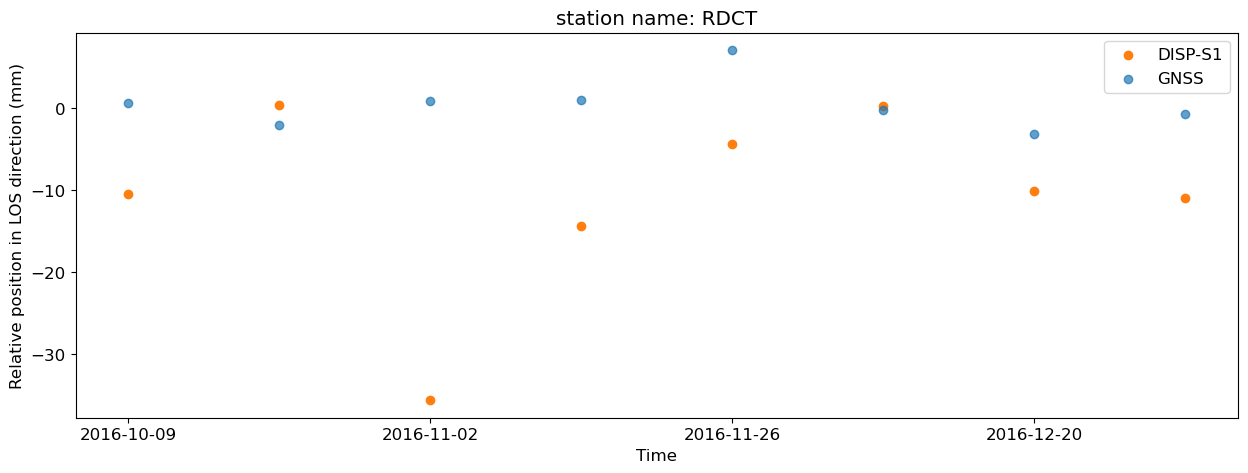

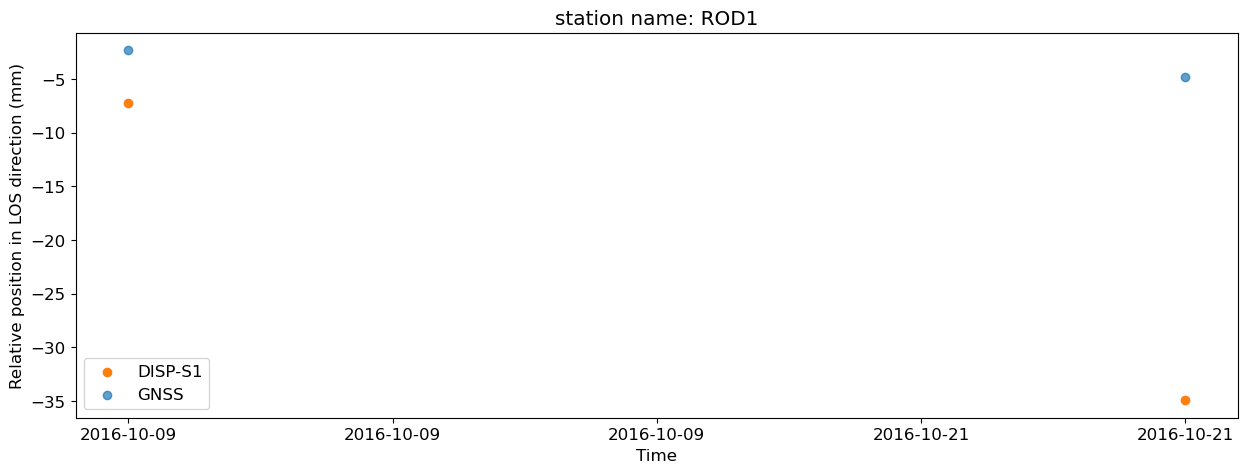

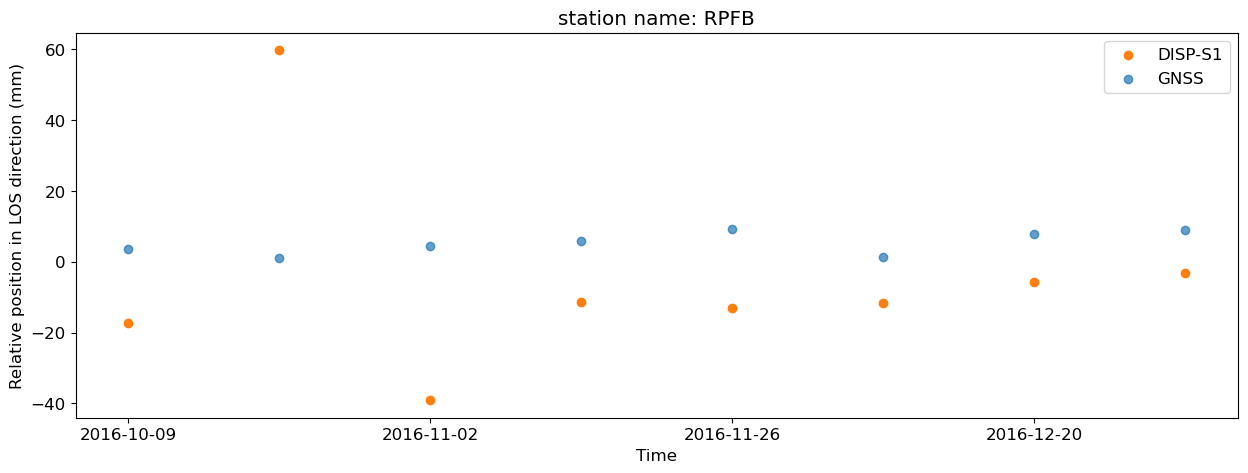

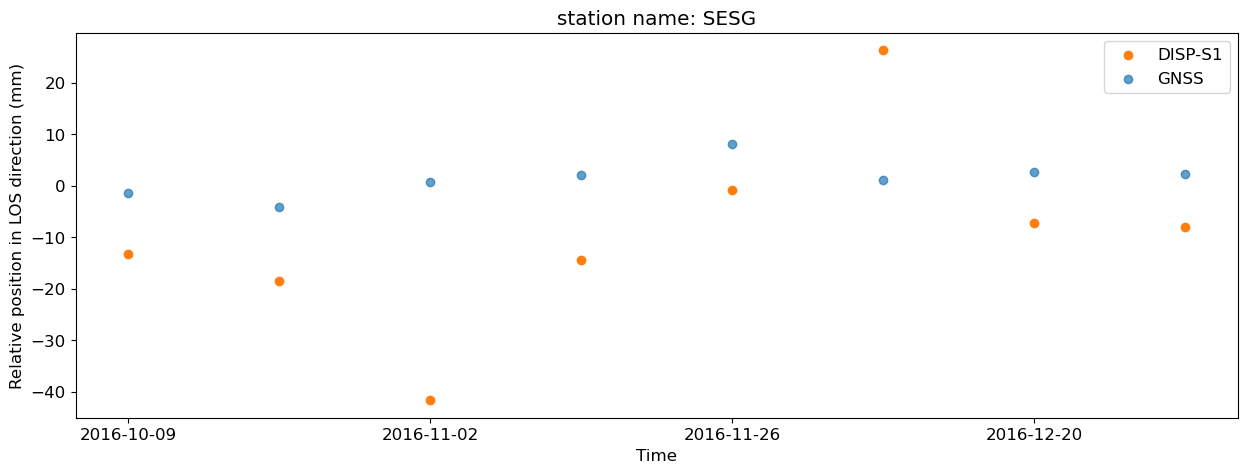

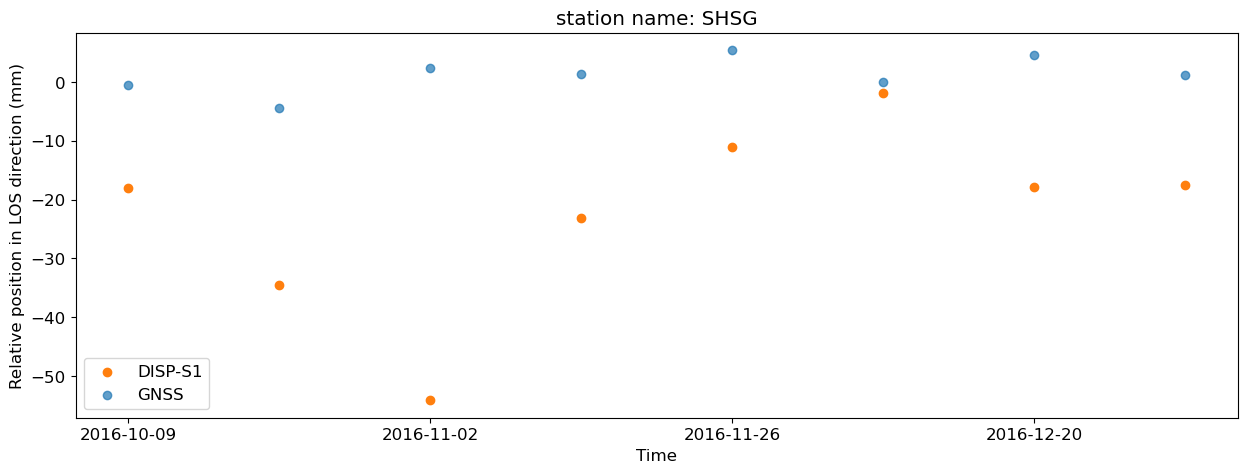

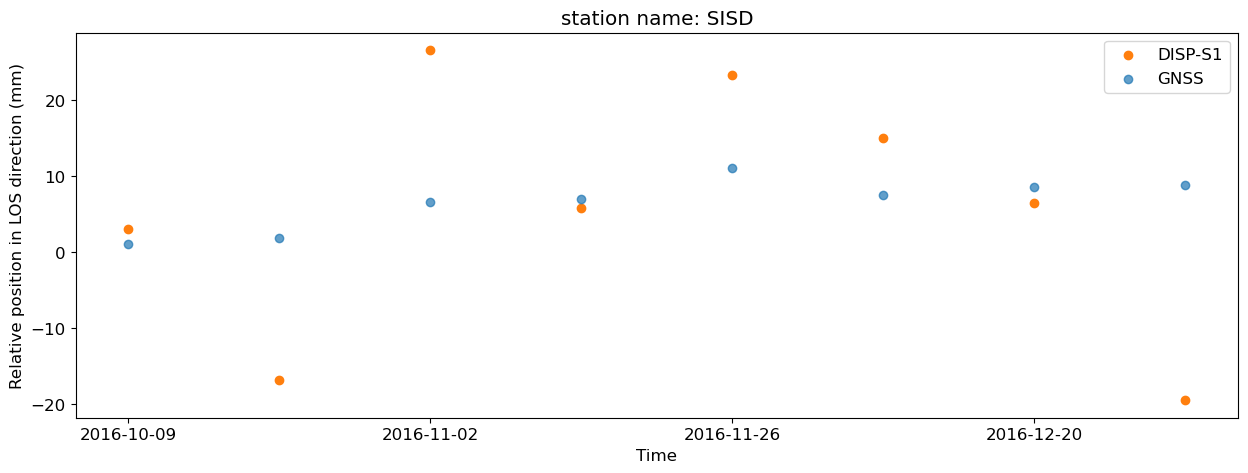

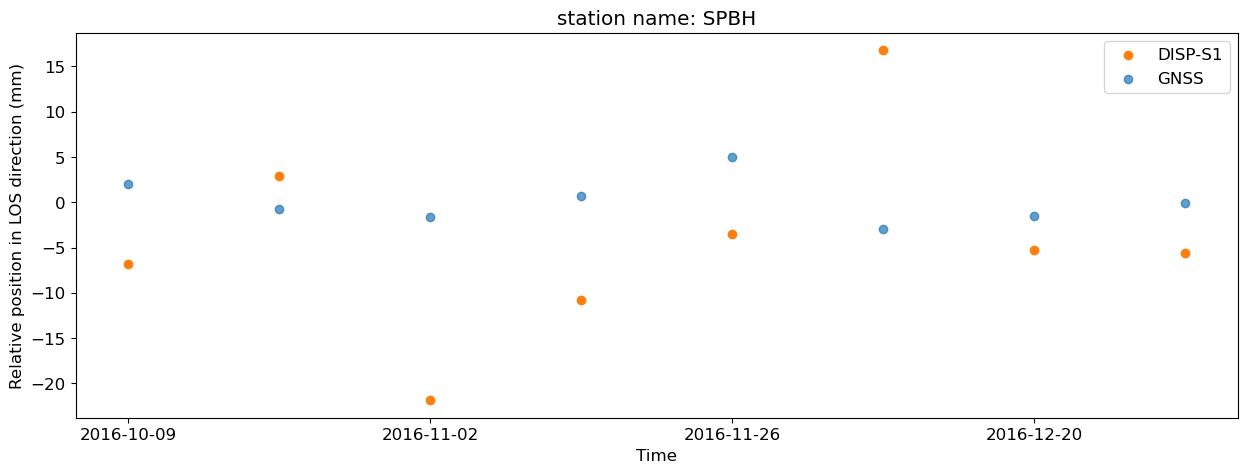

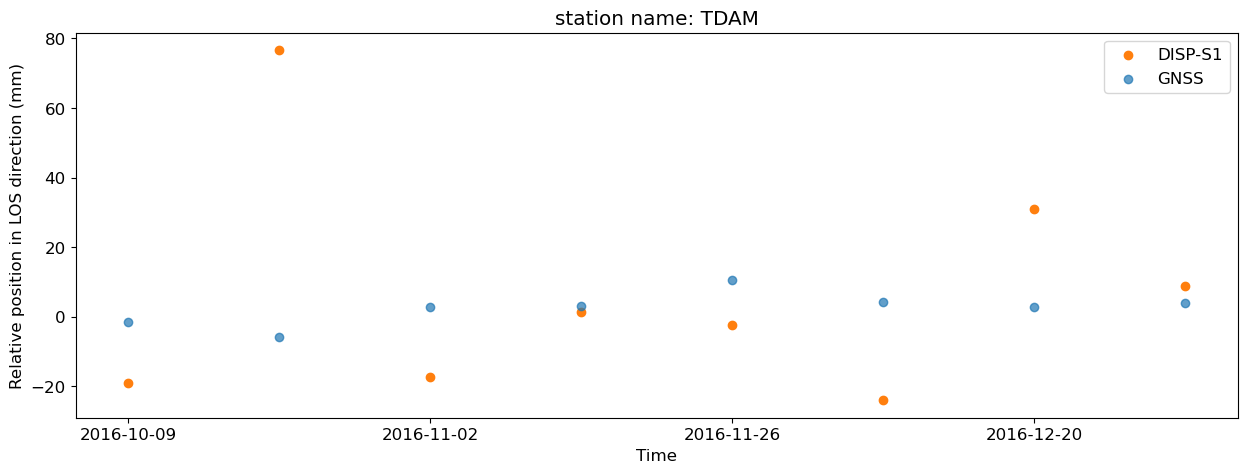

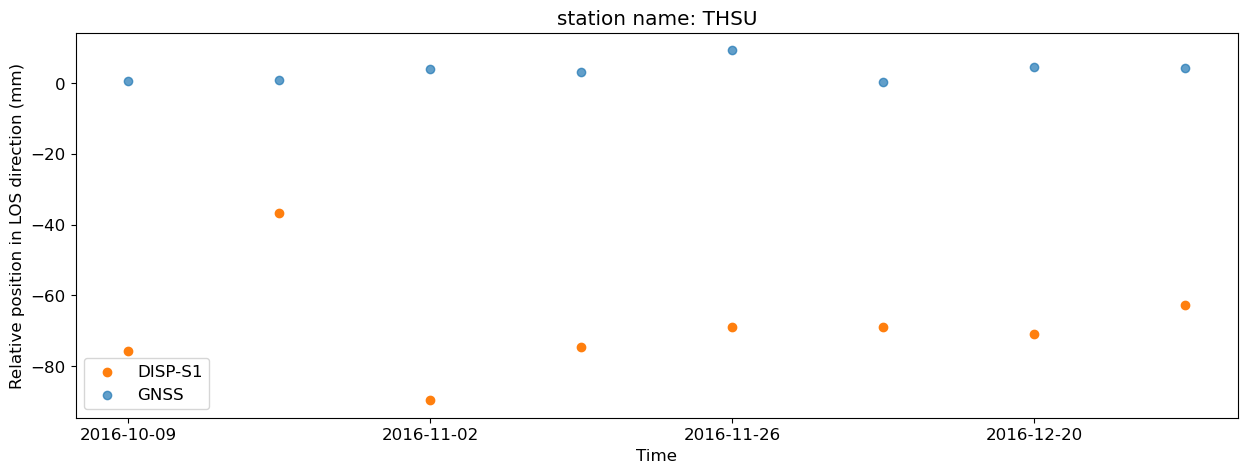

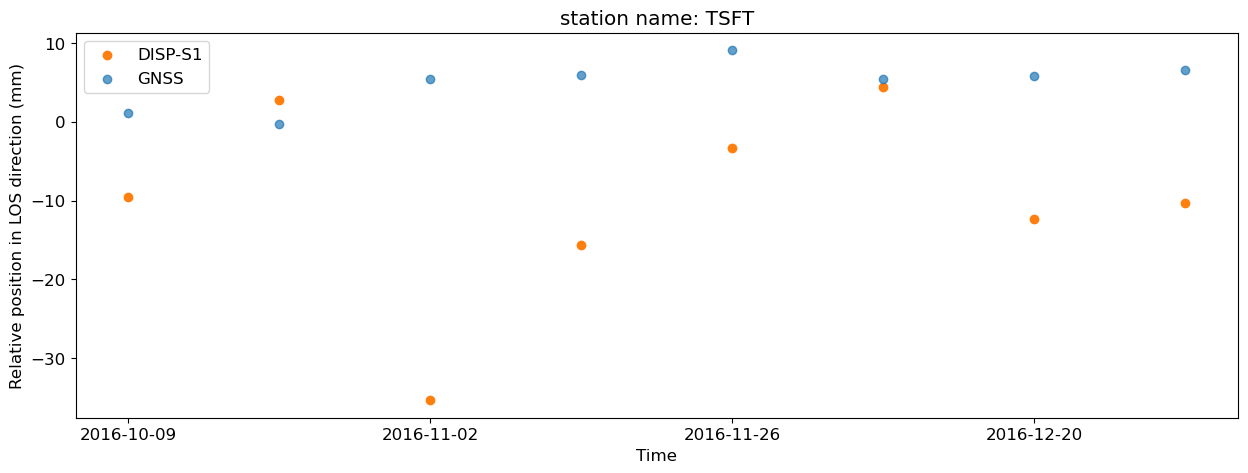

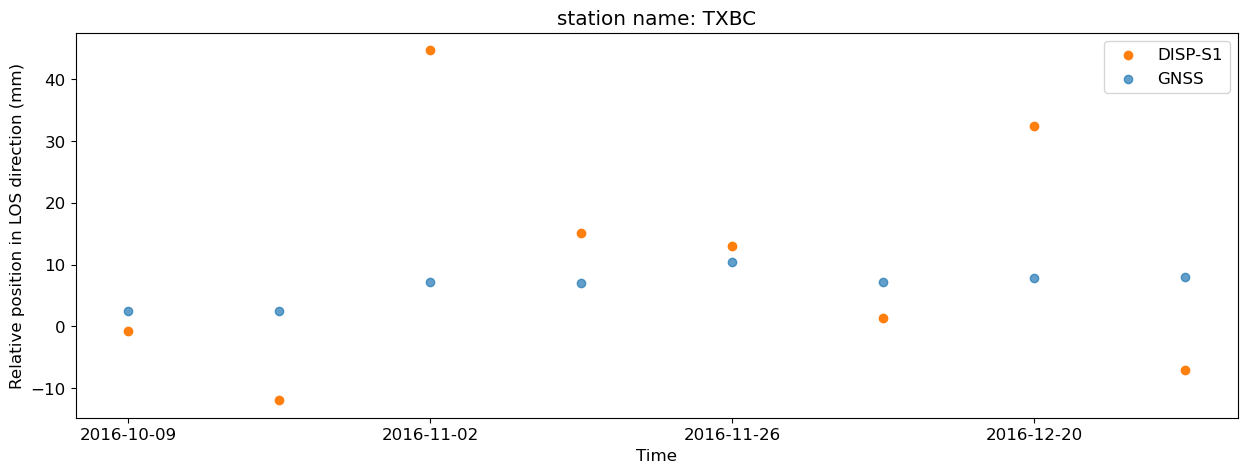

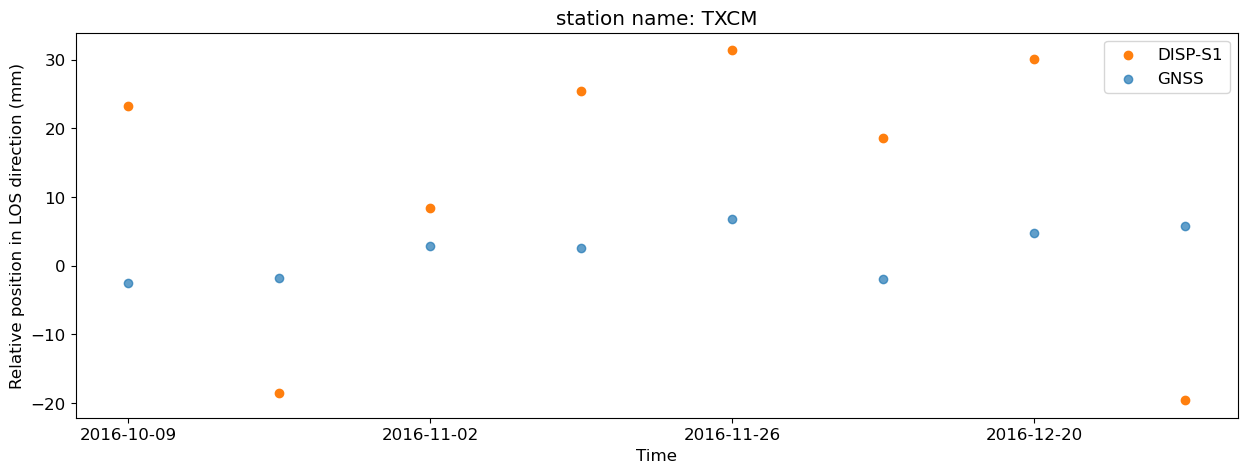

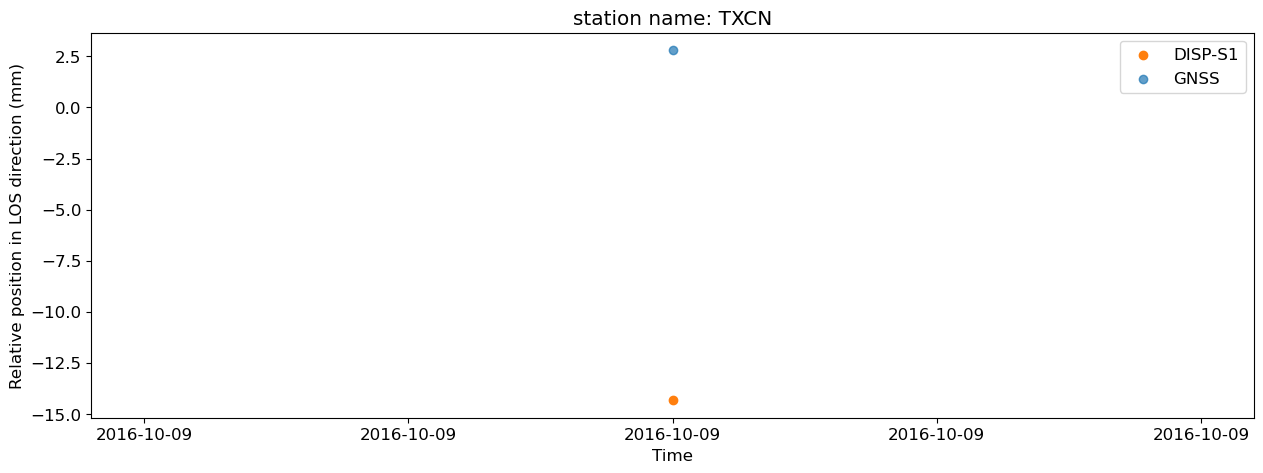

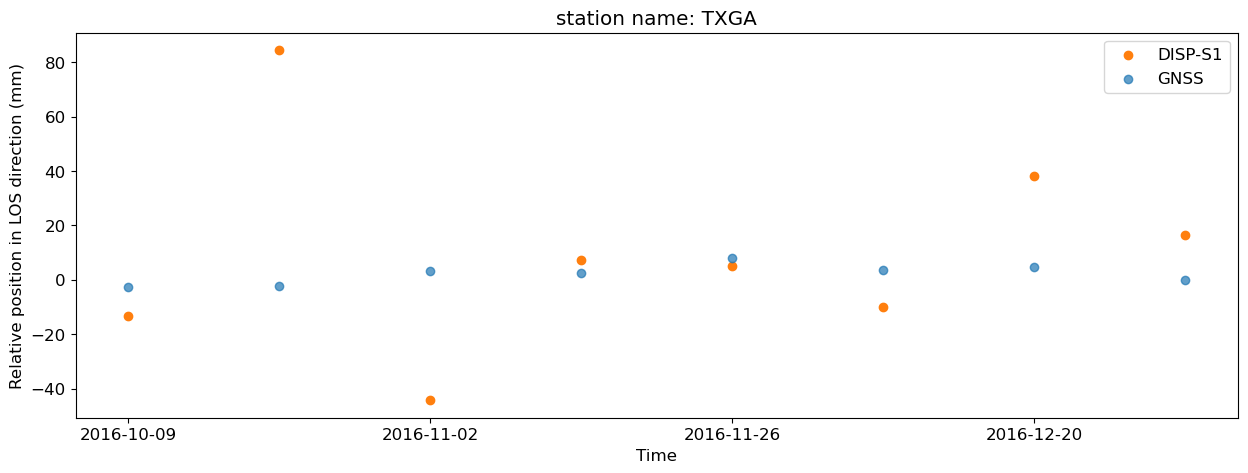

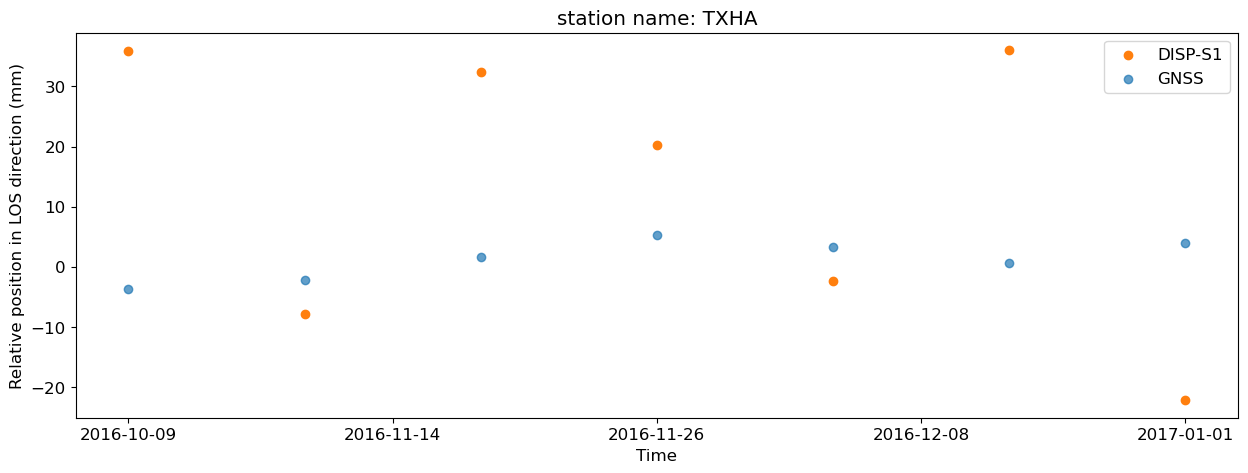

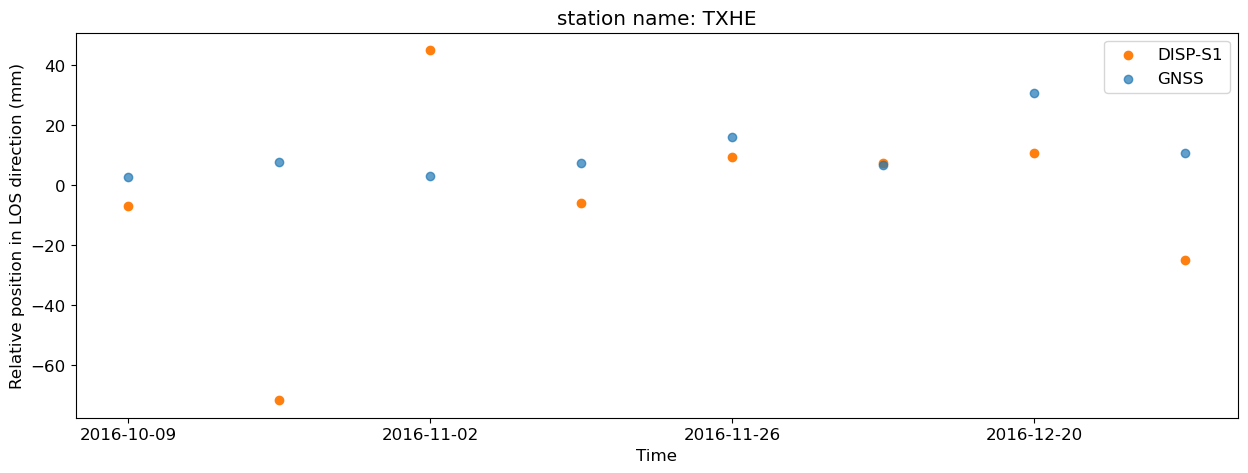

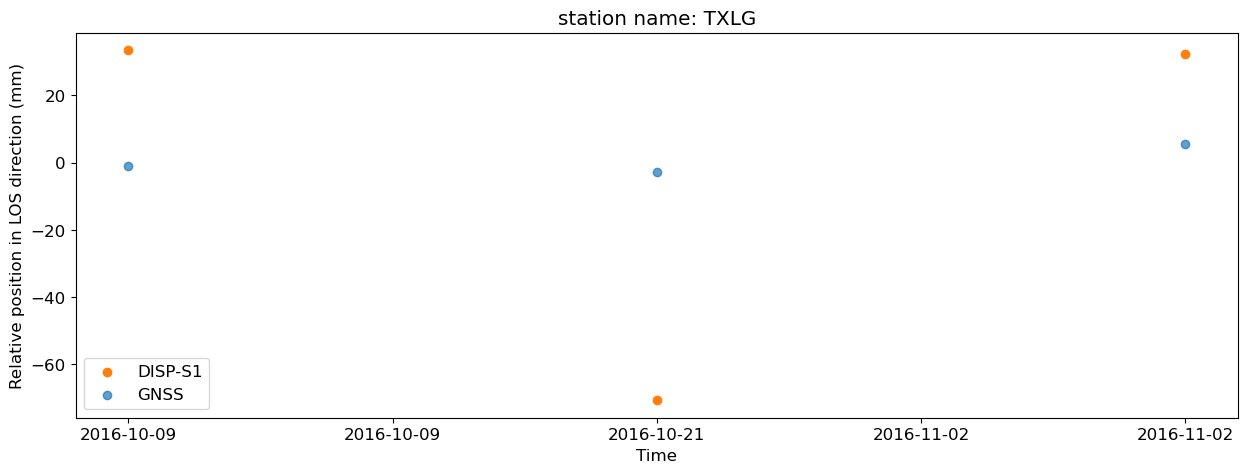

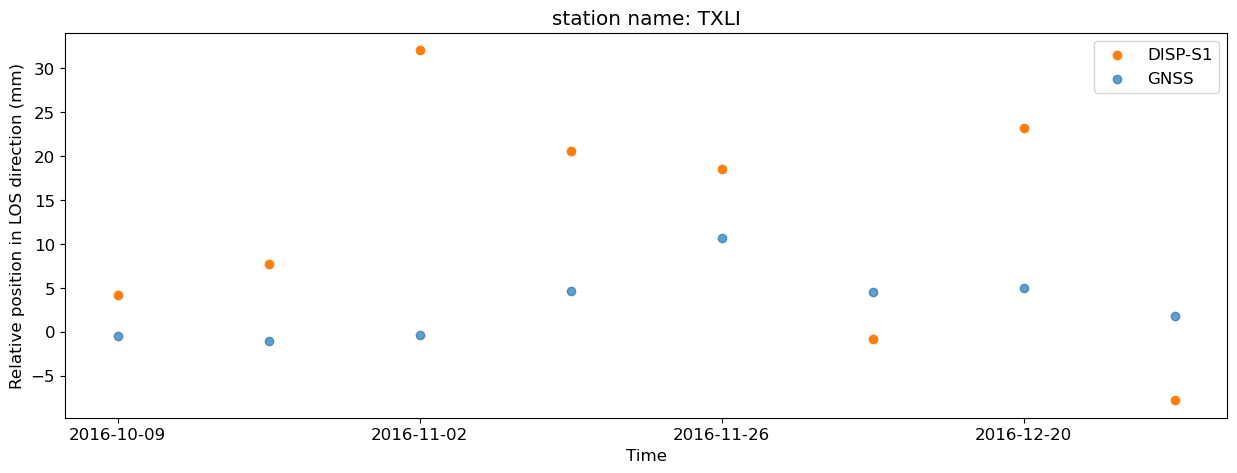

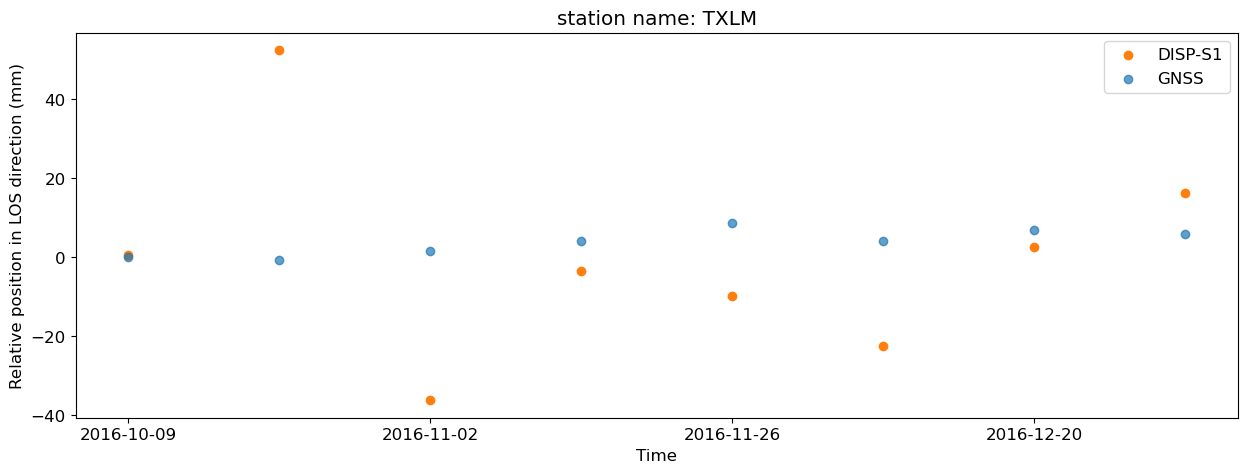

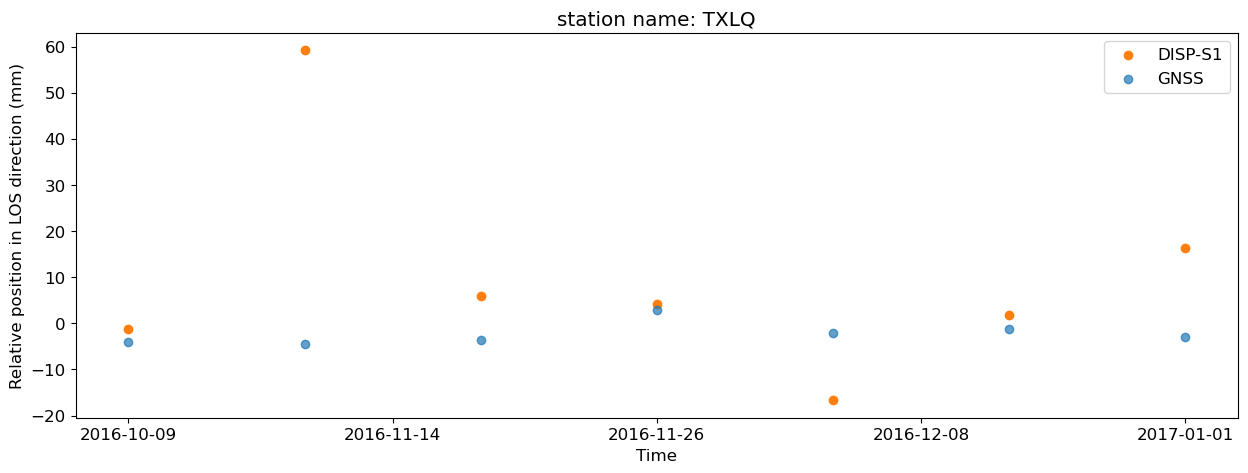

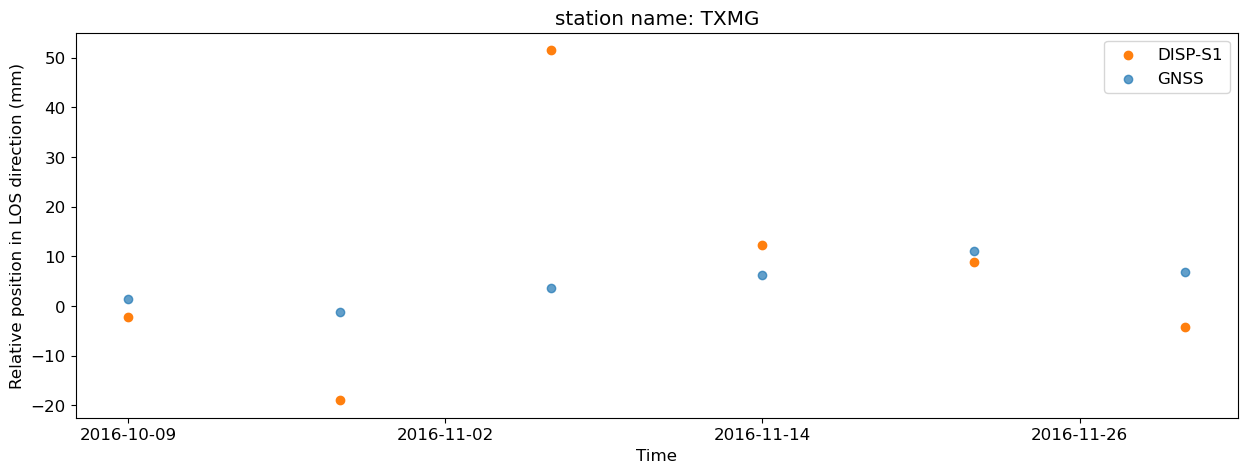

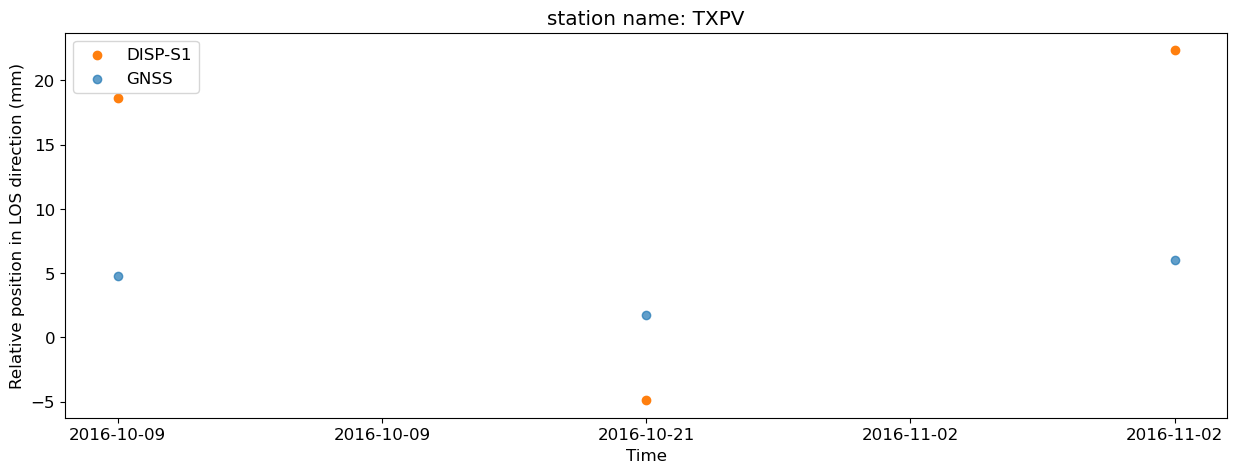

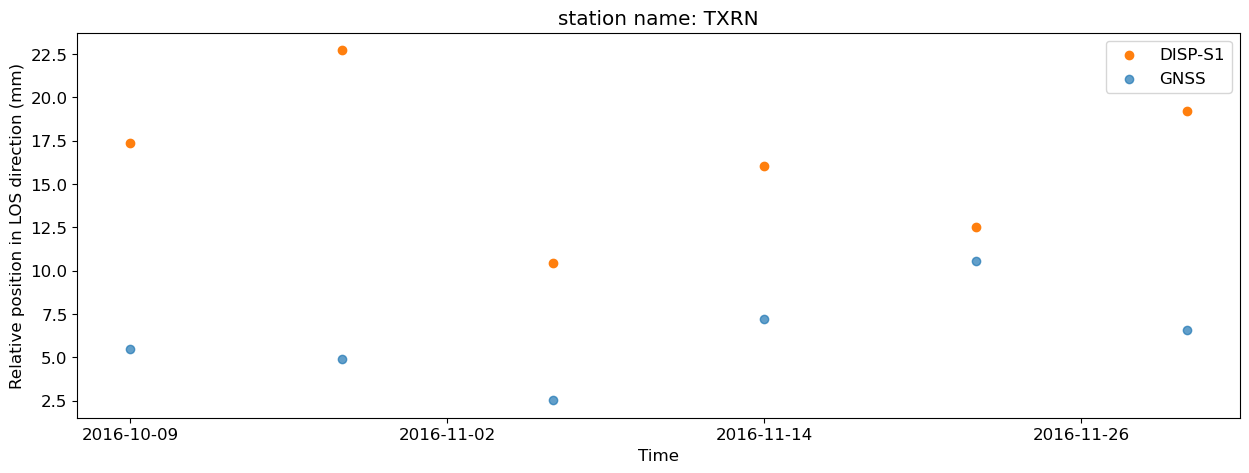

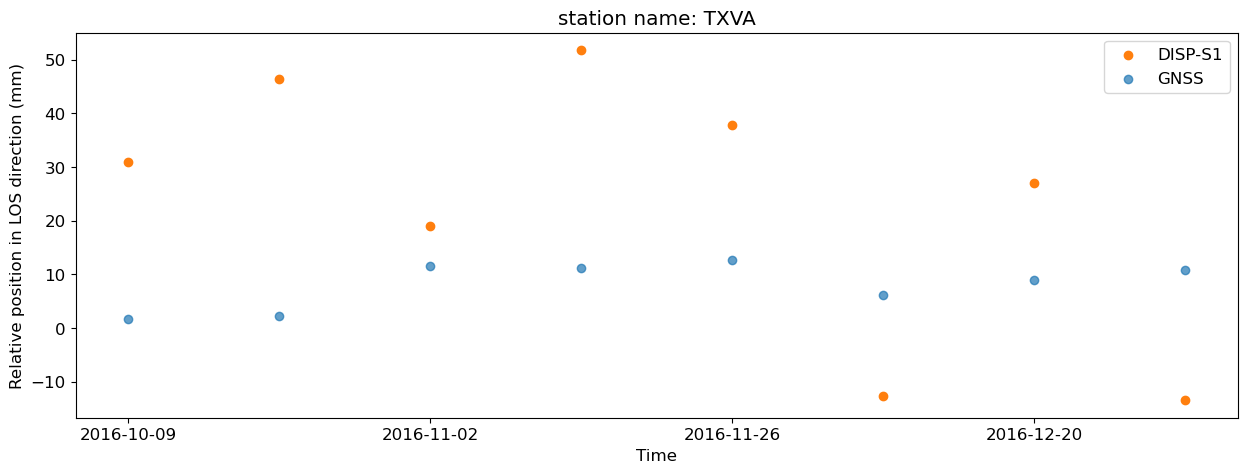

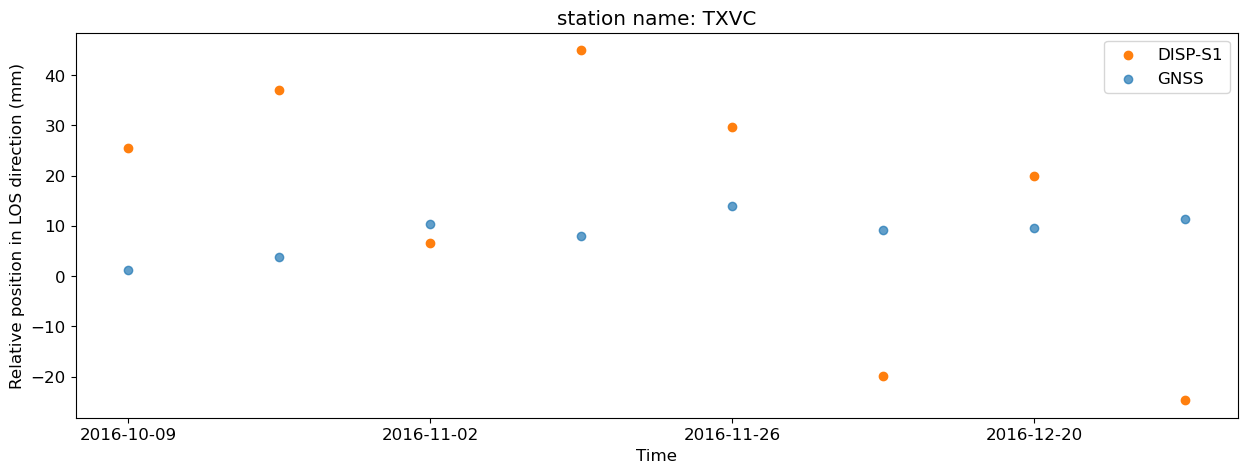

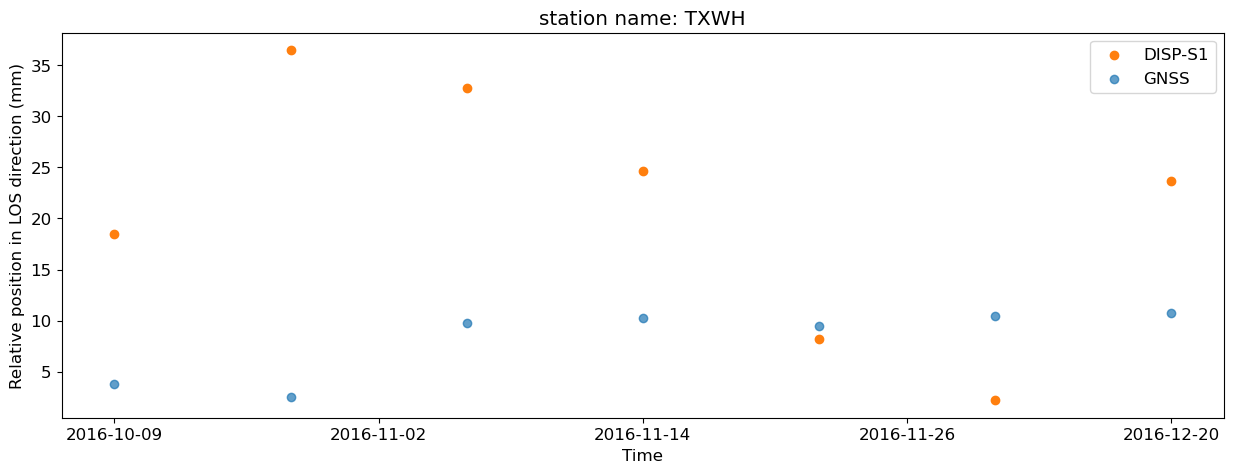

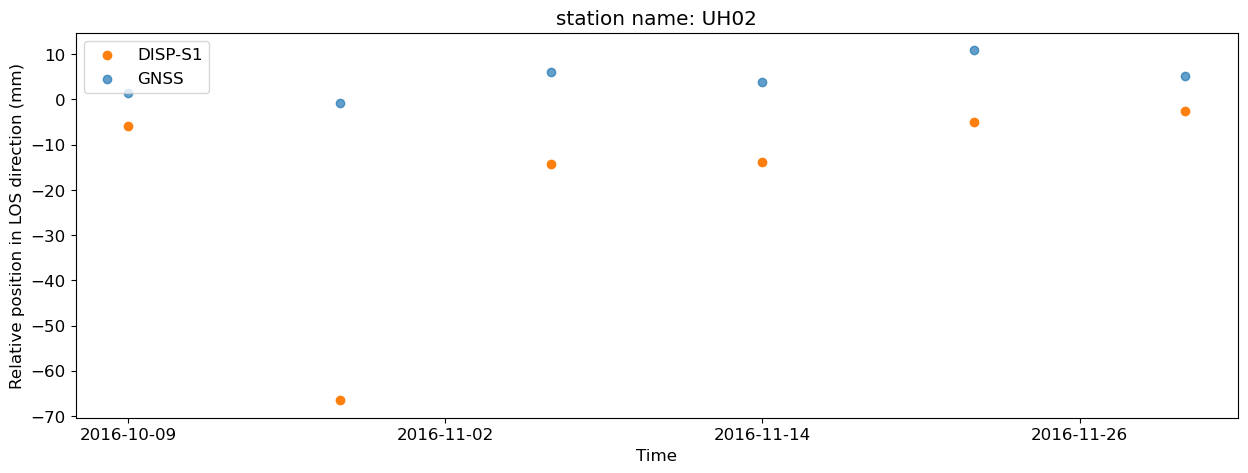

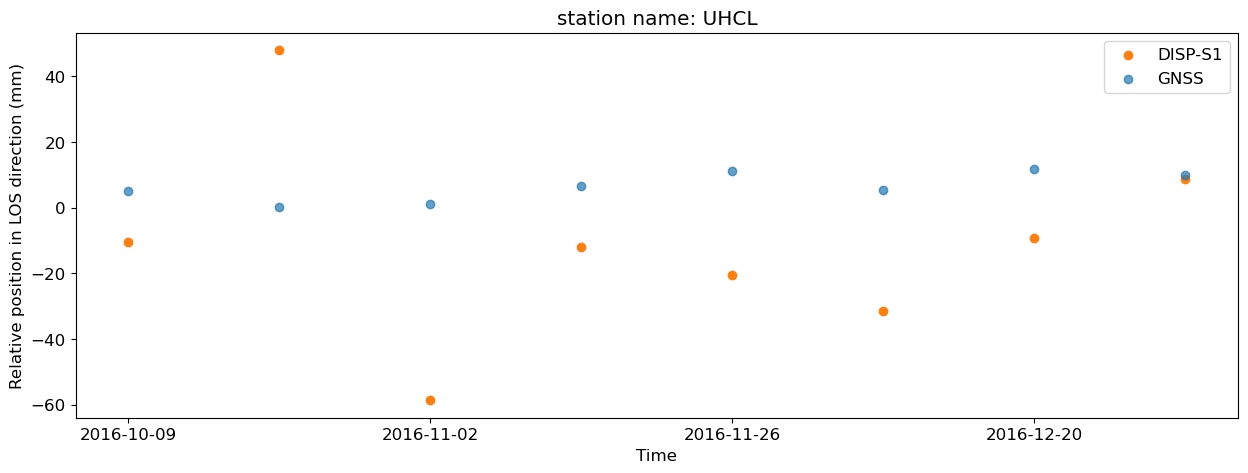

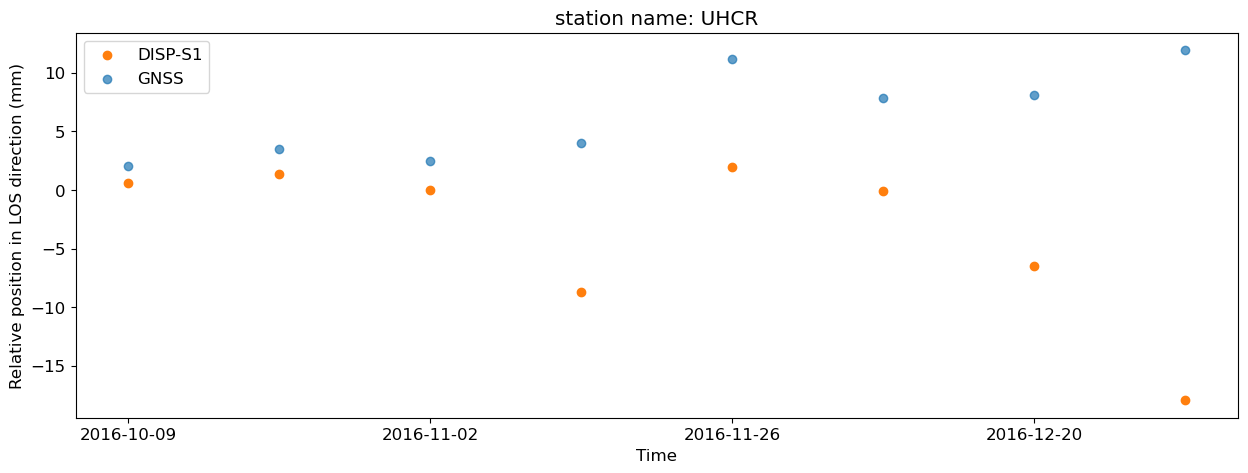

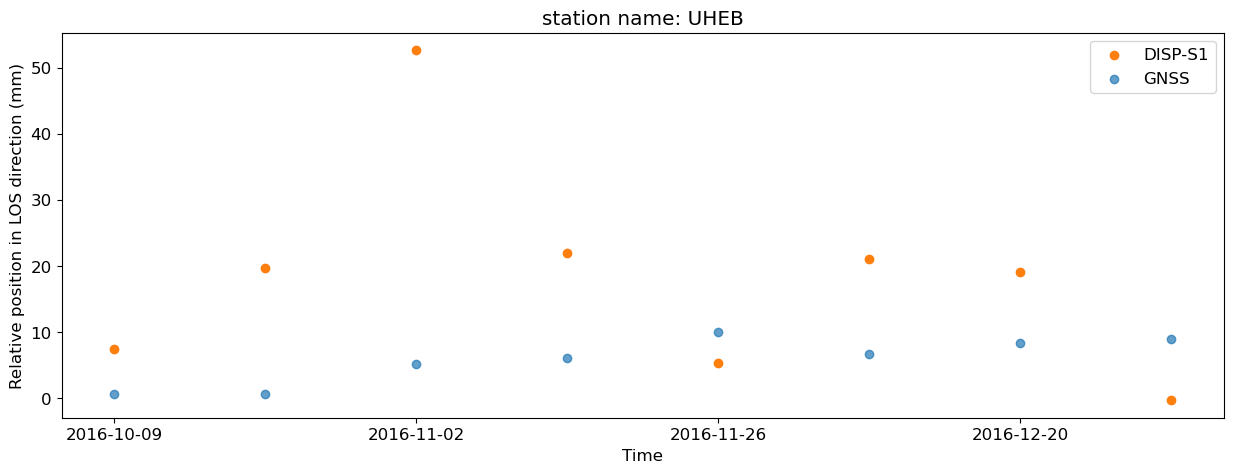

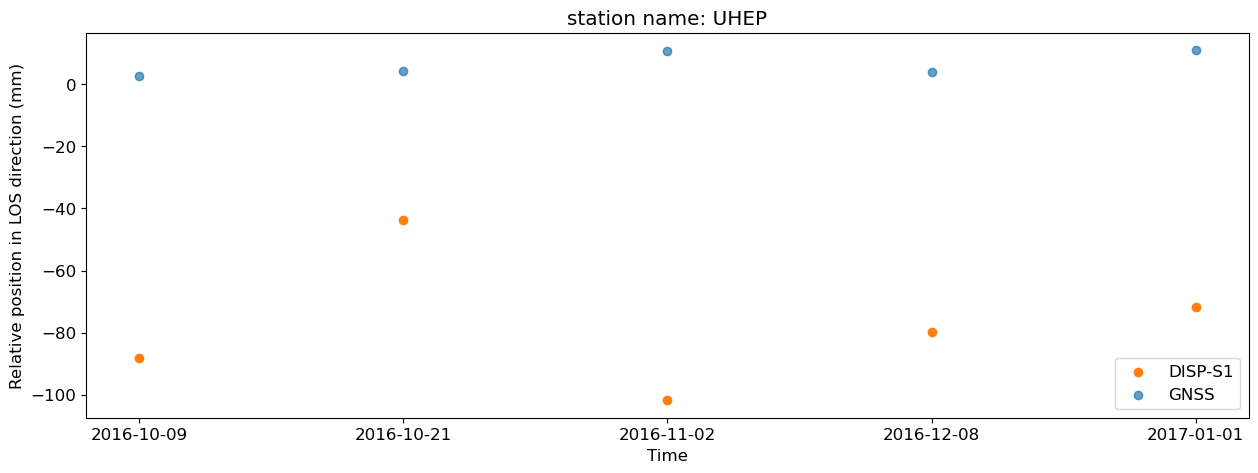

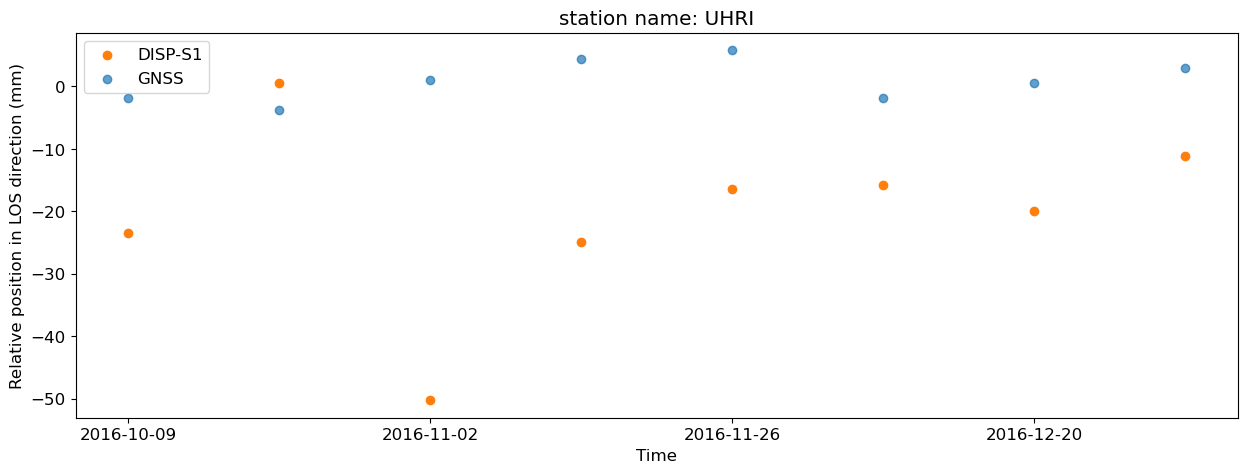

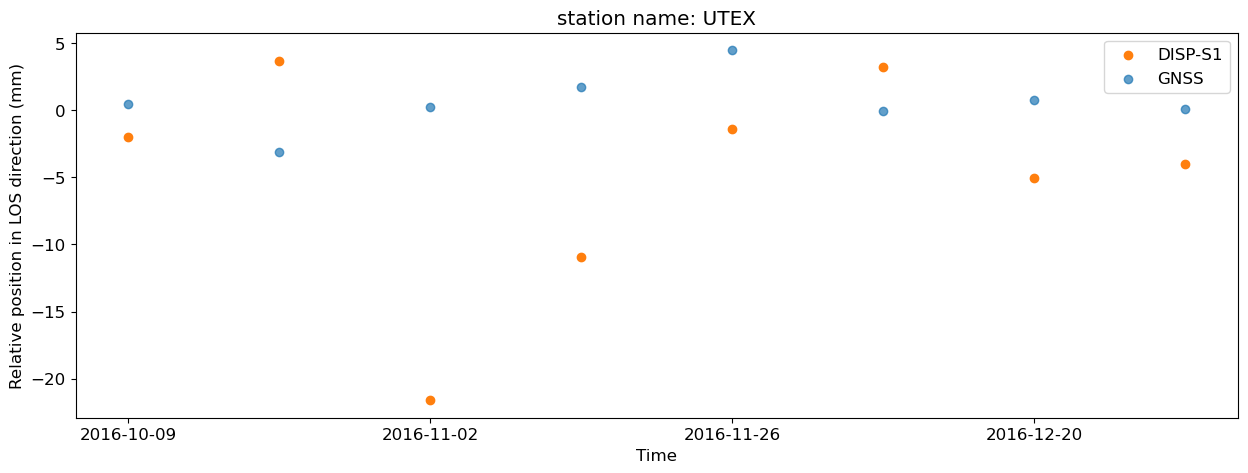

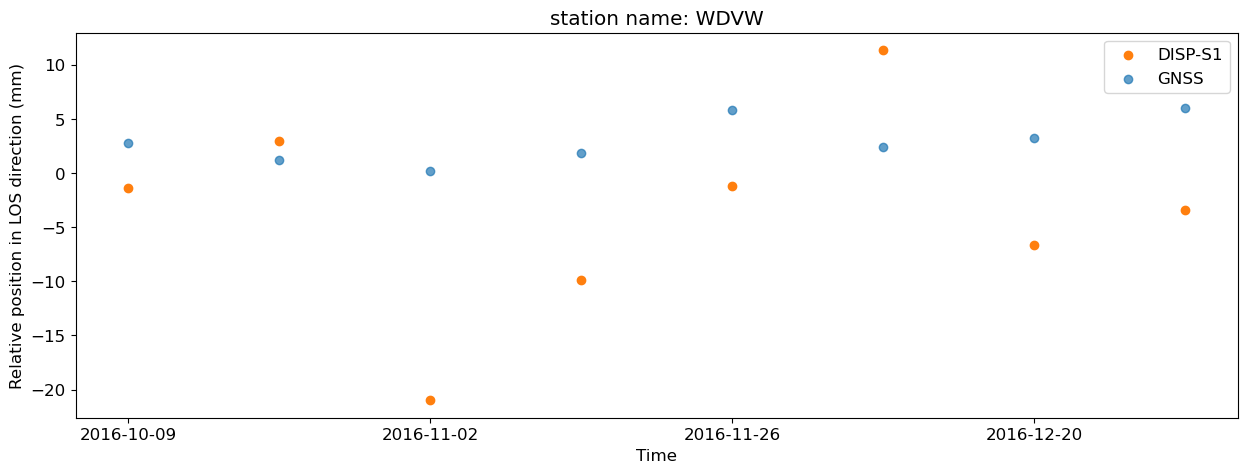

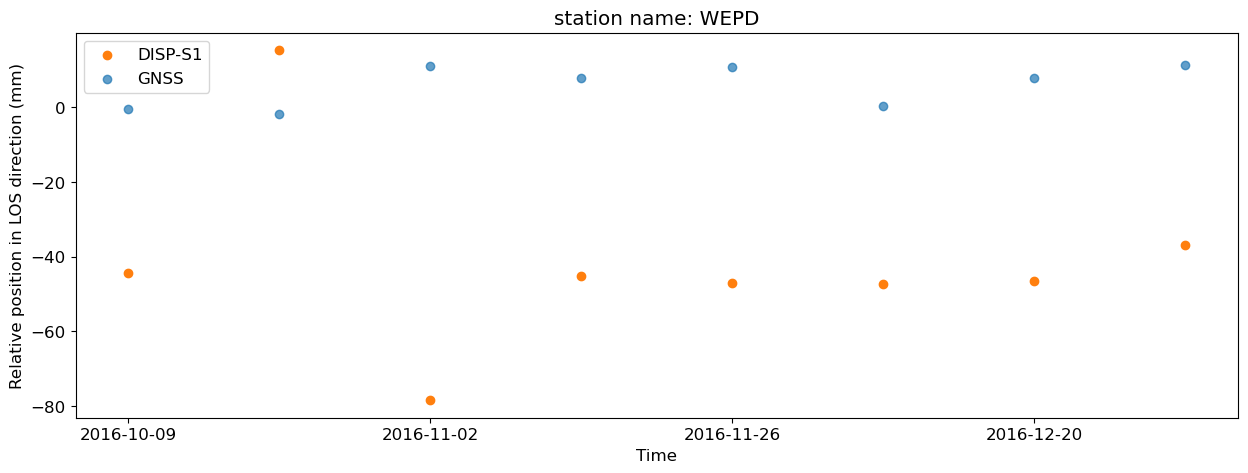

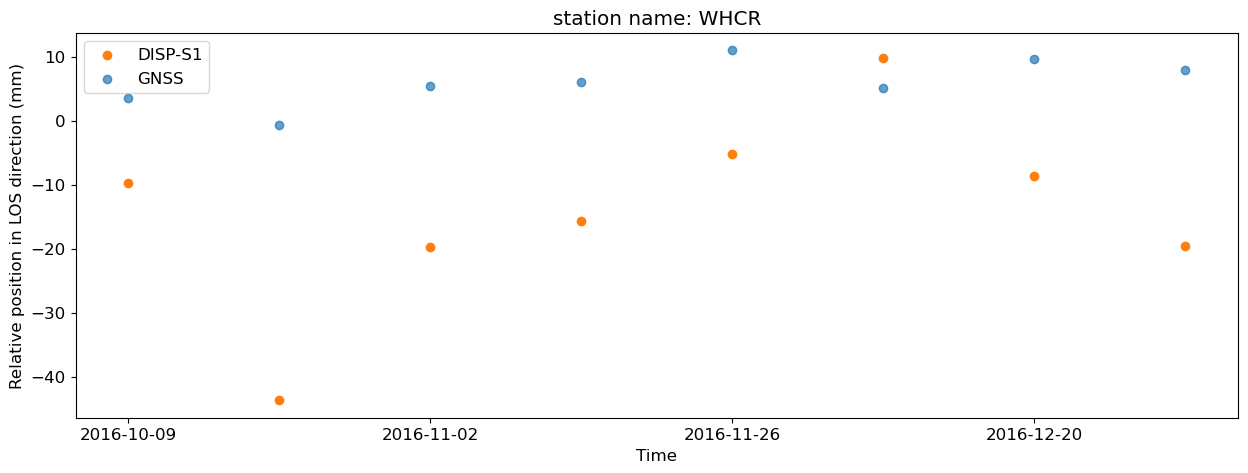

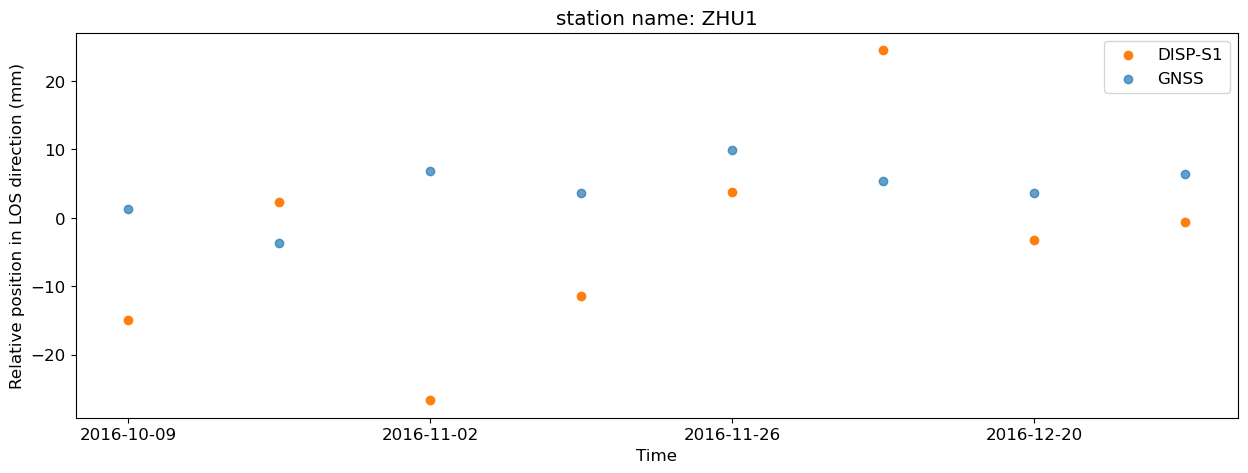

In [63]:
gnss_disp_s1_ts_plots_flag = True   # comparison of time-series gnss and DISP-S1

if gnss_disp_s1_ts_plots_flag:
    gps_ref_site_name = sites_df[sites_df["site"]==site]["gps_ref_site_name"].values[0]
    for stn in site_names:
        date_list = []
        gnss_series = []
        disp_s1_series = []
        for i in dates_index:
            # catch cases where GPS site has been filtered out
            try:
                ref_gnss_dat = displacement.loc[(i,gps_ref_site_name),'gnss_disp']
                ref_disp_s1_dat = displacement.loc[(i,gps_ref_site_name),'disp_s1']
                gnss_series.append(displacement.loc[(i,str(stn)),'gnss_disp'] - ref_gnss_dat)
                disp_s1_series.append(displacement.loc[(i,str(stn)),'disp_s1'] - ref_disp_s1_dat)
                date_list.append(ifgs_date_dt[i,1].strftime('%Y%m%d'))
            except KeyError:
                pass

        # only plot for cases where GPS site has not been filtered out
        if date_list != [] and gnss_series != [] and disp_s1_series != []:
            dt_date_list = [dt.strptime(date, '%Y%m%d').strftime('%Y-%m-%d') for date in date_list]
            # plot station TS
            fig, ax = plt.subplots(figsize=(15, 5))
            ax.set_title(f"station name: {stn}")
            ax.scatter(dt_date_list, disp_s1_series, c='#ff7f0e', label="DISP-S1")
            ax.scatter(dt_date_list, gnss_series, c='#1f77b4', label="GNSS", alpha=0.7)
            ax.set_xlabel('Time')
            ax.set_ylabel('Relative position in LOS direction (mm)')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
            ax.legend()
            plt.show()